<a href="https://colab.research.google.com/github/tamotamo17/rsna2024/blob/main/exp173_3_weight_dropdup_256_segmodel_sampler_lraug_ss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Edit from exp104

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%time
!cp /content/drive/MyDrive/ColabNotebooks/RSNA2024/data/rsna24-256.zip /content
!unzip -q rsna24-256.zip -d /content/train
!rm rsna24-256.zip

CPU times: user 709 ms, sys: 96.3 ms, total: 805 ms
Wall time: 2min 17s


In [ ]:
!pip -q install timm
!pip install -q segmentation_models_pytorch
!pip install natsort


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 32.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 67.8 MB/s eta 0:00:00


In [ ]:

DEBUG = False

In [ ]:
import os
import sys
import gc
import ast
import cv2
import time
import timm
import pickle
import random
from natsort import natsorted
import argparse
import warnings
import numpy as np
import pandas as pd
from glob import glob
from PIL import Image
from tqdm import tqdm
import albumentations as A
from pylab import rcParams
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold

import torch
import torch.nn as nn
import torch.optim as optim
import torch.cuda.amp as amp
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
import segmentation_models_pytorch as smp

%matplotlib inline
rcParams['figure.figsize'] = 20, 8
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.backends.cudnn.benchmark = True

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.17 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


# Config

In [ ]:
class CFG:
    seed = 42
    kernel_type = 'exp173_3_weight_dropdup_segmodel_sampler_lraug_ss'
    load_kernel = None
    load_last = True
    targets = [#'spinal_canal_stenosis_l1_l2', 'spinal_canal_stenosis_l2_l3', 'spinal_canal_stenosis_l3_l4',
               #'spinal_canal_stenosis_l4_l5', 'spinal_canal_stenosis_l5_s1',
            #    'left_neural_foraminal_narrowing_l1_l2', 'left_neural_foraminal_narrowing_l2_l3', 'left_neural_foraminal_narrowing_l3_l4',
            #    'left_neural_foraminal_narrowing_l4_l5', 'left_neural_foraminal_narrowing_l5_s1',
            #    'right_neural_foraminal_narrowing_l1_l2', 'right_neural_foraminal_narrowing_l2_l3', 'right_neural_foraminal_narrowing_l3_l4',
            #    'right_neural_foraminal_narrowing_l4_l5', 'right_neural_foraminal_narrowing_l5_s1',
               'left_subarticular_stenosis_l1_l2', 'left_subarticular_stenosis_l2_l3', 'left_subarticular_stenosis_l3_l4',
               'left_subarticular_stenosis_l4_l5', 'left_subarticular_stenosis_l5_s1',
               'right_subarticular_stenosis_l1_l2', 'right_subarticular_stenosis_l2_l3', 'right_subarticular_stenosis_l3_l4',
               'right_subarticular_stenosis_l4_l5', 'right_subarticular_stenosis_l5_s1'
              ]
    targets_l1_l2 = ['left_subarticular_stenosis_l1_l2', 'right_subarticular_stenosis_l1_l2']
    targets_l2_l3 = ['left_subarticular_stenosis_l2_l3', 'right_subarticular_stenosis_l2_l3']
    targets_l3_l4 = ['left_subarticular_stenosis_l3_l4', 'right_subarticular_stenosis_l3_l4']
    targets_l4_l5 = ['left_subarticular_stenosis_l4_l5', 'right_subarticular_stenosis_l4_l5']
    targets_l5_s1 = ['left_subarticular_stenosis_l5_s1', 'right_subarticular_stenosis_l5_s1']

    # targets_left = ['left_neural_foraminal_narrowing_l1_l2', 'left_neural_foraminal_narrowing_l2_l3', 'left_neural_foraminal_narrowing_l3_l4',
    #                 'left_neural_foraminal_narrowing_l4_l5', 'left_neural_foraminal_narrowing_l5_s1'
    #                 ]
    # targets_right = ['right_neural_foraminal_narrowing_l1_l2', 'right_neural_foraminal_narrowing_l2_l3', 'right_neural_foraminal_narrowing_l3_l4',
    #                  'right_neural_foraminal_narrowing_l4_l5', 'right_neural_foraminal_narrowing_l5_s1'
    #                  ]

    label2id = {'Normal/Mild': 0, 'Moderate':1, 'Severe':2}

    n_folds = 10
    backbone = "resnet18"#'tf_efficientnetv2_s_in21ft1k' #"tf_efficientnet_b0.ns_jft_in1k" #

    image_size = 224
    image_size_raw = 256
    n_slice_axial = 20
    n_slice_sagital = 10
    indices_ch = [-2, -1, 0, 1, 2]
    in_chans = len(indices_ch)
    offset = 1

    init_lr = 1e-3#1e-3
    eta_min = 1e-7
    batch_size = 32
    drop_rate = 0.
    drop_rate_last = 0.1
    drop_path_rate = 0.
    p_mixup = 1.0#0.75
    p_rand_order_v1 = 0#0.2
    mid_range = 0
    value_neighbors = 0.75
    value_neighbors2 = 0.25
    radius = 7
    radius_neighbor = 3
    radius_neighbor2 = 0
    p_drop_plane = 0.0

    data_dir = '/content/train/crop256'
    use_amp = True
    num_workers = 4
    num_targets = len(targets)
    out_dim = num_targets * 3

    n_epochs = 10
    n_epochs_mixup = n_epochs - 1
    loss_weights = [0.2, 0.4, 0.4]
    save_root = '/content/drive/MyDrive/ColabNotebooks/RSNA2024/results'
    save_dir = os.path.join(save_root, kernel_type)

    log_dir = os.path.join('logs', save_dir)
    model_dir = os.path.join(save_dir, 'models')
    os.makedirs(log_dir, exist_ok=True)
    os.makedirs(model_dir, exist_ok=True)

In [ ]:
def set_random_seed(seed: int = 8620, deterministic: bool = False):
    """Set seeds"""
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = deterministic  # type: ignore

set_random_seed(CFG.seed)

In [ ]:
transforms_train = A.Compose([
    #A.CenterCrop(180, 180, p=1.0),
    A.Resize(CFG.image_size, CFG.image_size),
    #A.RandomBrightness(limit=0.1, p=0.7),
    A.RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.7),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.3, rotate_limit=20, border_mode=0, p=0.7),

    A.OneOf([
        A.MotionBlur(blur_limit=3),
        A.MedianBlur(blur_limit=3),
        A.GaussianBlur(blur_limit=3),
        A.GaussNoise(var_limit=(3.0, 9.0)),
    ], p=0.5),
    # A.OneOf([
    #     A.OpticalDistortion(distort_limit=1.0),
    #     A.GridDistortion(num_steps=5, distort_limit=1.),
    #     A.ElasticTransform(alpha=3),
    # ], p=0.5),

    #A.Cutout(max_h_size=int(CFG.image_size / 8), max_w_size=int(CFG.image_size /8), num_holes=3, p=0.5),
    #A.CoarseDropout(num_holes_range=(1, 3), hole_height_range=(int(CFG.image_size / 16), int(CFG.image_size / 8)), hole_width_range=(int(CFG.image_size / 16), int(CFG.image_size / 8)))
])

transforms_valid = A.Compose([
    #A.CenterCrop(180, 180, p=1.0),
    A.Resize(CFG.image_size, CFG.image_size),
])

/usr/local/lib/python3.10/dist-packages/pydantic/main.py:212: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  validated_self = self.__pydantic_validator__.validate_python(data, self_instance=self)


# DataFrame

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/RSNA2024/data/train.csv')
df_lc = pd.read_csv('/content/train/train_label_coordinates_v2.csv')
df_sd = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/RSNA2024/data/train_series_descriptions.csv')
df = df.sample( 16).reset_index(drop=True) if DEBUG else df
df

,study_id,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1,left_neural_foraminal_narrowing_l1_l2,left_neural_foraminal_narrowing_l2_l3,left_neural_foraminal_narrowing_l3_l4,left_neural_foraminal_narrowing_l4_l5,...,left_subarticular_stenosis_l1_l2,left_subarticular_stenosis_l2_l3,left_subarticular_stenosis_l3_l4,left_subarticular_stenosis_l4_l5,left_subarticular_stenosis_l5_s1,right_subarticular_stenosis_l1_l2,right_subarticular_stenosis_l2_l3,right_subarticular_stenosis_l3_l4,right_subarticular_stenosis_l4_l5,right_subarticular_stenosis_l5_s1
0,4003253,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
1,4646740,Normal/Mild,Normal/Mild,Moderate,Severe,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild,Normal/Mild,Moderate,Moderate,Moderate,Normal/Mild
2,7143189,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
3,8785691,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
4,10728036,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1970,4282019580,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Moderate,Moderate
1971,4283570761,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
1972,4284048608,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild
1973,4287160193,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Severe,Moderate,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Moderate,Normal/Mild


In [ ]:
df[df.isna().any(axis=1)]

,study_id,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1,left_neural_foraminal_narrowing_l1_l2,left_neural_foraminal_narrowing_l2_l3,left_neural_foraminal_narrowing_l3_l4,left_neural_foraminal_narrowing_l4_l5,...,left_subarticular_stenosis_l1_l2,left_subarticular_stenosis_l2_l3,left_subarticular_stenosis_l3_l4,left_subarticular_stenosis_l4_l5,left_subarticular_stenosis_l5_s1,right_subarticular_stenosis_l1_l2,right_subarticular_stenosis_l2_l3,right_subarticular_stenosis_l3_l4,right_subarticular_stenosis_l4_l5,right_subarticular_stenosis_l5_s1
16,46494080,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,NaN,NaN,Normal/Mild,Moderate,Moderate,NaN,NaN,Moderate,Moderate,Normal/Mild
24,64092030,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,NaN,Normal/Mild,NaN,Moderate,Moderate,NaN,Moderate,NaN,Normal/Mild,Normal/Mild
30,74782131,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,NaN,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,NaN,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
43,97086905,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,...,NaN,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,NaN,Normal/Mild,Normal/Mild,Moderate,Normal/Mild
73,159721286,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Moderate,...,NaN,NaN,Normal/Mild,Moderate,Normal/Mild,NaN,NaN,Moderate,Severe,Normal/Mild
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1905,4140710202,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,NaN,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,NaN,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
1911,4146959702,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,NaN,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,NaN,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
1925,4175603528,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,NaN,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,NaN,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
1950,4232806580,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,NaN,NaN,Moderate,Moderate,Moderate,NaN,NaN,Normal/Mild,Moderate,Normal/Mild


In [ ]:
df_lc['condition'].unique()

array(['Spinal Canal Stenosis', 'Right Neural Foraminal Narrowing',
       'Left Neural Foraminal Narrowing', 'Left Subarticular Stenosis',
       'Right Subarticular Stenosis'], dtype=object)

In [ ]:
ids_unique = df_lc.loc[(df_lc['condition']=='Right Subarticular Stenosis')|(df_lc['condition']=='Left Subarticular Stenosis'), 'series_id'].unique()
print(df_sd.loc[df_sd['series_id'].isin(ids_unique), 'series_description'].value_counts())

series_description
Axial T2    2339
Name: count, dtype: int64


In [ ]:
df_lc

,study_id,series_id,instance_number,condition,level,x,y,height,width,height_space,width_space
0,4003253,702807833,8,Spinal Canal Stenosis,L1/L2,322.831858,227.964602,640,640,0.46875,0.46875
1,4003253,702807833,8,Spinal Canal Stenosis,L2/L3,320.571429,295.714286,640,640,0.46875,0.46875
2,4003253,702807833,8,Spinal Canal Stenosis,L3/L4,323.030303,371.818182,640,640,0.46875,0.46875
3,4003253,702807833,8,Spinal Canal Stenosis,L4/L5,335.292035,427.327434,640,640,0.46875,0.46875
4,4003253,702807833,8,Spinal Canal Stenosis,L5/S1,353.415929,483.964602,640,640,0.46875,0.46875
...,...,...,...,...,...,...,...,...,...,...,...
48687,4290709089,4237840455,11,Left Neural Foraminal Narrowing,L1/L2,219.465940,97.831063,384,384,0.78125,0.78125
48688,4290709089,4237840455,12,Left Neural Foraminal Narrowing,L2/L3,205.340599,140.207084,384,384,0.78125,0.78125
48689,4290709089,4237840455,12,Left Neural Foraminal Narrowing,L3/L4,202.724796,181.013624,384,384,0.78125,0.78125
48690,4290709089,4237840455,12,Left Neural Foraminal Narrowing,L4/L5,202.933333,219.733333,384,384,0.78125,0.78125


In [ ]:
df_lc['condition'].unique()

array(['Spinal Canal Stenosis', 'Right Neural Foraminal Narrowing',
       'Left Neural Foraminal Narrowing', 'Left Subarticular Stenosis',
       'Right Subarticular Stenosis'], dtype=object)

In [ ]:
def get_new_xy(row):
    new_size = CFG.image_size_raw
    x = row['x']
    y = row['y']
    h = row['height']
    w = row['width']
    aspect_ratio = w/h
    if aspect_ratio>1:
        new_w = new_size
        new_h = int(new_size / aspect_ratio)
    else:
        new_h = new_size
        new_w = int(new_size * aspect_ratio)
    start_x = (new_size - new_w) // 2
    start_y = (new_size - new_h) // 2
    new_x = start_x + int(x * (new_w / w))
    new_y = start_y + int(y * (new_h / h))
    return pd.Series({'x_new': new_x,
                      'y_new': new_y})

In [ ]:
df_lc[['x_new', 'y_new']] = df_lc.apply(get_new_xy, axis=1)

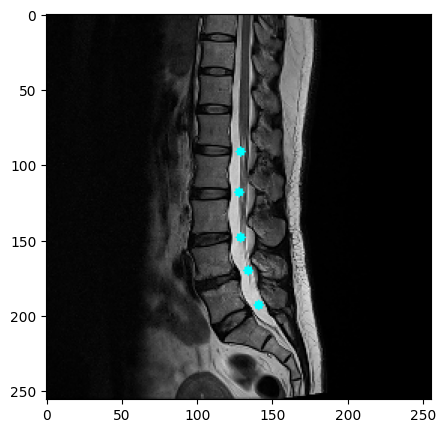

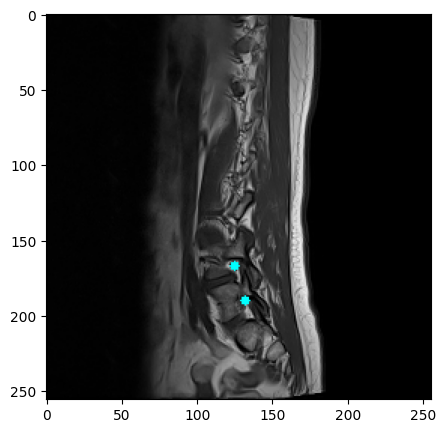

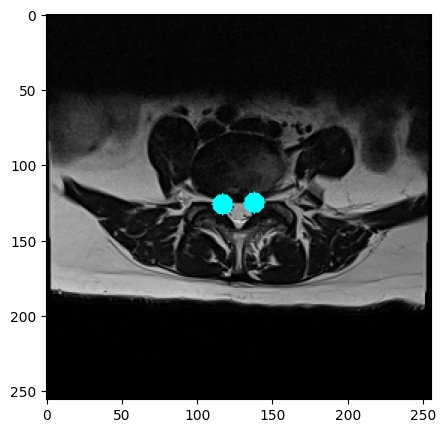

In [ ]:
# Sagital T2/STIR
study_id = 4003253
series_id = 702807833
instance_number = 8
img = cv2.imread(os.path.join(CFG.data_dir, f'{study_id}/{series_id}/{instance_number}.png'))
df_lc_slice = df_lc[(df_lc['study_id']==study_id)&(df_lc['series_id']==series_id)&(df_lc['instance_number']==instance_number)]
for i, row in df_lc_slice.iterrows():
    cv2.circle(img, (row['x_new'], row['y_new']), 3, (0, 255, 255), -1)
plt.figure(figsize=(5,5))
plt.imshow(img)

# Sagital T1
study_id = 4003253
series_id = 1054713880
instance_number = 4
img = cv2.imread(os.path.join(CFG.data_dir, f'{study_id}/{series_id}/{instance_number}.png'))
df_lc_slice = df_lc[(df_lc['study_id']==study_id)&(df_lc['series_id']==series_id)&(df_lc['instance_number']==instance_number)]
for i, row in df_lc_slice.iterrows():
    cv2.circle(img, (row['x_new'], row['y_new']), 3, (0, 255, 255), -1)
plt.figure(figsize=(5,5))
plt.imshow(img)

# Axial T2
study_id = 4003253
series_id = 2448190387
instance_number = 28
img = cv2.imread(os.path.join(CFG.data_dir, f'{study_id}/{series_id}/{instance_number}.png'))
df_lc_slice = df_lc[(df_lc['study_id']==study_id)&(df_lc['series_id']==series_id)&(df_lc['instance_number']==instance_number)]
for i, row in df_lc_slice.iterrows():
    cv2.circle(img, (row['x_new'], row['y_new']), 7, (0, 255, 255), -1)
plt.figure(figsize=(5,5))
plt.imshow(img)

array([[<Axes: title={'center': 'series_id'}>,
        <Axes: title={'center': 'instance_number'}>,
        <Axes: title={'center': 'condition'}>],
       [<Axes: title={'center': 'level'}>, <Axes: title={'center': 'x'}>,
        <Axes: title={'center': 'y'}>],
       [<Axes: title={'center': 'height'}>,
        <Axes: title={'center': 'width'}>,
        <Axes: title={'center': 'height_space'}>],
       [<Axes: title={'center': 'width_space'}>,
        <Axes: title={'center': 'x_new'}>,
        <Axes: title={'center': 'y_new'}>]], dtype=object)

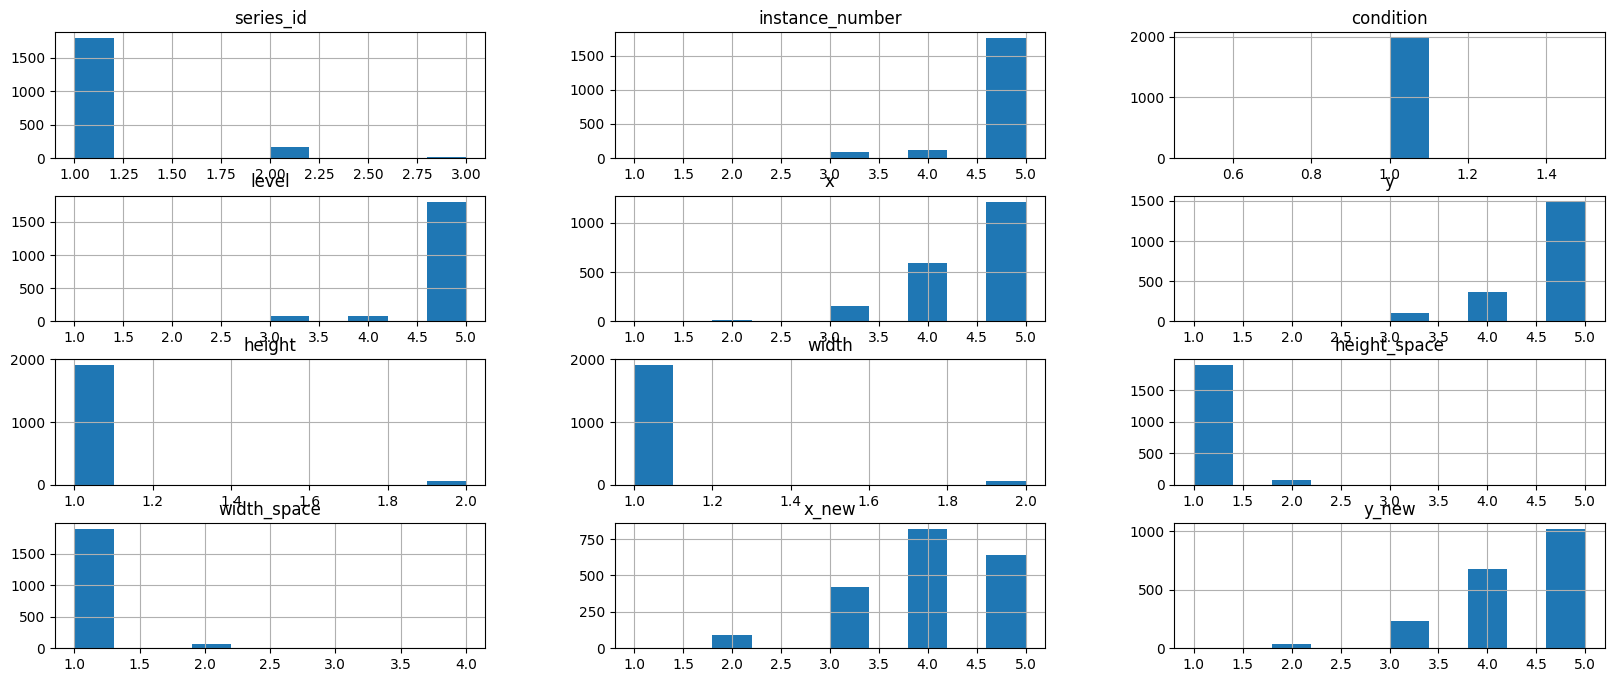

In [ ]:
df_lc_ss = df_lc[(df_lc['condition']=='Right Subarticular Stenosis')].reset_index(drop=True)
df_lc_ss.groupby('study_id').nunique().hist()

In [ ]:
df_lc_ss

,study_id,series_id,instance_number,condition,level,x,y,height,width,height_space,width_space,x_new,y_new
0,4003253,2448190387,4,Right Subarticular Stenosis,L1/L2,145.288771,158.624642,320,320,0.6250,0.6250,116,126
1,4003253,2448190387,11,Right Subarticular Stenosis,L2/L3,145.900042,157.096466,320,320,0.6250,0.6250,116,125
2,4003253,2448190387,19,Right Subarticular Stenosis,L3/L4,142.843690,156.179561,320,320,0.6250,0.6250,114,124
3,4003253,2448190387,28,Right Subarticular Stenosis,L4/L5,147.428218,158.013372,320,320,0.6250,0.6250,117,126
4,4003253,2448190387,35,Right Subarticular Stenosis,L5/S1,145.900042,161.375358,320,320,0.6250,0.6250,116,129
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9607,4290709089,3390218084,2,Right Subarticular Stenosis,L1/L2,307.180844,354.869960,640,640,0.3125,0.3125,122,141
9608,4290709089,3390218084,6,Right Subarticular Stenosis,L2/L3,301.440933,362.044847,640,640,0.3125,0.3125,120,144
9609,4290709089,3390218084,10,Right Subarticular Stenosis,L3/L4,302.875911,356.304937,640,640,0.3125,0.3125,121,142
9610,4290709089,3390218084,15,Right Subarticular Stenosis,L4/L5,305.745866,340.520184,640,640,0.3125,0.3125,122,136


array([[<Axes: title={'center': 'series_id'}>,
        <Axes: title={'center': 'instance_number'}>,
        <Axes: title={'center': 'condition'}>],
       [<Axes: title={'center': 'level'}>, <Axes: title={'center': 'x'}>,
        <Axes: title={'center': 'y'}>],
       [<Axes: title={'center': 'height'}>,
        <Axes: title={'center': 'width'}>,
        <Axes: title={'center': 'height_space'}>],
       [<Axes: title={'center': 'width_space'}>,
        <Axes: title={'center': 'x_new'}>,
        <Axes: title={'center': 'y_new'}>]], dtype=object)

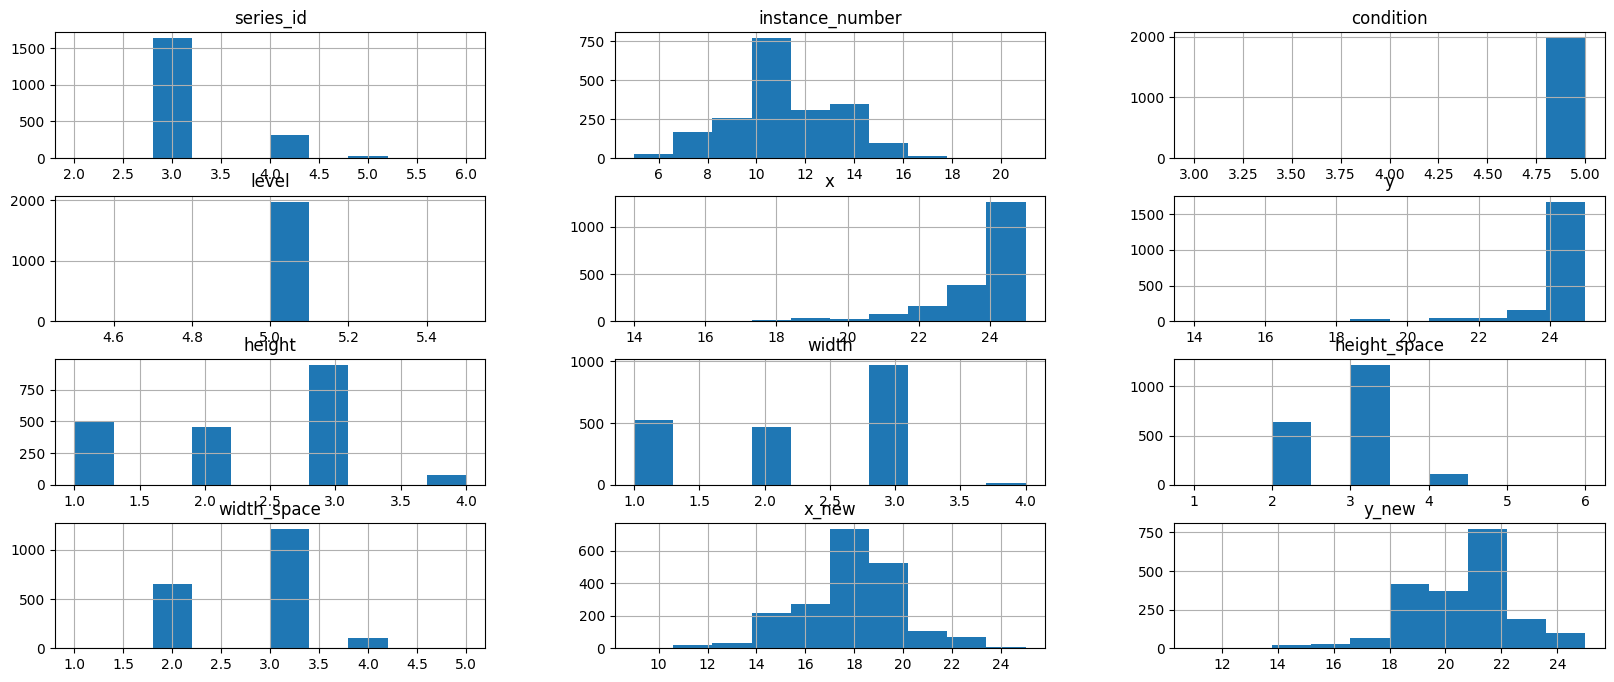

In [ ]:
df_lc.groupby('study_id').nunique().hist()

In [ ]:
df_sd

,study_id,series_id,series_description
0,4003253,702807833,Sagittal T2/STIR
1,4003253,1054713880,Sagittal T1
2,4003253,2448190387,Axial T2
3,4646740,3201256954,Axial T2
4,4646740,3486248476,Sagittal T1
...,...,...,...
6289,4287160193,1507070277,Sagittal T2/STIR
6290,4287160193,1820446240,Axial T2
6291,4290709089,3274612423,Sagittal T2/STIR
6292,4290709089,3390218084,Axial T2


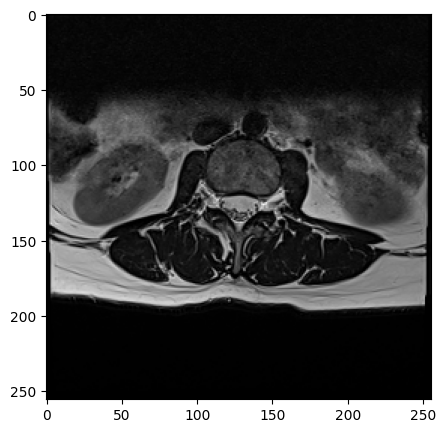

In [ ]:
# Axial T2
study_id = 4003253
series_id = 2448190387
img = cv2.imread(os.path.join(CFG.data_dir, f'{study_id}/{series_id}/10.png'))
plt.figure(figsize=(5,5))
plt.imshow(img)

In [ ]:
df_sd.study_id.unique()

array([   4003253,    4646740,    7143189, ..., 4284048608, 4287160193,
       4290709089])

In [ ]:
def get_row_from_series_description(df_series, image_type):
    row = df_series[df_series['series_description']==image_type]
    try:
        series = row.sample(1).iloc[0]
    except:
        series = None
    return series
study_ids = []
num_imgs_sat2, num_imgs_sat1, num_imgs_axt2 = [], [], []
series_ids_sat2, series_ids_sat1, series_ids_axt2 = [], [], []
for i, row in df.iterrows():
    sid = row['study_id']
    df_series = df_sd[df_sd['study_id']==sid]
    row_sat2 = get_row_from_series_description(df_series, 'Sagittal T2/STIR')
    row_sat1 = get_row_from_series_description(df_series, 'Sagittal T1')
    row_axt2 = get_row_from_series_description(df_series, 'Axial T2')
    if row_sat2 is not None:
        filenames = glob(os.path.join(CFG.data_dir, str(sid), str(row_sat2['series_id']), '*.png'))
        num_imgs_sat2.append(len(filenames))
        series_ids_sat2.append(row_sat2['series_id'])
    else:
        num_imgs_sat2.append(0)
        series_ids_sat2.append(None)
    if row_sat1 is not None:
        filenames = glob(os.path.join(CFG.data_dir, str(sid), str(row_sat1['series_id']), '*.png'))
        num_imgs_sat1.append(len(filenames))
        series_ids_sat1.append(row_sat1['series_id'])
    else:
        num_imgs_sat1.append(0)
        series_ids_sat1.append(None)
    if row_axt2 is not None:
        filenames = glob(os.path.join(CFG.data_dir, str(sid), str(row_axt2['series_id']), '*.png'))
        num_imgs_axt2.append(len(filenames))
        series_ids_axt2.append(row_axt2['series_id'])
    else:
        num_imgs_axt2.append(0)
        series_ids_axt2.append(None)
    study_ids.append(sid)

Text(0.5, 1.0, 'Axial T2 5, 192')

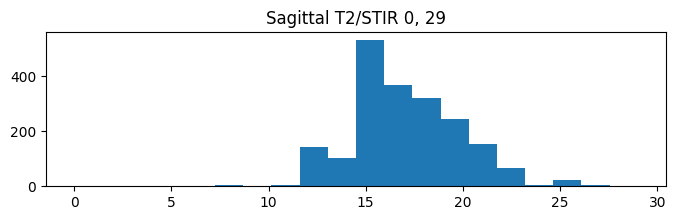

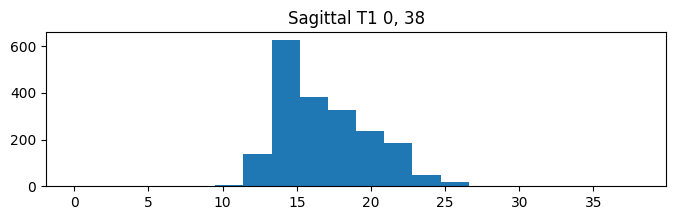

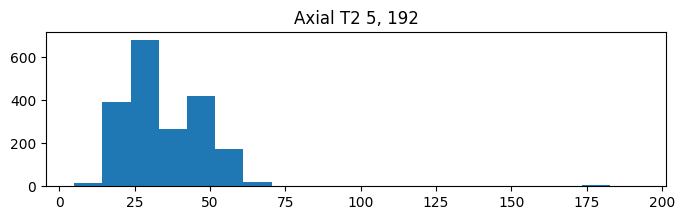

In [ ]:
plt.figure(figsize=(8,2))
plt.hist(num_imgs_sat2, bins=20)
plt.title(f'Sagittal T2/STIR {min(num_imgs_sat2)}, {max(num_imgs_sat2)}')

plt.figure(figsize=(8,2))
plt.hist(num_imgs_sat1, bins=20)
plt.title(f'Sagittal T1 {min(num_imgs_sat1)}, {max(num_imgs_sat1)}')

plt.figure(figsize=(8,2))
plt.hist(num_imgs_axt2, bins=20)
plt.title(f'Axial T2 {min(num_imgs_axt2)}, {max(num_imgs_axt2)}')

In [ ]:
df_sd[df_sd['study_id']==4290709089]

,study_id,series_id,series_description
6291,4290709089,3274612423,Sagittal T2/STIR
6292,4290709089,3390218084,Axial T2
6293,4290709089,4237840455,Sagittal T1


In [ ]:
df_sd['series_description'].unique()

array(['Sagittal T2/STIR', 'Sagittal T1', 'Axial T2'], dtype=object)

array([[<Axes: title={'center': 'series_id'}>,
        <Axes: title={'center': 'series_description'}>]], dtype=object)

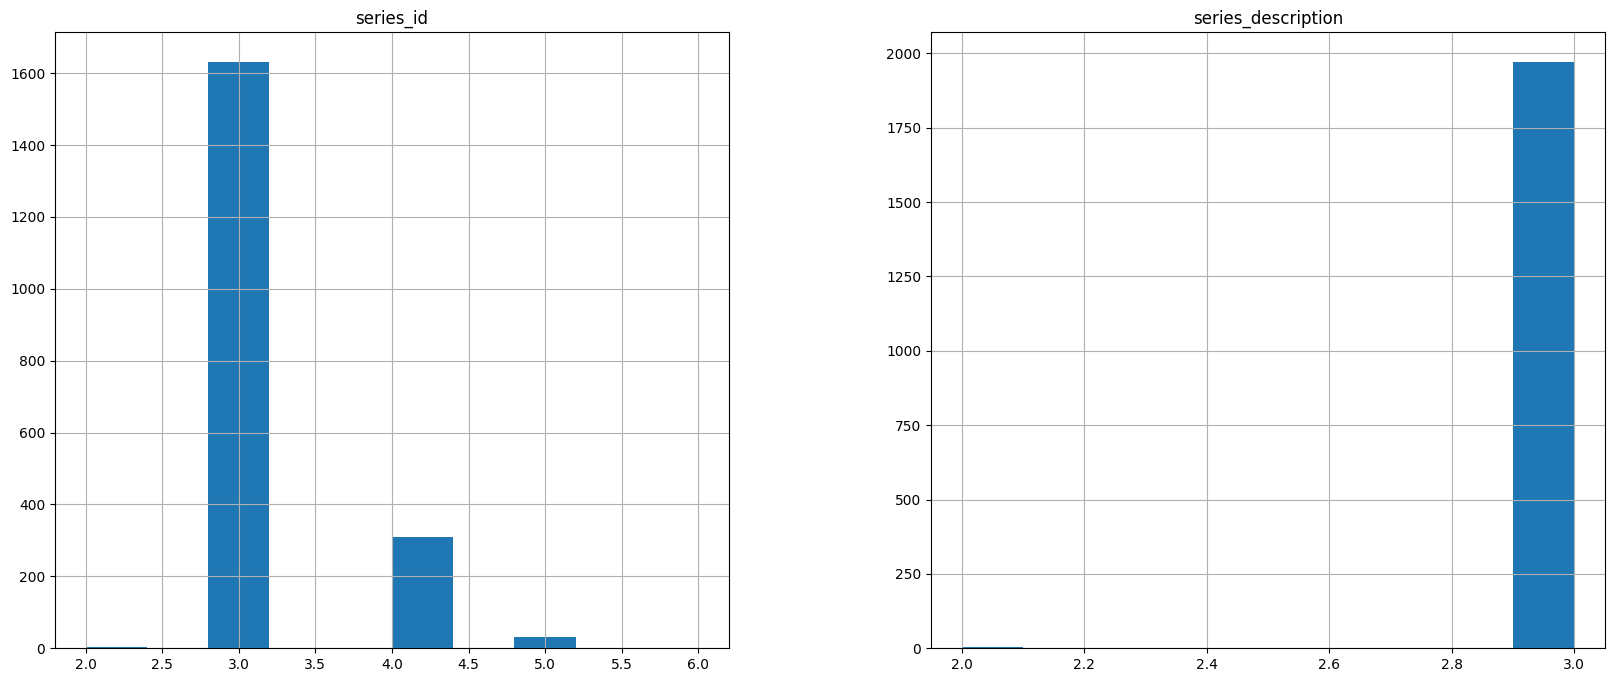

In [ ]:
df_sd.groupby('study_id').nunique().hist()

# Dataset

In [ ]:
class RSNADataset(Dataset):
    def __init__(self, df, df_lc, df_sd,
                 num_slice_sagital, num_slice_axial,
                 channel_offsets, mid_range,
                 value_neighbors, value_neighbors2,
                 mode, transform):

        self.df = df
        self.df_lc = df_lc
        self.df_sd = df_sd
        self.num_slice_sagital = num_slice_sagital
        self.num_slice_axial = num_slice_axial
        self.channel_offsets = channel_offsets
        self.mid_range = mid_range
        self.value_neighbors = value_neighbors
        self.value_neighbors2 = value_neighbors2
        self.mode = mode
        self.transform = transform

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        row = self.df.iloc[index]
        sid = row['study_id']
        df_series = self.df_sd[self.df_sd['study_id']==sid].reset_index(drop=True)
        df_lc = self.df_lc[(self.df_lc['study_id']==sid)].reset_index(drop=True)

        filenames_sat2, labels_aux_sat2 = self.get_files_and_auxlabel_from_series_description(df_series, df_lc, 'Sagittal T2/STIR')
        filenames_sat1, labels_aux_sat1 = self.get_files_and_auxlabel_from_series_description(df_series, df_lc, 'Sagittal T1')
        filenames_axt2, labels_aux_axt2 = self.get_files_and_auxlabel_from_series_description(df_series, df_lc, 'Axial T2')
        if labels_aux_sat2 is not None:
            labels_aux_sat2 = self.replace_vertical_neighbors(labels_aux_sat2, self.value_neighbors, self.value_neighbors2)
        if labels_aux_sat1 is not None:
            labels_aux_sat1 = self.replace_vertical_neighbors(labels_aux_sat1, self.value_neighbors, self.value_neighbors2)
        if labels_aux_axt2 is not None:
            labels_aux_axt2 = self.replace_vertical_neighbors(labels_aux_axt2, self.value_neighbors, self.value_neighbors2)
        num_files_sat2 = len(filenames_sat2)
        num_files_sat1 = len(filenames_sat1)
        num_files_axt2 = len(filenames_axt2)
        indices_sat2 = self.get_slice_indices(num_files_sat2, self.num_slice_sagital)
        indices_sat1 = self.get_slice_indices(num_files_sat1, self.num_slice_sagital)
        indices_axt2 = self.get_slice_indices(num_files_axt2, self.num_slice_axial)
        idx_plane = None
        if (self.mode == 'train')&(random.random() < CFG.p_drop_plane):
            idx_plane = random.randint(0,2)

        imgs_sat2, imgs_sat1, imgs_axt2 = [], [], []
        for idx in indices_sat2:
            img = self.load_images(idx, filenames_sat2)
            imgs_sat2.append(img)
        if (len(imgs_sat2)==0)|(idx_plane==0):
            imgs_sat2 = np.zeros([self.num_slice_sagital, len(self.channel_offsets), CFG.image_size, CFG.image_size], dtype=np.float32)
            labels_aux_sat2 = np.zeros([self.num_slice_sagital, 5], dtype=np.float32)
        else:
            imgs_sat2 = np.stack(imgs_sat2, 0)
            n, h, w, c = imgs_sat2.shape
            imgs_sat2 = imgs_sat2.transpose(1,2,0,3)
            imgs_sat2 = imgs_sat2.reshape(h, w, n*c)
            imgs_sat2 = self.transform(image=imgs_sat2)['image']
            imgs_sat2 = imgs_sat2.reshape(CFG.image_size, CFG.image_size, n, c)
            imgs_sat2 = imgs_sat2.transpose(2,3,0,1)
            imgs_sat2 = imgs_sat2.astype(np.float32) / 255.
            labels_aux_sat2 = labels_aux_sat2[np.clip(indices_sat2, 0, num_files_sat2-1)]
        for idx in indices_sat1:
            img = self.load_images(idx, filenames_sat1)
            imgs_sat1.append(img)
        if (len(imgs_sat1)==0)|(idx_plane==1):
            imgs_sat1 = np.zeros([self.num_slice_sagital, len(self.channel_offsets), CFG.image_size, CFG.image_size], dtype=np.float32)
            labels_aux_sat1 = np.zeros([self.num_slice_sagital, 5], dtype=np.float32)
        else:
            imgs_sat1 = np.stack(imgs_sat1, 0)
            n, h, w, c = imgs_sat1.shape
            imgs_sat1 = imgs_sat1.transpose(1,2,0,3)
            imgs_sat1 = imgs_sat1.reshape(h, w, n*c)
            imgs_sat1 = self.transform(image=imgs_sat1)['image']
            imgs_sat1 = imgs_sat1.reshape(CFG.image_size, CFG.image_size, n, c)
            imgs_sat1 = imgs_sat1.transpose(2,3,0,1)
            imgs_sat1 = imgs_sat1.astype(np.float32) / 255.
            labels_aux_sat1 = labels_aux_sat1[np.clip(indices_sat1, 0, num_files_sat1-1)]

        for idx in indices_axt2:
            img = self.load_images(idx, filenames_axt2)
            imgs_axt2.append(img)
        if (len(imgs_axt2)==0)|(idx_plane==2):
            imgs_axt2 = np.zeros([self.num_slice_axial, len(self.channel_offsets), CFG.image_size, CFG.image_size], dtype=np.float32)
            labels_aux_axt2 = np.zeros([self.num_slice_axial, 5], dtype=np.float32)
        else:
            imgs_axt2 = np.stack(imgs_axt2, 0)
            n, h, w, c = imgs_axt2.shape
            imgs_axt2 = imgs_axt2.transpose(1,2,0,3)
            imgs_axt2 = imgs_axt2.reshape(h, w, n*c)
            imgs_axt2 = self.transform(image=imgs_axt2)['image']
            imgs_axt2 = imgs_axt2.reshape(CFG.image_size, CFG.image_size, n, c)
            imgs_axt2 = imgs_axt2.transpose(2,3,0,1)
            imgs_axt2 = imgs_axt2.astype(np.float32) / 255.
            labels_aux_axt2 = labels_aux_axt2[np.clip(indices_axt2, 0, num_files_axt2-1)]

        if self.mode != 'test':
            if (self.mode == 'train')&(random.random() < 0.5):
                imgs_sat2 = imgs_sat2[::-1,::-1].copy()
                imgs_sat1 = imgs_sat1[::-1,::-1].copy()
                imgs_axt2 = imgs_axt2[::-1,::-1].copy()
                labels_aux_sat1 = labels_aux_sat1[::-1].copy()
                labels_aux_sat2 = labels_aux_sat2[::-1].copy()
                labels_aux_axt2 = labels_aux_axt2[::-1].copy()
            imgs_sat2 = torch.tensor(imgs_sat2).float()
            imgs_sat1 = torch.tensor(imgs_sat1).float()
            imgs_axt2 = torch.tensor(imgs_axt2).float()

            labels = torch.tensor(row[CFG.targets].values.astype(np.int64))
            # labels_l1_l2 = torch.tensor(row[CFG.targets_l1_l2].values.astype(np.int64))
            # labels_l2_l3 = torch.tensor(row[CFG.targets_l2_l3].values.astype(np.int64))
            # labels_l3_l4 = torch.tensor(row[CFG.targets_l3_l4].values.astype(np.int64))
            # labels_l4_l5 = torch.tensor(row[CFG.targets_l4_l5].values.astype(np.int64))
            # labels_l5_s1 = torch.tensor(row[CFG.targets_l5_s1].values.astype(np.int64))

            labels_aux_sat1 = torch.tensor(labels_aux_sat1)
            labels_aux_sat2 = torch.tensor(labels_aux_sat2)
            labels_aux_axt2 = torch.tensor(labels_aux_axt2)

            if self.mode == 'train' and random.random() < CFG.p_rand_order_v1:
                indices = torch.randperm(imgs_sat2.size(0))
                imgs_sat2 = imgs_sat2[indices]
                indices = torch.randperm(imgs_sat1.size(0))
                imgs_sat1 = imgs_sat1[indices]
                indices = torch.randperm(imgs_axt2.size(0))
                imgs_axt2 = imgs_axt2[indices]

            return {'image_sat1': imgs_sat1.float(),
                    'image_sat2': imgs_sat2.float(),
                    'image_axt2': imgs_axt2.float(),
                    'label': labels,
                    # 'label_l1_l2': labels_l1_l2,
                    # 'label_l2_l3': labels_l2_l3,
                    # 'label_l3_l4': labels_l3_l4,
                    # 'label_l4_l5': labels_l4_l5,
                    # 'label_l5_s1': labels_l5_s1,
                    'label_aux_sat1': labels_aux_sat1,
                    'label_aux_sat2': labels_aux_sat2,
                    'label_aux_axt2': labels_aux_axt2,
                   }
        else:
            return {'image_sat1': imgs_sat1.float(),
                    'image_sat2': imgs_sat2.float(),
                    'image_axt2': imgs_axt2.float(),
                    }

    def get_files_and_auxlabel_from_series_description(self, df_series, df_lc, image_type):
        sd2conds = {'Sagittal T2/STIR': ['Spinal Canal Stenosis'],
                   'Sagittal T1': ['Left Neural Foraminal Narrowing', 'Right Neural Foraminal Narrowing'],
                   'Axial T2': ['Left Subarticular Stenosis', 'Right Subarticular Stenosis']
                   }
        levels2idx = {'L1/L2': 0,
                      'L2/L3': 1,
                      'L3/L4': 2,
                      'L4/L5': 3,
                      'L5/S1': 4
                      }
        row_series = df_series[df_series['series_description']==image_type]
        new_row_lc = []
        conds = sd2conds[image_type]
        for cond in conds:
            new_row_lc.append(df_lc[df_lc['condition']==cond])
        new_row_lc = pd.concat(new_row_lc).reset_index(drop=True)
        try:
            if self.mode=='train':
                series = row_series.sample(1).iloc[0]
            else:
                series = row_series.iloc[0]
            sid = series['study_id']
            seid = series['series_id']
            new_row_lc = new_row_lc[new_row_lc['series_id']==seid]
            #print(os.path.join(CFG.data_dir, str(sid), str(series['series_id']), '*.png'))
            filenames = glob(os.path.join(CFG.data_dir, str(sid), str(seid), '*.png'))
            filenames = natsorted(filenames)
            labels_aux = np.zeros([len(filenames), 5], dtype=np.float32)
            for i, filename in enumerate(filenames):
                sid_, seid_ = filename.split('/')[-2:]
                seid_ = seid_.split('.')[0]
                row_lc_labeled = new_row_lc[new_row_lc['instance_number']==int(seid_)]
                if len(row_lc_labeled)!=0:
                    for j, row in row_lc_labeled.iterrows():
                        level_idx = levels2idx[row['level']]
                        labels_aux[i,level_idx] = 1.0
        except:
            filenames = []
            labels_aux = None
        return filenames, labels_aux

    def get_slice_indices(self, num_files, num_slices):
        if num_files==0:
            indices = []
        else:
            mid = int(num_files/num_slices/2)
            indices = np.round(np.linspace(mid, num_files - mid, num_slices)).astype(int)
            if self.mode=='train':
                v = min(self.mid_range, mid)
                offset = np.random.choice(np.arange(-v, v+1))
                indices += offset
        return indices

    def replace_vertical_neighbors(self, arr, replace_value=0.5, replace_value2=0.5):
        # Create a copy of the original array to avoid modifying it
        modified_arr = arr.copy()

        # Get the shape of the array
        rows, cols = arr.shape

        # Iterate over each element in the array
        for i in range(rows):
            for j in range(cols):
                if arr[i, j] == 1:
                    # Check the top neighbor
                    if i > 0 and arr[i-1, j] != 1:
                        modified_arr[i-1, j] = replace_value
                    if i > 1 and arr[i-2, j] != 1:
                        modified_arr[i-2, j] = replace_value2
                    # Check the bottom neighbor
                    if i < rows-1 and arr[i+1, j] != 1:
                        modified_arr[i+1, j] = replace_value
                    if i < rows-2 and arr[i+2, j] != 1:
                        modified_arr[i+2, j] = replace_value2

        return modified_arr

    def load_images(self, idx, filenames):
        imgs = []
        idx_max = len(filenames) - 1
        for offset in self.channel_offsets:
            idx_img = np.clip(idx + offset, 0, idx_max)
            img = cv2.imread(filenames[idx_img], cv2.IMREAD_GRAYSCALE)
            imgs.append(img)
        imgs = np.array(imgs).transpose(1,2,0)
        return imgs

class RSNADatasetAxt2(Dataset):
    def __init__(self, df, df_lc, df_sd,
                 channel_offsets, mid_range,
                 mode, transform):

        self.df = df
        self.df_lc = df_lc
        self.channel_offsets = channel_offsets
        self.mid_range = mid_range
        self.mode = mode
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        row = self.df_lc.iloc[index]
        sid = row['study_id']
        seid = row['series_id']
        inumber = row['instance_number']
        condition = row['condition']
        level = row['level']
        obj = row['object']
        row_labels = self.df[(self.df['study_id']==sid)]
        if len(row_labels)!=1:
            print(len(row_labels))
            print('label is invalid')
        row_labels = row_labels.iloc[0]
        filenames = glob(os.path.join(CFG.data_dir, str(sid), str(seid), '*.png'))
        filenames = natsorted(filenames)
        inumbers = [int(filename.split('/')[-1].split('.')[0]) for filename in filenames]
        idx_inumber = inumbers.index(inumber)
        imgs = self.load_images(filenames, sid, seid, idx_inumber)
        masks = self.get_mask(seid, inumber)
        data = self.transform(image=imgs, mask=masks)
        imgs = data['image']
        masks = data['mask']

        imgs = imgs.transpose(2,0,1)
        imgs = imgs.astype(np.float32) / 255.
        masks = masks.transpose(2,0,1)
        masks = masks.astype(np.float32)

        if self.mode != 'test':
            weights = [1.0, 2.0, 4.0]
            if (self.mode == 'train')&(random.random() < 0.5):
                imgs = imgs[::-1,::-1].copy()
                masks = masks[::-1,::-1].copy()
            if not pd.isna(level):
                if level=='L1/L2':
                    labels = row_labels[CFG.targets_l1_l2].values.astype(np.int64)
                elif level=='L2/L3':
                    labels = row_labels[CFG.targets_l2_l3].values.astype(np.int64)
                elif level=='L3/L4':
                    labels = row_labels[CFG.targets_l3_l4].values.astype(np.int64)
                elif level=='L4/L5':
                    labels = row_labels[CFG.targets_l4_l5].values.astype(np.int64)
                elif level=='L5/S1':
                    labels = row_labels[CFG.targets_l5_s1].values.astype(np.int64)
                labels = torch.tensor(labels)
                labels_max = labels.max()
                weight = weights[labels_max]
            else:
                labels = row_labels[CFG.targets_l1_l2].values.astype(np.int64)
                labels = torch.tensor(labels)
                weight = 1.0
            imgs = torch.tensor(imgs).float()
            masks = torch.tensor(masks).float()


            return {'image': imgs,
                    'mask': masks,
                    'label': labels,
                    'weight': weight,
                    'object': obj
                    }
        else:
            return {'image_sat1': imgs,
                    }

    def load_images(self, filenames, stid, seid, idx):
        imgs = []
        if self.mode=='train':
            offset = np.random.choice(np.arange(-self.mid_range, self.mid_range+1))
            idx += offset
        for offset in self.channel_offsets:
            idx_img = np.clip(idx + offset, 0, len(filenames)-1)
            try:
                img = cv2.imread(filenames[idx_img], cv2.IMREAD_GRAYSCALE)
            except:
                img = np.zeros([256, 256], dtype=np.uint8)
                print('in')
                print(len(filenames), idx_img)
            imgs.append(img)
        imgs = np.array(imgs).transpose(1,2,0)
        return imgs

    def get_mask(self, seid, inumber):
        lr2idx = {'Left': 0,
                  'Right': 1
                  }
        mask = np.zeros([CFG.image_size_raw, CFG.image_size_raw, 2], dtype=np.uint8)
        df_lc = []
        for i in [-1, 0, 1]:
            df_lc = self.df_lc[(self.df_lc['series_id']==seid)&(self.df_lc['instance_number']==inumber+i)]
            for j, row in df_lc.iterrows():
                x = row['x_new']
                y = row['y_new']
                if not np.isnan(x):
                    x = int(x)
                    y = int(y)
                    lr_idx = lr2idx[row['direction']]
                    if i==0:
                        mask[..., lr_idx] = cv2.circle(mask[..., lr_idx].copy(), (x, y), CFG.radius, 1, -1)
                    elif (i==-1)|(i==1):
                        mask[..., lr_idx] = cv2.circle(mask[..., lr_idx].copy(), (x, y), CFG.radius_neighbor, 1, -1)
                    elif (i==-2)|(i==2):
                        mask[..., lr_idx] = cv2.circle(mask[..., lr_idx].copy(), (x, y), CFG.radius_neighbor2, 1, -1)

        return mask

    def get_files_and_auxlabel_mask_from_series_description(self, df_series, df_lc, image_type):
        sd2conds = {'Sagittal T2/STIR': ['Spinal Canal Stenosis'],
                   'Sagittal T1': ['Left Neural Foraminal Narrowing', 'Right Neural Foraminal Narrowing'],
                   'Axial T2': ['Left Subarticular Stenosis', 'Right Subarticular Stenosis']
                   }
        levels2idx = {'L1/L2': 0,
                      'L2/L3': 1,
                      'L3/L4': 2,
                      'L4/L5': 3,
                      'L5/S1': 4
                      }
        lr2idx = {'Left': 0,
                  'Right': 1
                  }
        row_series = df_series[df_series['series_description']==image_type]
        new_row_lc = []
        conds = sd2conds[image_type]
        for cond in conds:
            new_row_lc.append(df_lc[df_lc['condition']==cond])
        new_row_lc = pd.concat(new_row_lc).reset_index(drop=True)
        try:
            if self.mode=='train':
                series = row_series.sample(1).iloc[0]
            else:
                series = row_series.iloc[0]
            sid = series['study_id']
            seid = series['series_id']
            new_row_lc = new_row_lc[new_row_lc['series_id']==seid]
            #print(os.path.join(CFG.data_dir, str(sid), str(series['series_id']), '*.png'))
            filenames = glob(os.path.join(CFG.data_dir, str(sid), str(seid), '*.png'))
            filenames = natsorted(filenames)
            mask = np.zeros([len(filenames), 5, CFG.image_size_raw, CFG.image_size_raw], dtype=np.uint8)
            labels_level_aux = np.zeros([len(filenames), 5], dtype=np.float32)
            labels_lr_aux = np.zeros([len(filenames), 2], dtype=np.float32)
            for i, filename in enumerate(filenames):
                ins_num = filename.split('/')[-1]
                ins_num = ins_num.split('.')[0]
                row_lc_labeled = new_row_lc[new_row_lc['instance_number']==int(ins_num)]
                if len(row_lc_labeled)!=0:
                    for j, row in row_lc_labeled.iterrows():
                        level_idx = levels2idx[row['level']]
                        labels_level_aux[i,level_idx] = 1.0
                        if row['direction'] in lr2idx:
                            lr_idx = lr2idx[row['direction']]
                            labels_lr_aux[i,lr_idx] = 1.0
                        x = row['x_new']
                        y = row['y_new']
                        mask[i, level_idx] = cv2.circle(mask[i, level_idx], (x, y), CFG.radius, 1, -1)
                        if i-2>=0:
                            mask[i-1, level_idx] = cv2.circle(mask[i-1, level_idx], (x, y), CFG.radius_neighbor2, 1, -1)
                        if i-1>=0:
                            mask[i-1, level_idx] = cv2.circle(mask[i-1, level_idx], (x, y), CFG.radius_neighbor, 1, -1)
                        if i+1<len(filenames):
                            mask[i+1, level_idx] = cv2.circle(mask[i+1, level_idx], (x, y), CFG.radius_neighbor, 1, -1)
                        if i+2<len(filenames):
                            mask[i+2, level_idx] = cv2.circle(mask[i+2, level_idx], (x, y), CFG.radius_neighbor2, 1, -1)
        except:
            filenames = []
            labels_level_aux = None
            labels_lr_aux = None
            mask = None
        return filenames, labels_level_aux, labels_lr_aux, mask

In [ ]:
print(len(df))
df['fold'] = -1
df = df.fillna(-100)
kf = KFold(n_splits=CFG.n_folds, shuffle=True, random_state=CFG.seed)
for fold, (trn_idx, val_idx) in enumerate(kf.split(range(len(df)))):
    df.loc[val_idx, 'fold'] = fold
df = df.dropna().reset_index(drop=True)
df = df.replace(CFG.label2id)
print(len(df))
df

1975
1975


<ipython-input-30-900b470a21bc>:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(CFG.label2id)


,study_id,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1,left_neural_foraminal_narrowing_l1_l2,left_neural_foraminal_narrowing_l2_l3,left_neural_foraminal_narrowing_l3_l4,left_neural_foraminal_narrowing_l4_l5,...,left_subarticular_stenosis_l2_l3,left_subarticular_stenosis_l3_l4,left_subarticular_stenosis_l4_l5,left_subarticular_stenosis_l5_s1,right_subarticular_stenosis_l1_l2,right_subarticular_stenosis_l2_l3,right_subarticular_stenosis_l3_l4,right_subarticular_stenosis_l4_l5,right_subarticular_stenosis_l5_s1,fold
0,4003253,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,5
1,4646740,0,0,1,2,0,0,0,0,1,...,0,0,2,0,0,1,1,1,0,8
2,7143189,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
3,8785691,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,4
4,10728036,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1970,4282019580,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,1,1,1,5
1971,4283570761,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
1972,4284048608,0,0,0,2,0,0,0,0,0,...,0,0,2,0,0,0,0,2,0,7
1973,4287160193,0,1,0,0,0,0,0,0,1,...,2,1,1,0,0,0,1,1,0,7


In [ ]:
df_lc.condition.unique()

array(['Spinal Canal Stenosis', 'Right Neural Foraminal Narrowing',
       'Left Neural Foraminal Narrowing', 'Left Subarticular Stenosis',
       'Right Subarticular Stenosis'], dtype=object)

In [ ]:
df_lc_axt2 = df_lc[df_lc['condition'].str.contains('Subarticular')].reset_index(drop=True)
df_lc_axt2['direction'] = df_lc_axt2['condition'].apply(lambda x: x.split(' ')[0])
df_lc_axt2

,study_id,series_id,instance_number,condition,level,x,y,height,width,height_space,width_space,x_new,y_new,direction
0,4003253,2448190387,3,Left Subarticular Stenosis,L1/L2,179.126448,161.235521,320,320,0.6250,0.6250,143,128,Left
1,4003253,2448190387,4,Right Subarticular Stenosis,L1/L2,145.288771,158.624642,320,320,0.6250,0.6250,116,126,Right
2,4003253,2448190387,11,Left Subarticular Stenosis,L2/L3,180.979730,158.764479,320,320,0.6250,0.6250,144,127,Left
3,4003253,2448190387,11,Right Subarticular Stenosis,L2/L3,145.900042,157.096466,320,320,0.6250,0.6250,116,125,Right
4,4003253,2448190387,19,Left Subarticular Stenosis,L3/L4,176.037645,157.528958,320,320,0.6250,0.6250,140,126,Left
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19215,4290709089,3390218084,10,Right Subarticular Stenosis,L3/L4,302.875911,356.304937,640,640,0.3125,0.3125,121,142,Right
19216,4290709089,3390218084,15,Left Subarticular Stenosis,L4/L5,348.203719,341.369400,640,640,0.3125,0.3125,139,136,Left
19217,4290709089,3390218084,15,Right Subarticular Stenosis,L4/L5,305.745866,340.520184,640,640,0.3125,0.3125,122,136,Right
19218,4290709089,3390218084,20,Left Subarticular Stenosis,L5/S1,355.777684,368.960270,640,640,0.3125,0.3125,142,147,Left


In [ ]:
path_all = glob('/content/train/crop256/*/*/*.png')
df_lc_all = pd.DataFrame({'path': path_all})
df_lc_all['study_id'] = df_lc_all['path'].apply(lambda x: int(x.split('/')[-3]))
df_lc_all['series_id'] = df_lc_all['path'].apply(lambda x: int(x.split('/')[-2]))
df_lc_all['instance_number'] = df_lc_all['path'].apply(lambda x: int(x.split('/')[-1].split('.')[0]))
ids_unique = df_lc_axt2['series_id'].unique()
df_lc_axt2_all = df_lc_all[df_lc_all['series_id'].isin(ids_unique)]
df_lc_axt2_all = df_lc_axt2_all.merge(df_lc_axt2, on=['study_id', 'series_id', 'instance_number'], how='left')
df_lc_axt2_all['object'] = ~(df_lc_axt2_all['y_new'].isna())
df_lc_axt2_all

,path,study_id,series_id,instance_number,condition,level,x,y,height,width,height_space,width_space,x_new,y_new,direction,object
0,/content/train/crop256/3029953735/961283897/17...,3029953735,961283897,17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,/content/train/crop256/3029953735/961283897/20...,3029953735,961283897,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,/content/train/crop256/3029953735/961283897/8.png,3029953735,961283897,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,/content/train/crop256/3029953735/961283897/35...,3029953735,961283897,35,Right Subarticular Stenosis,L4/L5,149.314780,154.432785,320.0,320.0,0.5625,0.5625,119.0,123.0,Right,True
4,/content/train/crop256/3029953735/961283897/30...,3029953735,961283897,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85383,/content/train/crop256/2316015842/456556894/42...,2316015842,456556894,42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
85384,/content/train/crop256/2316015842/456556894/6.png,2316015842,456556894,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
85385,/content/train/crop256/2316015842/456556894/29...,2316015842,456556894,29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
85386,/content/train/crop256/2316015842/456556894/27...,2316015842,456556894,27,Right Subarticular Stenosis,L3/L4,157.006438,168.927039,320.0,320.0,0.5625,0.5625,125.0,135.0,Right,True


In [ ]:
pd.isna(df_lc_axt2_all['level'].iloc[4])

True

In [ ]:
df_lc_axt2_all = df_lc_axt2_all.merge(df[['study_id', 'fold']], on=['study_id'], how='left')
df_lc_axt2_all

,path,study_id,series_id,instance_number,condition,level,x,y,height,width,height_space,width_space,x_new,y_new,direction,object,fold
0,/content/train/crop256/3029953735/961283897/17...,3029953735,961283897,17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,3
1,/content/train/crop256/3029953735/961283897/20...,3029953735,961283897,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,3
2,/content/train/crop256/3029953735/961283897/8.png,3029953735,961283897,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,3
3,/content/train/crop256/3029953735/961283897/35...,3029953735,961283897,35,Right Subarticular Stenosis,L4/L5,149.314780,154.432785,320.0,320.0,0.5625,0.5625,119.0,123.0,Right,True,3
4,/content/train/crop256/3029953735/961283897/30...,3029953735,961283897,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85383,/content/train/crop256/2316015842/456556894/42...,2316015842,456556894,42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,7
85384,/content/train/crop256/2316015842/456556894/6.png,2316015842,456556894,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,7
85385,/content/train/crop256/2316015842/456556894/29...,2316015842,456556894,29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,7
85386,/content/train/crop256/2316015842/456556894/27...,2316015842,456556894,27,Right Subarticular Stenosis,L3/L4,157.006438,168.927039,320.0,320.0,0.5625,0.5625,125.0,135.0,Right,True,7


In [ ]:
df_lc_axt2_all['object'].value_counts()

,count
object,
False,66168
True,19220


In [ ]:
df_lc_axt2_all[df_lc_axt2_all['series_id']==1244994714].sort_values('instance_number')

,path,study_id,series_id,instance_number,condition,level,x,y,height,width,height_space,width_space,x_new,y_new,direction,object,fold
1960,/content/train/crop256/2020252446/1244994714/1...,2020252446,1244994714,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,1
1971,/content/train/crop256/2020252446/1244994714/2...,2020252446,1244994714,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,1
1973,/content/train/crop256/2020252446/1244994714/3...,2020252446,1244994714,3,Right Subarticular Stenosis,L1/L2,150.686813,170.800628,320.0,320.0,0.6875,0.6875,120.0,136.0,Right,True,1
1972,/content/train/crop256/2020252446/1244994714/3...,2020252446,1244994714,3,Left Subarticular Stenosis,L1/L2,176.006434,170.000000,320.0,320.0,0.6875,0.6875,140.0,136.0,Left,True,1
1984,/content/train/crop256/2020252446/1244994714/4...,2020252446,1244994714,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,1
1969,/content/train/crop256/2020252446/1244994714/5...,2020252446,1244994714,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,1
1985,/content/train/crop256/2020252446/1244994714/6...,2020252446,1244994714,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,1
1978,/content/train/crop256/2020252446/1244994714/7...,2020252446,1244994714,7,Left Subarticular Stenosis,L2/L3,174.829963,170.588235,320.0,320.0,0.6875,0.6875,139.0,136.0,Left,True,1
1979,/content/train/crop256/2020252446/1244994714/7...,2020252446,1244994714,7,Right Subarticular Stenosis,L2/L3,152.193878,169.795918,320.0,320.0,0.6875,0.6875,121.0,135.0,Right,True,1
1959,/content/train/crop256/2020252446/1244994714/8...,2020252446,1244994714,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,1


In [ ]:
multi_series_study_ids = df_lc_axt2_all.groupby('study_id')['series_id'].nunique()
multi_series_study_ids = multi_series_study_ids[multi_series_study_ids > 1].index
multi_series_study_ids

Index([  10728036,   11943292,   26342422,   29931867,   44060036,   52695609,
         63725508,   85480902,   87937369,  105895264,
       ...
       4167935162, 4173917544, 4201106871, 4205258367, 4219508579, 4227229807,
       4231198665, 4271960965, 4279881930, 4279958262],
      dtype='int64', name='study_id', length=335)

In [ ]:
df_lc_axt2_all = df_lc_axt2_all[~df_lc_axt2_all['study_id'].isin(multi_series_study_ids)].reset_index(drop=True)

In [ ]:

rcParams['figure.figsize'] = 20,8
df_show = df.iloc[:4]
dataset_show = RSNADatasetAxt2(df, df_lc_axt2_all, df_sd,
                              CFG.indices_ch, CFG.mid_range,
                              'train', transform=transforms_train
                              )
weights = [0.5 / 0.25 if label == 1 else 0.5 / 0.75 for label in df_lc_axt2_all['object']]
sampler = WeightedRandomSampler(weights, num_samples=len(df_lc_axt2_all), replacement=True)
loader_show = torch.utils.data.DataLoader(dataset_show, sampler=sampler, batch_size=CFG.batch_size, shuffle=False, num_workers=CFG.num_workers)

In [ ]:
for i in range(100):
    print(dataset_show[i]['label'])

tensor([0, 0])
tensor([0, 0])
tensor([0, 0])
tensor([0, 0])
tensor([0, 0])
tensor([0, 0])
tensor([0, 0])
tensor([0, 0])
tensor([0, 0])
tensor([0, 0])
tensor([0, 0])
tensor([0, 0])
tensor([0, 0])
tensor([0, 0])
tensor([0, 0])
tensor([0, 0])
tensor([0, 0])
tensor([0, 0])
tensor([0, 0])
tensor([0, 0])
tensor([0, 0])
tensor([0, 0])
tensor([0, 0])
tensor([0, 0])
tensor([0, 0])
tensor([0, 0])
tensor([0, 0])
tensor([0, 0])
tensor([0, 0])
tensor([0, 0])
tensor([0, 0])
tensor([0, 0])
tensor([0, 0])
tensor([0, 0])
tensor([0, 0])
tensor([0, 0])
tensor([0, 0])
tensor([0, 0])
tensor([0, 0])
tensor([0, 0])
tensor([2, 2])
tensor([0, 1])
tensor([0, 1])
tensor([0, 0])
tensor([0, 0])
tensor([0, 1])
tensor([0, 1])
tensor([0, 0])
tensor([0, 0])
tensor([0, 0])
tensor([0, 0])
tensor([0, 0])
tensor([0, 0])
tensor([0, 0])
tensor([0, 0])
tensor([2, 2])
tensor([0, 0])
tensor([0, 0])
tensor([0, 0])
tensor([0, 0])
tensor([0, 0])
tensor([0, 0])
tensor([0, 0])
tensor([0, 0])
tensor([0, 0])
tensor([0, 0])
tensor([0,

torch.Size([32, 5, 224, 224]) torch.Size([32, 2, 224, 224])


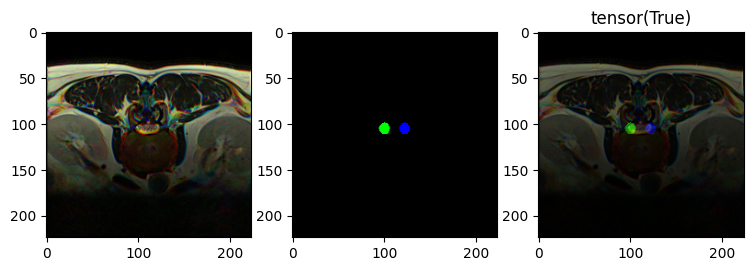

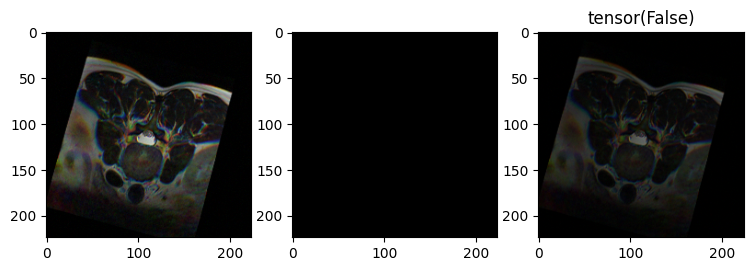

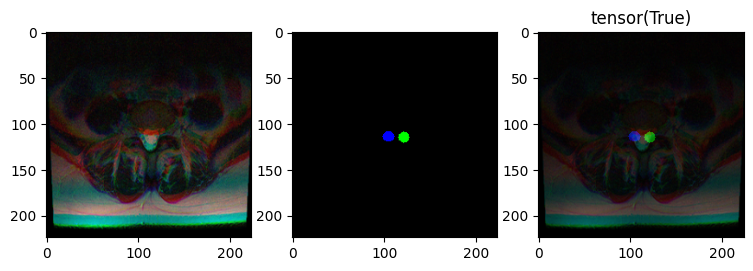

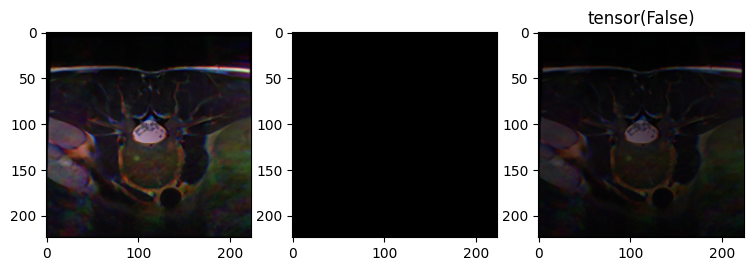

In [ ]:
for data in loader_show:
    imgs = data['image']
    masks = data['mask']
    label = data['label']
    weight = data['weight']
    obj = data['object']
    # label_l1_l2 = data['label_l1_l2']
    # label_l2_l3 = data['label_l2_l3']
    # label_l3_l4 = data['label_l3_l4']
    # label_l4_l5 = data['label_l4_l5']
    # label_l5_s1 = data['label_l5_s1']
    for p in range(4):
        plt.figure(figsize=(9,3))
        plt.subplot(1,3,1)
        plt.imshow(imgs[p].permute(1, 2, 0)[...,0:3])
        plt.subplot(1,3,2)
        mask = masks[p].permute(1, 2, 0)
        zero_mask = np.zeros_like(mask[...,0])[...,np.newaxis]
        mask = np.concatenate([zero_mask, mask], axis=-1)
        plt.imshow(mask)
        plt.subplot(1,3,3)
        plt.title(obj[p])
        plt.imshow(imgs[p].permute(1, 2, 0)[...,0:3])
        plt.imshow(mask, alpha=0.5)
    break
print(imgs.shape, masks.shape)

In [ ]:
zero_mask.shape, mask.shape

((224, 224, 1), (224, 224, 3))

In [ ]:
weight

tensor([1., 1., 1., 1., 1., 1., 2., 4., 1., 1., 4., 1., 1., 1., 1., 1., 1., 1.,
        2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 4., 1.],
       dtype=torch.float64)

In [ ]:
df_lc[df_lc['study_id']==3867046855]

,study_id,series_id,instance_number,condition,level,x,y,height,width,height_space,width_space,x_new,y_new
43758,3867046855,35950467,8,Spinal Canal Stenosis,L1/L2,269.167975,225.054945,512,512,0.5273,0.5273,134,112
43759,3867046855,35950467,8,Spinal Canal Stenosis,L2/L3,251.485086,280.514914,512,512,0.5273,0.5273,125,140
43760,3867046855,35950467,8,Spinal Canal Stenosis,L3/L4,235.409733,329.544741,512,512,0.5273,0.5273,117,164
43761,3867046855,35950467,8,Spinal Canal Stenosis,L4/L5,236.953947,379.368421,512,512,0.5273,0.5273,118,189
43762,3867046855,35950467,8,Spinal Canal Stenosis,L5/S1,249.229167,417.333333,512,512,0.5273,0.5273,124,208
43763,3867046855,524901572,5,Right Neural Foraminal Narrowing,L1/L2,262.625882,215.943529,512,512,0.5273,0.5273,131,107
43764,3867046855,524901572,5,Right Neural Foraminal Narrowing,L2/L3,246.964706,268.348235,512,512,0.5273,0.5273,123,134
43765,3867046855,524901572,5,Right Neural Foraminal Narrowing,L3/L4,229.496471,320.752941,512,512,0.5273,0.5273,114,160
43766,3867046855,524901572,5,Right Neural Foraminal Narrowing,L4/L5,222.268235,371.952941,512,512,0.5273,0.5273,111,185
43767,3867046855,524901572,5,Right Neural Foraminal Narrowing,L5/S1,232.508235,415.924706,512,512,0.5273,0.5273,116,207


# Model

In [ ]:
def init_layer(layer):
    nn.init.xavier_uniform_(layer.weight)

    if hasattr(layer, "bias"):
        if layer.bias is not None:
            layer.bias.data.fill_(0.)


def init_bn(bn):
    bn.bias.data.fill_(0.)
    bn.weight.data.fill_(1.0)


def init_weights(model):
    classname = model.__class__.__name__
    if classname.find("Conv2d") != -1:
        nn.init.xavier_uniform_(model.weight, gain=np.sqrt(2))
        model.bias.data.fill_(0)
    elif classname.find("BatchNorm") != -1:
        model.weight.data.normal_(1.0, 0.02)
        model.bias.data.fill_(0)
    elif classname.find("GRU") != -1:
        for weight in model.parameters():
            if len(weight.size()) > 1:
                nn.init.orghogonal_(weight.data)
    elif classname.find("Linear") != -1:
        model.weight.data.normal_(0, 0.01)
        model.bias.data.zero_()

class AttBlockV2(nn.Module):
    def __init__(self,
                 in_features: int,
                 out_features: int,
                 activation="linear"):
        super().__init__()

        self.activation = activation
        self.att = nn.Conv1d(
            in_channels=in_features,
            out_channels=out_features,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=True)
        self.cla = nn.Conv1d(
            in_channels=in_features,
            out_channels=out_features,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=True)

        self.init_weights()

    def init_weights(self):
        init_layer(self.att)
        init_layer(self.cla)

    def forward(self, x):
        # x: (n_samples, n_in, n_time)
        norm_att = torch.softmax(torch.tanh(self.att(x)), dim=-1)
        cla = self.nonlinear_transform(self.cla(x))
        x = torch.sum(norm_att * cla, dim=2)
        return x, norm_att, cla

    def nonlinear_transform(self, x):
        if self.activation == 'linear':
            return x
        elif self.activation == 'sigmoid':
            return torch.sigmoid(x)

In [ ]:

class TimmModel(nn.Module):
    def __init__(self, backbone, pretrained=False):
        super(TimmModel, self).__init__()

        self.encoder = timm.create_model(
            backbone,
            in_chans=CFG.in_chans,
            num_classes=CFG.out_dim,
            features_only=False,
            drop_rate=CFG.drop_rate,
            drop_path_rate=CFG.drop_path_rate,
            pretrained=pretrained
        )

        if 'efficient' in backbone:
            hdim = self.encoder.conv_head.out_channels
            self.encoder.classifier = nn.Identity()
        elif 'convnext' in backbone:
            hdim = self.encoder.head.fc.in_features
            self.encoder.head.fc = nn.Identity()


        self.lstm = nn.LSTM(hdim, 256, num_layers=2, dropout=CFG.drop_rate, bidirectional=True, batch_first=True)
        self.att_block = AttBlockV2(
            512, CFG.out_dim, activation="sigmoid")
#         self.head = nn.Sequential(
#             nn.Linear(512, 256),
#             nn.BatchNorm1d(256),
#             nn.Dropout(CFG.drop_rate_last),
#             nn.LeakyReLU(0.1),
#             nn.Linear(256, CFG.out_dim),
#         )

    def forward(self, x):  # (bs, nslice, ch, sz, sz)
        bs = x.shape[0]
        x = x.view(bs * CFG.n_slice_axial, CFG.in_chans, CFG.image_size, CFG.image_size)
        feat = self.encoder(x)
        feat = feat.view(bs, CFG.n_slice_axial, -1)
        print(feat.shape)
        feat, _ = self.lstm(feat)
        print(feat.shape)
        feat = feat.transpose(1,2)
        #feat = feat.contiguous().view(bs * CFG.n_slice_axial, -1)
        #print(feat.shape)
        #feat = self.head(feat)
        feat, _, _ = self.att_block(feat)
        print(feat.shape)
#         feat = feat.view(bs, CFG.n_slice_axial).contiguous()
#         print(feat.shape)

        return feat

class TimmModelV1(nn.Module):
    def __init__(self, model_name, in_c=30, n_classes=75, pretrained=True, features_only=False):
        super().__init__()
        self.model = timm.create_model(
                                    model_name,
                                    pretrained=pretrained,
                                    features_only=features_only,
                                    in_chans=in_c,
                                    num_classes=n_classes,
                                    global_pool='avg'
                                    )

    def forward(self, x_sat1, x_sat2, x_axt2):
        x_sat1 = self.__reshape(x_sat1)
        x_sat2 = self.__reshape(x_sat2)
        x_axt2 = self.__reshape(x_axt2)
        x = torch.cat([x_sat1, x_sat2, x_axt2], dim=1)
        y = self.model(x)
        return y

    def __reshape(self, x):
        bs, n_slice, ch, h, w = x.shape
        x = x.reshape(bs, n_slice*ch, h, w)
        return x

class TimmMultiModelV1(nn.Module):
    def __init__(self, backbone, pretrained=False):
        super(TimmMultiModelV1, self).__init__()

        self.encoder_sagital = timm.create_model(
            backbone,
            in_chans=CFG.in_chans,
            num_classes=CFG.out_dim,
            features_only=False,
            drop_rate=CFG.drop_rate,
            drop_path_rate=CFG.drop_path_rate,
            pretrained=pretrained
        )

        if 'efficient' in backbone:
            hdim = self.encoder_sagital.conv_head.out_channels
            self.encoder_sagital.classifier = nn.Identity()
        elif 'convnext' in backbone:
            hdim = self.encoder_sagital.head.fc.in_features
            self.encoder_sagital.head.fc = nn.Identity()


        self.lstm_sagital = nn.LSTM(hdim, 256, num_layers=2, dropout=CFG.drop_rate, bidirectional=True, batch_first=True)


        self.encoder_axial = timm.create_model(
            backbone,
            in_chans=CFG.in_chans,
            num_classes=CFG.out_dim,
            features_only=False,
            drop_rate=CFG.drop_rate,
            drop_path_rate=CFG.drop_path_rate,
            pretrained=pretrained
        )

        if 'efficient' in backbone:
            hdim = self.encoder_axial.conv_head.out_channels
            self.encoder_axial.classifier = nn.Identity()
        elif 'convnext' in backbone:
            hdim = self.encoder_axial.head.fc.in_features
            self.encoder_axial.head.fc = nn.Identity()

        self.lstm_axial = nn.LSTM(hdim, 256, num_layers=2, dropout=CFG.drop_rate, bidirectional=True, batch_first=True)

        self.att_block = AttBlockV2(
            512, CFG.out_dim, activation="sigmoid")
#         self.head = nn.Sequential(
#             nn.Linear(1536, 256),
#             nn.BatchNorm1d(256),
#             nn.Dropout(CFG.drop_rate_last),
#             nn.LeakyReLU(0.1),
#             nn.Linear(256, out_dim),
#         )

    def forward(self, x_sat1, x_sat2, x_axt2):  # (bs, nslice, ch, sz, sz)
        bs = x_sat1.shape[0]
        x_sat1 = x_sat1.view(bs * CFG.n_slice_sagital, CFG.in_chans, CFG.image_size, CFG.image_size)
        feat_sat1 = self.encoder_sagital(x_sat1)
        feat_sat1 = feat_sat1.view(bs, CFG.n_slice_sagital, -1)
        feat_sat1, _ = self.lstm_sagital(feat_sat1)
        #feat_sat1 = feat_sat1.contiguous().view(bs * CFG.n_slice_sagital, -1)

        bs = x_sat2.shape[0]
        x_sat2 = x_sat2.view(bs * CFG.n_slice_sagital, CFG.in_chans, CFG.image_size, CFG.image_size)
        feat_sat2 = self.encoder_sagital(x_sat2)
        feat_sat2 = feat_sat2.view(bs, CFG.n_slice_sagital, -1)
        feat_sat2, _ = self.lstm_sagital(feat_sat2)
        #feat_sat2 = feat_sat2.contiguous().view(bs * CFG.n_slice_sagital, -1)

        bs = x_axt2.shape[0]
        x_axt2 = x_axt2.view(bs * CFG.n_slice_axial, CFG.in_chans, CFG.image_size, CFG.image_size)
        feat_axt2 = self.encoder_sagital(x_axt2)
        feat_axt2 = feat_axt2.view(bs, CFG.n_slice_axial, -1)
        feat_axt2, _ = self.lstm_axial(feat_axt2)
        #feat_axt2 = feat_axt2.contiguous().view(bs * CFG.n_slice_sagital, -1)

        feat = torch.cat([feat_sat1, feat_sat2, feat_axt2], dim=1)
        feat = feat.transpose(1,2)

        #feat = self.head(feat)
        feat, _, _ = self.att_block(feat)
        #feat = feat.view(bs, n_slice_per_c).contiguous()

        return feat

class TimmMultiModelV2(nn.Module):
    def __init__(self, backbone, pretrained=False):
        super(TimmMultiModelV2, self).__init__()

        self.encoder = timm.create_model(
            backbone,
            in_chans=CFG.in_chans,
            num_classes=CFG.out_dim,
            features_only=False,
            drop_rate=CFG.drop_rate,
            drop_path_rate=CFG.drop_path_rate,
            pretrained=pretrained
        )

        if 'efficient' in backbone:
            hdim = self.encoder.conv_head.out_channels
            self.encoder.classifier = nn.Identity()
        elif 'convnext' in backbone:
            hdim = self.encoder.head.fc.in_features
            self.encoder.head.fc = nn.Identity()


        self.lstm = nn.LSTM(hdim, 256, num_layers=2, dropout=CFG.drop_rate, bidirectional=True, batch_first=True)

        self.att_block = AttBlockV2(
            512, CFG.out_dim, activation="sigmoid")
#         self.head = nn.Sequential(
#             nn.Linear(1536, 256),
#             nn.BatchNorm1d(256),
#             nn.Dropout(CFG.drop_rate_last),
#             nn.LeakyReLU(0.1),
#             nn.Linear(256, out_dim),
#         )

    def forward(self, x_sat1, x_sat2, x_axt2):  # (bs, nslice, ch, sz, sz)
        bs = x_sat1.shape[0]
        x_sat1 = x_sat1.view(bs * CFG.n_slice_sagital, CFG.in_chans, CFG.image_size, CFG.image_size)
        feat_sat1 = self.encoder(x_sat1)
        feat_sat1 = feat_sat1.view(bs, CFG.n_slice_sagital, -1)
        feat_sat1, _ = self.lstm(feat_sat1)
        #feat_sat1 = feat_sat1.contiguous().view(bs * CFG.n_slice_sagital, -1)

        bs = x_sat2.shape[0]
        x_sat2 = x_sat2.view(bs * CFG.n_slice_sagital, CFG.in_chans, CFG.image_size, CFG.image_size)
        feat_sat2 = self.encoder(x_sat2)
        feat_sat2 = feat_sat2.view(bs, CFG.n_slice_sagital, -1)
        feat_sat2, _ = self.lstm(feat_sat2)
        #feat_sat2 = feat_sat2.contiguous().view(bs * CFG.n_slice_sagital, -1)

        bs = x_axt2.shape[0]
        x_axt2 = x_axt2.view(bs * CFG.n_slice_axial, CFG.in_chans, CFG.image_size, CFG.image_size)
        feat_axt2 = self.encoder(x_axt2)
        feat_axt2 = feat_axt2.view(bs, CFG.n_slice_axial, -1)
        feat_axt2, _ = self.lstm(feat_axt2)
        #feat_axt2 = feat_axt2.contiguous().view(bs * CFG.n_slice_sagital, -1)

        feat = torch.cat([feat_sat1, feat_sat2, feat_axt2], dim=1)
        feat = feat.transpose(1,2)

        #feat = self.head(feat)
        feat, _, _ = self.att_block(feat)
        #feat = feat.view(bs, n_slice_per_c).contiguous()

        return feat

class TimmMultiModelV3(nn.Module):
    def __init__(self, backbone, pretrained=False):
        super(TimmMultiModelV3, self).__init__()

        self.encoder_sagital = timm.create_model(
            backbone,
            in_chans=CFG.in_chans,
            num_classes=CFG.out_dim,
            features_only=False,
            drop_rate=CFG.drop_rate,
            drop_path_rate=CFG.drop_path_rate,
            pretrained=pretrained
        )

        if 'efficient' in backbone:
            hdim = self.encoder_sagital.conv_head.out_channels
            self.encoder_sagital.classifier = nn.Identity()
        elif 'convnext' in backbone:
            hdim = self.encoder_sagital.head.fc.in_features
            self.encoder_sagital.head.fc = nn.Identity()

        self.encoder_axial = timm.create_model(
            backbone,
            in_chans=CFG.in_chans,
            num_classes=CFG.out_dim,
            features_only=False,
            drop_rate=CFG.drop_rate,
            drop_path_rate=CFG.drop_path_rate,
            pretrained=pretrained
        )

        if 'efficient' in backbone:
            hdim = self.encoder_axial.conv_head.out_channels
            self.encoder_axial.classifier = nn.Identity()
        elif 'convnext' in backbone:
            hdim = self.encoder_axial.head.fc.in_features
            self.encoder_axial.head.fc = nn.Identity()

        self.att_block = AttBlockV2(
            hdim, CFG.out_dim, activation="sigmoid")
#         self.head = nn.Sequential(
#             nn.Linear(1536, 256),
#             nn.BatchNorm1d(256),
#             nn.Dropout(CFG.drop_rate_last),
#             nn.LeakyReLU(0.1),
#             nn.Linear(256, out_dim),
#         )

    def forward(self, x_sat1, x_sat2, x_axt2):  # (bs, nslice, ch, sz, sz)
        bs = x_sat1.shape[0]
        x_sat1 = x_sat1.view(bs * CFG.n_slice_sagital, CFG.in_chans, CFG.image_size, CFG.image_size)
        feat_sat1 = self.encoder_sagital(x_sat1)
        feat_sat1 = feat_sat1.view(bs, CFG.n_slice_sagital, -1)
        #feat_sat1 = feat_sat1.contiguous().view(bs * CFG.n_slice_sagital, -1)

        bs = x_sat2.shape[0]
        x_sat2 = x_sat2.view(bs * CFG.n_slice_sagital, CFG.in_chans, CFG.image_size, CFG.image_size)
        feat_sat2 = self.encoder_sagital(x_sat2)
        feat_sat2 = feat_sat2.view(bs, CFG.n_slice_sagital, -1)
        #feat_sat2 = feat_sat2.contiguous().view(bs * CFG.n_slice_sagital, -1)

        bs = x_axt2.shape[0]
        x_axt2 = x_axt2.view(bs * CFG.n_slice_axial, CFG.in_chans, CFG.image_size, CFG.image_size)
        feat_axt2 = self.encoder_sagital(x_axt2)
        feat_axt2 = feat_axt2.view(bs, CFG.n_slice_axial, -1)
        #feat_axt2 = feat_axt2.contiguous().view(bs * CFG.n_slice_sagital, -1)

        feat = torch.cat([feat_sat1, feat_sat2, feat_axt2], dim=1)
        feat = feat.transpose(1,2)

        #feat = self.head(feat)
        feat, _, _ = self.att_block(feat)
        #feat = feat.view(bs, n_slice_per_c).contiguous()

        return feat

class TimmMultiModelV4(nn.Module):
    def __init__(self, backbone, pretrained=False):
        super(TimmMultiModelV4, self).__init__()

        self.encoder_sagital = timm.create_model(
            backbone,
            in_chans=CFG.n_slice_sagital,
            num_classes=CFG.out_dim,
            features_only=False,
            drop_rate=CFG.drop_rate,
            drop_path_rate=CFG.drop_path_rate,
            pretrained=pretrained
        )

        if 'efficient' in backbone:
            hdim = self.encoder_sagital.conv_head.out_channels
            self.encoder_sagital.classifier = nn.Identity()
        elif 'convnext' in backbone:
            hdim = self.encoder_sagital.head.fc.in_features
            self.encoder_sagital.head.fc = nn.Identity()

        self.encoder_axial = timm.create_model(
            backbone,
            in_chans=CFG.n_slice_axial,
            num_classes=CFG.out_dim,
            features_only=False,
            drop_rate=CFG.drop_rate,
            drop_path_rate=CFG.drop_path_rate,
            pretrained=pretrained
        )

        if 'efficient' in backbone:
            hdim = self.encoder_axial.conv_head.out_channels
            self.encoder_axial.classifier = nn.Identity()
        elif 'convnext' in backbone:
            hdim = self.encoder_axial.head.fc.in_features
            self.encoder_axial.head.fc = nn.Identity()

        # self.att_block = AttBlockV2(
        #     hdim, CFG.out_dim, activation="sigmoid")
        self.head = nn.Sequential(
            # nn.Linear(hdim*3, 256),
            # nn.BatchNorm1d(256),
            nn.Dropout(CFG.drop_rate_last),
            # nn.LeakyReLU(0.1),
            nn.Linear(hdim*3, CFG.out_dim),
        )

    def __reshape(self, x):
        bs, n_slice, ch, h, w = x.shape
        x = x.reshape(bs, n_slice*ch, h, w)
        return x

    def forward(self, x_sat1, x_sat2, x_axt2):  # (bs, nslice, ch, sz, sz)
        bs = x_sat1.shape[0]
        x_sat1 = self.__reshape(x_sat1)
        feat_sat1 = self.encoder_sagital(x_sat1)
        feat_sat1 = feat_sat1.view(bs, -1)
        #feat_sat1 = feat_sat1.contiguous().view(bs * CFG.n_slice_sagital, -1)

        bs = x_sat2.shape[0]
        x_sat2 = self.__reshape(x_sat2)
        feat_sat2 = self.encoder_sagital(x_sat2)
        feat_sat2 = feat_sat2.view(bs, -1)
        #feat_sat2 = feat_sat2.contiguous().view(bs * CFG.n_slice_sagital, -1)

        bs = x_axt2.shape[0]
        x_axt2 = self.__reshape(x_axt2)
        feat_axt2 = self.encoder_axial(x_axt2)
        feat_axt2 = feat_axt2.view(bs,  -1)
        #feat_axt2 = feat_axt2.contiguous().view(bs * CFG.n_slice_sagital, -1)

        feat = torch.cat([feat_sat1, feat_sat2, feat_axt2], dim=1)
        feat = self.head(feat)
        return feat

class TimmMultiModelV5(nn.Module):
    def __init__(self, backbone, pretrained=False):
        super(TimmMultiModelV5, self).__init__()

        self.encoder_sagital1 = timm.create_model(
            backbone,
            in_chans=CFG.n_slice_sagital,
            num_classes=CFG.out_dim,
            features_only=False,
            drop_rate=CFG.drop_rate,
            drop_path_rate=CFG.drop_path_rate,
            pretrained=pretrained
        )

        if 'efficient' in backbone:
            hdim = self.encoder_sagital1.conv_head.out_channels
            self.encoder_sagital1.classifier = nn.Identity()
        elif 'convnext' in backbone:
            hdim = self.encoder_sagital1.head.fc.in_features
            self.encoder_sagital1.head.fc = nn.Identity()

        self.encoder_sagital2 = timm.create_model(
            backbone,
            in_chans=CFG.n_slice_sagital,
            num_classes=CFG.out_dim,
            features_only=False,
            drop_rate=CFG.drop_rate,
            drop_path_rate=CFG.drop_path_rate,
            pretrained=pretrained
        )

        if 'efficient' in backbone:
            hdim = self.encoder_sagital2.conv_head.out_channels
            self.encoder_sagital2.classifier = nn.Identity()
        elif 'convnext' in backbone:
            hdim = self.encoder_sagital2.head.fc.in_features
            self.encoder_sagital2.head.fc = nn.Identity()

        self.encoder_axial = timm.create_model(
            backbone,
            in_chans=CFG.n_slice_axial,
            num_classes=CFG.out_dim,
            features_only=False,
            drop_rate=CFG.drop_rate,
            drop_path_rate=CFG.drop_path_rate,
            pretrained=pretrained
        )

        if 'efficient' in backbone:
            hdim = self.encoder_axial.conv_head.out_channels
            self.encoder_axial.classifier = nn.Identity()
        elif 'convnext' in backbone:
            hdim = self.encoder_axial.head.fc.in_features
            self.encoder_axial.head.fc = nn.Identity()

        # self.att_block = AttBlockV2(
        #     hdim, CFG.out_dim, activation="sigmoid")
        self.head = nn.Sequential(
            # nn.Linear(hdim*3, 256),
            # nn.BatchNorm1d(256),
            #nn.Dropout(CFG.drop_rate_last),
            # nn.LeakyReLU(0.1),
            nn.Linear(hdim*3, CFG.out_dim),
        )

    def __reshape(self, x):
        bs, n_slice, ch, h, w = x.shape
        x = x.reshape(bs, n_slice*ch, h, w)
        return x

    def forward(self, x_sat1, x_sat2, x_axt2):  # (bs, nslice, ch, sz, sz)
        bs = x_sat1.shape[0]
        x_sat1 = self.__reshape(x_sat1)
        feat_sat1 = self.encoder_sagital1(x_sat1)
        feat_sat1 = feat_sat1.view(bs, -1)
        #feat_sat1 = feat_sat1.contiguous().view(bs * CFG.n_slice_sagital, -1)

        bs = x_sat2.shape[0]
        x_sat2 = self.__reshape(x_sat2)
        feat_sat2 = self.encoder_sagital2(x_sat2)
        feat_sat2 = feat_sat2.view(bs, -1)
        #feat_sat2 = feat_sat2.contiguous().view(bs * CFG.n_slice_sagital, -1)

        bs = x_axt2.shape[0]
        x_axt2 = self.__reshape(x_axt2)
        feat_axt2 = self.encoder_axial(x_axt2)
        feat_axt2 = feat_axt2.view(bs,  -1)
        #feat_axt2 = feat_axt2.contiguous().view(bs * CFG.n_slice_sagital, -1)

        feat = torch.cat([feat_sat1, feat_sat2, feat_axt2], dim=1)
        feat = self.head(feat)
        return feat

In [ ]:
class TimmSinglePlaneModel(nn.Module):
    def __init__(self, backbone, pretrained=False):
        super(TimmSinglePlaneModel, self).__init__()

        self.encoder = timm.create_model(
            backbone,
            in_chans=CFG.n_slice_axial,
            num_classes=CFG.out_dim,
            features_only=False,
            drop_rate=CFG.drop_rate,
            drop_path_rate=CFG.drop_path_rate,
            pretrained=pretrained
        )

        if 'efficient' in backbone:
            hdim = self.encoder.conv_head.out_channels
            self.encoder.classifier = nn.Identity()
        elif 'convnext' in backbone:
            hdim = self.encoder.head.fc.in_features
            self.encoder.head.fc = nn.Identity()

        self.head = nn.Sequential(
            # nn.Linear(hdim*3, 256),
            # nn.BatchNorm1d(256),
            #nn.Dropout(CFG.drop_rate_last),
            # nn.LeakyReLU(0.1),
            nn.Linear(hdim, CFG.out_dim),
        )

    def __reshape(self, x):
        bs, n_slice, ch, h, w = x.shape
        x = x.reshape(bs, n_slice*ch, h, w)
        return x

    def forward(self, x):  # (bs, nslice, ch, sz, sz)
        bs = x.shape[0]
        x = self.__reshape(x)
        feat = self.encoder(x)
        feat = feat.view(bs, -1)
        #feat_sat2 = feat_sat2.contiguous().view(bs * CFG.n_slice_sagital, -1)

        feat = self.head(feat)
        return feat

class TimmSingleModelV4(nn.Module):
    def __init__(self, backbone, pretrained=False):
        super(TimmSingleModelV4, self).__init__()

        self.encoder = timm.create_model(
            backbone,
            in_chans=CFG.in_chans,
            num_classes=CFG.out_dim,
            features_only=False,
            drop_rate=CFG.drop_rate,
            drop_path_rate=CFG.drop_path_rate,
            pretrained=pretrained
        )

        if 'efficient' in backbone:
            hdim = self.encoder.conv_head.out_channels
            self.encoder.classifier = nn.Identity()
        elif 'convnext' in backbone:
            hdim = self.encoder.head.fc.in_features
            self.encoder.head.fc = nn.Identity()


        #self.lstm = nn.LSTM(hdim, 256, num_layers=2, dropout=CFG.drop_rate, bidirectional=True, batch_first=True)
        self.rnn = nn.GRU(input_size=hdim, hidden_size=128, num_layers=1, bidirectional=True)

        # self.att_block = AttBlockV2(
        #     hdim, CFG.out_dim, activation="sigmoid")
        self.head = nn.Sequential(
            # nn.Linear(512, 256),
            # nn.BatchNorm1d(256),
            # nn.Dropout(CFG.drop_rate_last),
            # nn.LeakyReLU(0.1),
            nn.Linear(256, CFG.out_dim),
        )

    def forward(self, x):  # (bs, nslice, ch, sz, sz)
        bs = x.shape[0]
        x = x.view(bs * CFG.n_slice_axial, CFG.in_chans, CFG.image_size, CFG.image_size)
        feat = self.encoder(x)
        feat = feat.view(bs, CFG.n_slice_axial, -1)
        feat, _ = self.rnn(feat)
        feat_slice = feat.mean(2)
        feat = feat.mean(1)
        #feat_axt2 = feat_axt2.contiguous().view(bs * CFG.n_slice_sagital, -1)

        feat = self.head(feat)
        #feat = feat.transpose(1,2)
        #feat, _, _ = self.att_block(feat)
        #feat = feat.view(bs, n_slice_per_c).contiguous()

        return feat, feat_slice

class TimmSingleModelV5(nn.Module):
    def __init__(self, backbone, in_chans, out_chans, pretrained=False):
        super(TimmSingleModelV5, self).__init__()

        self.encoder = timm.create_model(
            backbone,
            in_chans=in_chans,
            num_classes=out_chans,
            features_only=False,
            drop_rate=CFG.drop_rate,
            drop_path_rate=CFG.drop_path_rate,
            pretrained=pretrained
        )

        if 'efficient' in backbone:
            hdim = self.encoder.conv_head.out_channels
            self.encoder.classifier = nn.Identity()
        elif 'convnext' in backbone:
            hdim = self.encoder.head.fc.in_features
            self.encoder.head.fc = nn.Identity()


        #self.lstm = nn.LSTM(hdim, 256, num_layers=2, dropout=CFG.drop_rate, bidirectional=True, batch_first=True)
        self.rnn = nn.GRU(input_size=hdim, hidden_size=128, num_layers=1, bidirectional=True)

        # self.att_block = AttBlockV2(
        #     hdim, CFG.out_dim, activation="sigmoid")
        self.head_binary = nn.Linear(256, 5)
        self.head = nn.Sequential(
            # nn.Linear(512, 256),
            # nn.BatchNorm1d(256),
            # nn.Dropout(CFG.drop_rate_last),
            # nn.LeakyReLU(0.1),
            nn.Linear(256, out_chans),
        )

    def forward(self, x):  # (bs, nslice, ch, sz, sz)
        bs, n_slice = x.shape[:2]
        x = x.view(bs * n_slice, CFG.in_chans, CFG.image_size, CFG.image_size)
        feat = self.encoder(x)
        feat = feat.view(bs, n_slice, -1)
        feat, _ = self.rnn(feat)
        feat = feat.view(bs*n_slice, -1)
        feat_binary = self.head_binary(feat)
        feat_binary = feat_binary.view(bs, n_slice, -1)
        feat = self.head(feat)
        feat = feat.view(bs, n_slice, -1)
        #feat = feat.mean(1)
        #feat_axt2 = feat_axt2.contiguous().view(bs * CFG.n_slice_sagital, -1)

        #feat = self.head(feat)
        #feat = feat.transpose(1,2)
        #feat, _, _ = self.att_block(feat)
        #feat = feat.view(bs, n_slice_per_c).contiguous()

        return feat, feat_binary

class TimmSingleModelV6(nn.Module):
    def __init__(self, backbone, in_chans, out_chans, pretrained=False):
        super(TimmSingleModelV6, self).__init__()

        self.encoder = timm.create_model(
            backbone,
            in_chans=in_chans,
            num_classes=out_chans,
            features_only=False,
            drop_rate=CFG.drop_rate,
            drop_path_rate=CFG.drop_path_rate,
            pretrained=pretrained
        )

        if 'efficient' in backbone:
            hdim = self.encoder.conv_head.out_channels
            self.encoder.classifier = nn.Identity()
        elif 'convnext' in backbone:
            hdim = self.encoder.head.fc.in_features
            self.encoder.head.fc = nn.Identity()


        #self.lstm = nn.LSTM(hdim, 256, num_layers=2, dropout=CFG.drop_rate, bidirectional=True, batch_first=True)
        self.rnn = nn.GRU(input_size=hdim, hidden_size=128, num_layers=1, bidirectional=True)

        # self.att_block = AttBlockV2(
        #     hdim, CFG.out_dim, activation="sigmoid")
        self.head_binary = nn.Linear(256, 5)
        self.head_slice = nn.Sequential(
            # nn.Linear(512, 256),
            # nn.BatchNorm1d(256),
            # nn.Dropout(CFG.drop_rate_last),
            # nn.LeakyReLU(0.1),
            nn.Linear(256, out_chans),
        )
        self.head = nn.Sequential(
            # nn.Linear(512, 256),
            # nn.BatchNorm1d(256),
            # nn.Dropout(CFG.drop_rate_last),
            # nn.LeakyReLU(0.1),
            nn.Linear(256, out_chans),
        )

    def forward(self, x):  # (bs, nslice, ch, sz, sz)
        bs, n_slice = x.shape[:2]
        x = x.view(bs * n_slice, CFG.in_chans, CFG.image_size, CFG.image_size)
        feat = self.encoder(x)
        feat = feat.view(bs, n_slice, -1)
        feat, _ = self.rnn(feat)
        feat = feat.view(bs*n_slice, -1)
        feat_binary = self.head_binary(feat)
        feat_binary = feat_binary.view(bs, n_slice, -1)
        feat_slice = self.head_slice(feat)
        feat_slice = feat_slice.view(bs, n_slice, -1)
        feat = feat.view(bs, n_slice, -1)
        feat = feat.mean(1)
        feat = self.head(feat)
        #feat_axt2 = feat_axt2.contiguous().view(bs * CFG.n_slice_sagital, -1)

        #feat = self.head(feat)
        #feat = feat.transpose(1,2)
        #feat, _, _ = self.att_block(feat)
        #feat = feat.view(bs, n_slice_per_c).contiguous()

        return feat, feat_slice, feat_binary

class TimmSingleModelV6_1(nn.Module):
    def __init__(self, backbone, in_chans, out_chans, pretrained=False):
        super(TimmSingleModelV6_1, self).__init__()

        self.encoder = timm.create_model(
            backbone,
            in_chans=in_chans,
            num_classes=out_chans,
            features_only=False,
            drop_rate=CFG.drop_rate,
            drop_path_rate=CFG.drop_path_rate,
            pretrained=pretrained
        )

        if 'efficient' in backbone:
            hdim = self.encoder.conv_head.out_channels
            self.encoder.classifier = nn.Identity()
        elif 'convnext' in backbone:
            hdim = self.encoder.head.fc.in_features
            self.encoder.head.fc = nn.Identity()


        #self.lstm = nn.LSTM(hdim, 256, num_layers=2, dropout=CFG.drop_rate, bidirectional=True, batch_first=True)
        self.rnn = nn.GRU(input_size=hdim, hidden_size=128, num_layers=1, bidirectional=True)

        # self.att_block = AttBlockV2(
        #     hdim, CFG.out_dim, activation="sigmoid")
        self.head_binary = nn.Linear(256, 5)
        self.head_slice = nn.Sequential(
            # nn.Linear(512, 256),
            # nn.BatchNorm1d(256),
            # nn.Dropout(CFG.drop_rate_last),
            # nn.LeakyReLU(0.1),
            nn.Linear(256, 3),
        )
        self.head = nn.Sequential(
            # nn.Linear(512, 256),
            # nn.BatchNorm1d(256),
            # nn.Dropout(CFG.drop_rate_last),
            # nn.LeakyReLU(0.1),
            nn.Linear(256, out_chans),
        )

    def forward(self, x):  # (bs, nslice, ch, sz, sz)
        bs, n_slice = x.shape[:2]
        x = x.view(bs * n_slice, CFG.in_chans, CFG.image_size, CFG.image_size)
        feat = self.encoder(x)
        feat = feat.view(bs, n_slice, -1)
        feat, _ = self.rnn(feat)
        feat = feat.view(bs*n_slice, -1)
        feat_binary = self.head_binary(feat)
        feat_binary = feat_binary.view(bs, n_slice, -1)
        feat_slice = self.head_slice(feat)
        feat_slice = feat_slice.view(bs, n_slice, -1)
        feat = feat.view(bs, n_slice, -1)
        feat = feat.mean(1)
        feat = self.head(feat)
        #feat_axt2 = feat_axt2.contiguous().view(bs * CFG.n_slice_sagital, -1)

        #feat = self.head(feat)
        #feat = feat.transpose(1,2)
        #feat, _, _ = self.att_block(feat)
        #feat = feat.view(bs, n_slice_per_c).contiguous()

        return feat, feat_slice, feat_binary

class TimmSimpleModel(nn.Module):
    def __init__(self, backbone, in_chans, out_chans, pretrained=False):
        super(TimmSimpleModel, self).__init__()

        self.encoder = timm.create_model(
            backbone,
            in_chans=in_chans,
            num_classes=out_chans,
            features_only=False,
            drop_rate=CFG.drop_rate,
            drop_path_rate=CFG.drop_path_rate,
            pretrained=pretrained
        )

        if 'efficient' in backbone:
            hdim = self.encoder.conv_head.out_channels
            self.encoder.classifier = nn.Identity()
        elif 'convnext' in backbone:
            hdim = self.encoder.head.fc.in_features
            self.encoder.head.fc = nn.Identity()

        self.head = nn.Sequential(
            # nn.Linear(512, 256),
            # nn.BatchNorm1d(256),
            # nn.Dropout(CFG.drop_rate_last),
            # nn.LeakyReLU(0.1),
            nn.Linear(hdim, out_chans),
        )

    def forward(self, x):  # (bs, nslice, ch, sz, sz)
        x = self.encoder(x)
        x = self.head(x)
        #feat_axt2 = feat_axt2.contiguous().view(bs * CFG.n_slice_sagital, -1)

        #feat = self.head(feat)
        #feat = feat.transpose(1,2)
        #feat, _, _ = self.att_block(feat)
        #feat = feat.view(bs, n_slice_per_c).contiguous()

        return x

class TimmSimpleModelV2(nn.Module):
    def __init__(self, backbone, split, in_chans, out_chans, pretrained=False):
        super(TimmSimpleModelV2, self).__init__()

        self.encoder = timm.create_model(
            backbone,
            in_chans=in_chans,
            num_classes=out_chans,
            features_only=False,
            drop_rate=CFG.drop_rate,
            drop_path_rate=CFG.drop_path_rate,
            pretrained=pretrained
        )
        self.split = split

        if 'efficient' in backbone:
            hdim = self.encoder.conv_head.out_channels
            self.encoder.classifier = nn.Identity()
        elif 'convnext' in backbone:
            hdim = self.encoder.head.fc.in_features
            self.encoder.head.fc = nn.Identity()

        self.rnn = nn.GRU(input_size=hdim, hidden_size=128, num_layers=1, bidirectional=True)

        self.head = nn.Sequential(
            # nn.Linear(512, 256),
            # nn.BatchNorm1d(256),
            # nn.Dropout(CFG.drop_rate_last),
            # nn.LeakyReLU(0.1),
            nn.Linear(256, out_chans),
        )

    def __reshape(self, x, n):
        bs, c, h, w = x.shape
        x = x.view(bs, n, c//n, h, w)
        return x

    def forward(self, x):  # (bs, nslice, ch, sz, sz)
        bs, c, h, w = x.shape
        n = self.split
        x = self.__reshape(x, n)
        x = x.view(bs*n, c//n, h, w)
        x = self.encoder(x)
        x = x.view(bs, n, -1)
        x, _ = self.rnn(x)
        x = x.mean(1)
        x = self.head(x)
        #feat_axt2 = feat_axt2.contiguous().view(bs * CFG.n_slice_sagital, -1)

        #feat = self.head(feat)
        #feat = feat.transpose(1,2)
        #feat, _, _ = self.att_block(feat)
        #feat = feat.view(bs, n_slice_per_c).contiguous()

        return x

class TimmSimpleModelV3(nn.Module):
    def __init__(self, backbone, split, in_chans, out_chans, pretrained=False):
        super(TimmSimpleModelV3, self).__init__()

        self.encoder = timm.create_model(
            backbone,
            in_chans=in_chans,
            num_classes=out_chans,
            features_only=False,
            drop_rate=CFG.drop_rate,
            drop_path_rate=CFG.drop_path_rate,
            pretrained=pretrained
        )
        self.split = split

        if 'efficient' in backbone:
            hdim = self.encoder.conv_head.out_channels
            self.encoder.classifier = nn.Identity()
        elif 'convnext' in backbone:
            hdim = self.encoder.head.fc.in_features
            self.encoder.head.fc = nn.Identity()

        self.conv1d = nn.Conv1d(in_channels=hdim, out_channels=out_chans, kernel_size=split)

        # self.head = nn.Sequential(
        #     # nn.Linear(512, 256),
        #     # nn.BatchNorm1d(256),
        #     # nn.Dropout(CFG.drop_rate_last),
        #     # nn.LeakyReLU(0.1),
        #     nn.Linear(256, out_chans),
        # )

    def __reshape(self, x, n):
        bs, c, h, w = x.shape
        x = x.view(bs, n, c//n, h, w)
        return x

    def forward(self, x):  # (bs, nslice, ch, sz, sz)
        bs, c, h, w = x.shape
        n = self.split
        x = self.__reshape(x, n)
        x = x.view(bs*n, c//n, h, w)
        x = self.encoder(x)
        x = x.view(bs, n, -1)
        x = x.transpose(1,2)
        x = self.conv1d(x)
        x = x.squeeze()
        #x = self.head(x)
        #feat_axt2 = feat_axt2.contiguous().view(bs * CFG.n_slice_sagital, -1)

        #feat = self.head(feat)
        #feat = feat.transpose(1,2)
        #feat, _, _ = self.att_block(feat)
        #feat = feat.view(bs, n_slice_per_c).contiguous()

        return x


In [ ]:
m = smp.Unet(encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
            in_channels=CFG.in_chans,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
            classes=5,        # model output channels (number of classes in your dataset)
            activation=None,
            )
out = m(imgs)
out.shape

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 406MB/s]


torch.Size([32, 5, 224, 224])

# Loss & Metric

In [ ]:
def criterion(logits, targets, activated=False):
    bce = nn.BCEWithLogitsLoss(reduction='none')
    if activated:
        losses = nn.BCELoss(reduction='none')(logits.view(-1), targets.view(-1))
    else:
        losses = bce(logits.view(-1), targets.view(-1))
    losses[targets.view(-1) > 0] *= 2.
    norm = torch.ones(logits.view(-1).shape[0]).to(device)
    norm[targets.view(-1) > 0] *= 2
    return losses.sum() / norm.sum()

def criterion_multi(logits, targets, weights):
    ce = nn.CrossEntropyLoss(weight=weights.to(device))
    losses = 0
    for col in range(CFG.num_targets):
        pred = logits[:,col*3:col*3+3]
        gt = targets[:,col]
        losses = losses + ce(pred, gt) / CFG.num_targets
    return losses

def criterion_aux(logits, targets):
    bce = nn.BCEWithLogitsLoss(reduction='none')
    losses = bce(logits, targets)
    return losses.mean()

def criterion_multi_aux(logits, logits_aux,
                        targets_l1_l2, targets_l2_l3,
                        targets_l3_l4, targets_l4_l5,
                        targets_l5_s1, targets_aux,
                        weights):
    bce = nn.BCEWithLogitsLoss(reduction='none')
    ce = nn.CrossEntropyLoss(reduction='none', weight=weights)
    losses_aux = bce(logits_aux, targets_aux)
    losses = 0

    for col in range(len(CFG.targets_l1_l2)):
        pred = logits[:,:,col*3:col*3+3]
        bs, n_slice = pred.shape[:2]
        pred = pred.view(bs*n_slice, -1)
        gt = targets_l1_l2[:,col]
        gt = gt.repeat_interleave(n_slice)
        losses_main = ce(pred, gt)
        loss = losses_main * targets_aux[:,:,0:1].view(-1)/ len(CFG.targets_l1_l2)
        losses = losses + loss.mean()

    for col in range(len(CFG.targets_l2_l3)):
        pred = logits[:,:,col*3:col*3+3]
        bs, n_slice = pred.shape[:2]
        pred = pred.view(bs*n_slice, -1)
        gt = targets_l2_l3[:,col]
        gt = gt.repeat_interleave(n_slice)
        losses_main = ce(pred, gt)
        loss = losses_main * targets_aux[:,:,1:2].view(-1)/ len(CFG.targets_l2_l3)
        losses = losses + loss.mean()

    for col in range(len(CFG.targets_l3_l4)):
        pred = logits[:,:,col*3:col*3+3]
        bs, n_slice = pred.shape[:2]
        pred = pred.view(bs*n_slice, -1)
        gt = targets_l3_l4[:,col]
        gt = gt.repeat_interleave(n_slice)
        losses_main = ce(pred, gt)
        loss = losses_main * targets_aux[:,:,2:3].view(-1)/ len(CFG.targets_l3_l4)
        losses = losses + loss.mean()

    for col in range(len(CFG.targets_l4_l5)):
        pred = logits[:,:,col*3:col*3+3]
        bs, n_slice = pred.shape[:2]
        pred = pred.view(bs*n_slice, -1)
        gt = targets_l4_l5[:,col]
        gt = gt.repeat_interleave(n_slice)
        losses_main = ce(pred, gt)
        loss = losses_main * targets_aux[:,:,3:4].view(-1)/ len(CFG.targets_l4_l5)
        losses = losses + loss.mean()

    for col in range(len(CFG.targets_l5_s1)):
        pred = logits[:,:,col*3:col*3+3]
        bs, n_slice = pred.shape[:2]
        pred = pred.view(bs*n_slice, -1)
        gt = targets_l5_s1[:,col]
        gt = gt.repeat_interleave(n_slice)
        losses_main = ce(pred, gt)
        loss = losses_main * targets_aux[:,:,4:5].view(-1)/ len(CFG.targets_l5_s1)
        losses = losses + loss.mean()

    return losses, losses_aux.mean()

def criterion_multi_aux_v2(logits, logits_aux,
                        targets, targets_aux,
                        weights):
    bce = nn.BCEWithLogitsLoss(reduction='none')
    ce = nn.CrossEntropyLoss(reduction='none', weight=weights)
    losses_aux = bce(logits_aux, targets_aux)
    losses = 0

    for i, colname in enumerate(CFG.targets):
        pred = logits[:,:,i*3:i*3+3]
        bs, n_slice = pred.shape[:2]
        pred = pred.view(bs*n_slice, -1)
        gt = targets[:,i]
        gt = gt.repeat_interleave(n_slice)
        losses_main = ce(pred, gt)
        if '_l1_l2' in colname:
            loss = losses_main * targets_aux[:,:,0:1].view(-1)/ len(CFG.targets)
        elif '_l2_l3' in colname:
            loss = losses_main * targets_aux[:,:,1:2].view(-1)/ len(CFG.targets)
        elif '_l3_l4' in colname:
            loss = losses_main * targets_aux[:,:,2:3].view(-1)/ len(CFG.targets)
        elif '_l4_l5' in colname:
            loss = losses_main * targets_aux[:,:,3:4].view(-1)/ len(CFG.targets)
        elif '_l5_s1' in colname:
            loss = losses_main * targets_aux[:,:,4:5].view(-1)/ len(CFG.targets)
        else:
            assert False
        losses = losses + loss.mean()

    return losses, losses_aux.mean()

def criterion_multi_aux_v3(logits, logits_aux,
                        targets, targets_aux,
                        weights):
    bce = nn.BCEWithLogitsLoss(reduction='none')
    ce = nn.CrossEntropyLoss(reduction='none', weight=weights)
    losses_aux = bce(logits_aux, targets_aux)
    losses = 0

    for i, colname in enumerate(CFG.targets):
        pred = logits
        bs, n_slice = pred.shape[:2]
        pred = pred.view(bs*n_slice, -1)
        gt = targets[:,i]
        gt = gt.repeat_interleave(n_slice)
        losses_main = ce(pred, gt)
        if '_l1_l2' in colname:
            loss = losses_main * targets_aux[:,:,0:1].view(-1)/ len(CFG.targets)
        elif '_l2_l3' in colname:
            loss = losses_main * targets_aux[:,:,1:2].view(-1)/ len(CFG.targets)
        elif '_l3_l4' in colname:
            loss = losses_main * targets_aux[:,:,2:3].view(-1)/ len(CFG.targets)
        elif '_l4_l5' in colname:
            loss = losses_main * targets_aux[:,:,3:4].view(-1)/ len(CFG.targets)
        elif '_l5_s1' in colname:
            loss = losses_main * targets_aux[:,:,4:5].view(-1)/ len(CFG.targets)
        else:
            assert False
        losses = losses + loss.mean()

    return losses, losses_aux.mean()

In [ ]:
# criterion_multi(out.to('cpu'), label.to('cpu'),
#                     weights = torch.tensor([1.0, 2.0, 4.0]).to('cpu')
#                     )

In [ ]:
JaccardLoss = smp.losses.JaccardLoss(mode='multilabel')
DiceLoss    = smp.losses.DiceLoss(mode='multilabel')
BCELoss     = smp.losses.SoftBCEWithLogitsLoss()
LovaszLoss  = smp.losses.LovaszLoss(mode='multilabel', per_image=False)
TverskyLoss = smp.losses.TverskyLoss(mode='multilabel', log_loss=False)
FocalLoss = smp.losses.FocalLoss(mode='multilabel')

def criterion_seg(y_pred, y_true):
    # bs, n, c, h, w = y_true.shape[:2]
    # y_pred = y_pred.view(bs*n, c, h, w)
    # y_true = y_true.view(bs*n, c, h, w)
    bce = BCELoss(y_pred, y_true)
    tvs = TverskyLoss(y_pred, y_true)
    return (bce * 0.95) + (tvs* 0.05), bce, tvs

def batch_wise_loss(loss_fn, outputs, targets, weights):
    batch_losses = []
    batch_losses_bce = []
    batch_losses_tvs = []

    for i in range(outputs.size(0)):  # バッチサイズごとにループ
        loss, bce, tvs = loss_fn(outputs[i:i+1], targets[i:i+1])
        batch_losses.append(loss * weights[i])
        batch_losses_bce.append(bce * weights[i])
        batch_losses_tvs.append(tvs * weights[i])
    loss = torch.stack(batch_losses).mean()
    loss_bce = torch.stack(batch_losses_bce).mean()
    loss_tvs = torch.stack(batch_losses_tvs).mean()
    return loss, loss_bce, loss_tvs

# Train & Valid func

In [ ]:
def mixup(input, mask, truth, clip=[0, 1]):
    indices = torch.randperm(input.size(0))
    shuffled_input = input[indices]
    shuffled_mask = mask[indices]
    shuffled_labels = truth[indices]

    lam = np.random.uniform(clip[0], clip[1])
    input = input * lam + shuffled_input * (1 - lam)
    return input, mask, truth, shuffled_mask, shuffled_labels, lam


def train_func(model, loader_train, optimizer, epoch, scaler=None):
    model.train()
    train_loss = []
    bar = tqdm(loader_train)
    for data in bar:
        optimizer.zero_grad()
        images = data['image']
        masks = data['mask']
        targets = data['label']
        weights = data['weight']
        images = images.cuda()
        masks = masks.cuda()
        weights = weights.cuda()
        targets = targets.cuda()

        do_mixup = False
        if (random.random() < CFG.p_mixup)&(CFG.n_epochs_mixup>epoch):
            do_mixup = True
            images, masks, targets, masks_mix, targets_mix, lam = mixup(images, masks, targets)

        with amp.autocast():
            #logits = model(images_sat1, images_sat2, images_axt2)
            logits = model(images)
            loss, _, _ = batch_wise_loss(criterion_seg, logits, masks, weights)
            if do_mixup:
                loss11, _, _ = batch_wise_loss(criterion_seg, logits, masks_mix, weights)
                loss = loss * lam  + loss11 * (1 - lam)
        train_loss.append(loss.item())
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        bar.set_description(f'smth:{np.mean(train_loss[-30:]):.4f}')

    return np.mean(train_loss)


def valid_func(model, loader_valid):
    model.eval()
    valid_loss, valid_loss_bce, valid_loss_tvs = [], [], []
    gts = []
    outputs = []
    bar = tqdm(loader_valid)
    with torch.no_grad():
        for data in bar:
            images = data['image']
            masks = data['mask']
            weights = data['weight']
            targets = data['label']
            images = images.cuda()
            masks = masks.cuda()
            weights = weights.cuda()
            targets = targets.cuda()

            #logits = model(images_sat1, images_sat2, images_axt2)
            logits = model(images)
            loss, loss_bce, loss_tvs = batch_wise_loss(criterion_seg, logits, masks, weights)

            gts.append(masks)
            outputs.append(logits)
            valid_loss.append(loss.item())
            valid_loss_bce.append(loss_bce.item())
            valid_loss_tvs.append(loss_tvs.item())

            bar.set_description(f'smth:{np.mean(valid_loss[-30:]):.4f}')

    outputs = torch.cat(outputs)
    gts = torch.cat(gts)
    valid_loss, valid_loss_bce, valid_loss_tvs = criterion_seg(outputs, gts)

    return valid_loss.item(), valid_loss_bce.item(), valid_loss_tvs.item()


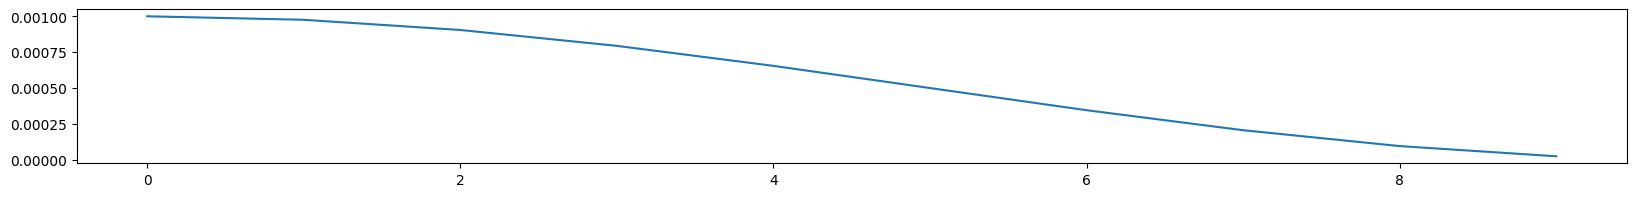

In [ ]:
rcParams['figure.figsize'] = 20, 2
optimizer = optim.AdamW(m.parameters(), lr=1e-3)
scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, CFG.n_epochs, T_mult=1, eta_min=CFG.eta_min)

lrs = []
for epoch in range(1, CFG.n_epochs+1):
    scheduler_cosine.step(epoch-1)
    lrs.append(optimizer.param_groups[0]["lr"])
plt.plot(range(len(lrs)), lrs)

# Training

In [ ]:
def run(fold):

    log_file = os.path.join(CFG.log_dir, f'{CFG.kernel_type}.txt')
    model_file = os.path.join(CFG.model_dir, f'{CFG.kernel_type}_fold{fold}_best.pth')

    train_ = df_lc_axt2_all[df_lc_axt2_all['fold'] != fold].reset_index(drop=True)
    valid_ = df_lc_axt2_all[df_lc_axt2_all['fold'] == fold].reset_index(drop=True)
    dataset_train = RSNADatasetAxt2(df, train_, df_sd,
                                CFG.indices_ch, CFG.mid_range,
                                'train', transform=transforms_train
                               )
    dataset_valid = RSNADatasetAxt2(df, valid_, df_sd,
                                CFG.indices_ch, CFG.mid_range,
                                'valid', transform=transforms_valid
                               )
    weights = [0.5 / 0.75 if label == 1 else 0.5 / 0.25 for label in train_['object']]
    sampler = WeightedRandomSampler(weights, num_samples=len(train_), replacement=True)
    loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=CFG.batch_size, sampler=sampler, shuffle=False, num_workers=CFG.num_workers, drop_last=True)
    loader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=CFG.batch_size, shuffle=False, num_workers=CFG.num_workers)

    #model = TimmSimpleModelV2(CFG.backbone, split=5, in_chans=CFG.in_chans, out_chans=CFG.out_dim, pretrained=True)
    #model = TimmModelV1(CFG.backbone, in_c=int(CFG.n_slice_axial+CFG.n_slice_sagital*2), n_classes=CFG.out_dim, pretrained=True)
    model = smp.Unet(encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
                     in_channels=CFG.in_chans,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
                     classes=2,        # model output channels (number of classes in your dataset)
                     activation=None,
                     )
    model = model.to(device)

    optimizer = optim.AdamW(model.parameters(), lr=CFG.init_lr)
    scaler = torch.cuda.amp.GradScaler() if CFG.use_amp else None

    metric_best = np.inf
    loss_min = np.inf

    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, CFG.n_epochs, eta_min=CFG.eta_min)

    print(len(dataset_train), len(dataset_valid))

    for epoch in range(1, CFG.n_epochs+1):
        scheduler_cosine.step(epoch-1)

        print(time.ctime(), 'Epoch:', epoch)

        train_loss = train_func(model, loader_train, optimizer, epoch, scaler)
        valid_loss, valid_loss_bce, valid_loss_tvs = valid_func(model, loader_valid)
        metric = valid_loss_tvs

        content = time.ctime() + ' ' + f'Fold {fold}, Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, train loss: {train_loss:.5f}, valid loss: {valid_loss:.5f}\n\
        , valid loss bce: {valid_loss_bce:.5f}, valid loss tvs: {valid_loss_tvs:.5f}, metric: {(metric):.6f}.'
        print(content)
        with open(log_file, 'a') as appender:
            appender.write(content + '\n')

        if metric < metric_best:
            print(f'metric_best ({metric_best:.6f} --> {metric:.6f}). Saving model ...')
#             if not DEBUG:
            torch.save(model.state_dict(), model_file)
            metric_best = metric

        # Save Last
        if not DEBUG:
            torch.save(
                {
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scaler_state_dict': scaler.state_dict() if scaler else None,
                    'score_best': metric_best,
                },
                model_file.replace('_best', '_last')
            )

    del model
    torch.cuda.empty_cache()
    gc.collect()
    return metric_best

def run_valid(fold):

    valid_ = df_lc_axt2[df_lc_axt2['fold'] == fold].reset_index(drop=True)
    dataset_valid = RSNADatasetV11(df, valid_, df_sd,
                                CFG.indices_ch, CFG.mid_range,
                                'valid', transform=transforms_valid
                               )
    loader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=CFG.batch_size, shuffle=False, num_workers=CFG.num_workers)

    model = TimmSimpleModelV3(CFG.backbone, split=5, in_chans=CFG.in_chans, out_chans=CFG.out_dim, pretrained=True)
    model_file = os.path.join(CFG.model_dir, f'{CFG.kernel_type}_fold{fold}_best.pth')
    model.load_state_dict(torch.load(model_file))
    #model = TimmModelV1(CFG.backbone, in_c=int(CFG.n_slice_axial+CFG.n_slice_sagital*2), n_classes=CFG.out_dim, pretrained=True)
    model = model.to(device)

    valid_loss = valid_func(model, loader_valid)
    metric = valid_loss

    content = time.ctime() + ' ' + f'Fold {fold}, valid loss: {valid_loss:.5f}, metric: {(metric):.6f}.'
    print(content)

    del model
    torch.cuda.empty_cache()
    gc.collect()

In [ ]:
RUN_TRAIN = True
if RUN_TRAIN:
    folds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    best_scores = []
    for i in folds:
        best_score = run(i)
        best_scores.append(best_score)

<ipython-input-55-b0d4c64971ba>:31: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if CFG.use_amp else None


1975 1975
Wed Oct  2 03:04:47 2024 Epoch: 1


  0%|          | 0/1756 [00:00<?, ?it/s]<ipython-input-53-e090de34bd5f>:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
smth:0.0151: 100%|██████████| 62/62 [00:10<00:00,  5.97it/s]


Wed Oct  2 03:15:30 2024 Fold 0, Epoch 1, lr: 0.0010000, train loss: 0.02683, valid loss: 0.02984
        , valid loss bce: 0.00173, valid loss tvs: 0.56381, metric: 0.563807.
metric_best (inf --> 0.563807). Saving model ...
Wed Oct  2 03:15:31 2024 Epoch: 2


smth:0.0134: 100%|██████████| 62/62 [00:08<00:00,  7.35it/s]


Wed Oct  2 03:25:59 2024 Fold 0, Epoch 2, lr: 0.0009755, train loss: 0.01438, valid loss: 0.02673
        , valid loss bce: 0.00184, valid loss tvs: 0.49967, metric: 0.499675.
metric_best (0.563807 --> 0.499675). Saving model ...
Wed Oct  2 03:25:59 2024 Epoch: 3


smth:0.0134: 100%|██████████| 62/62 [00:07<00:00,  7.99it/s]


Wed Oct  2 03:36:27 2024 Fold 0, Epoch 3, lr: 0.0009045, train loss: 0.01394, valid loss: 0.02734
        , valid loss bce: 0.00177, valid loss tvs: 0.51307, metric: 0.513072.
Wed Oct  2 03:36:27 2024 Epoch: 4


smth:0.0126: 100%|██████████| 62/62 [00:08<00:00,  7.15it/s]


Wed Oct  2 03:46:58 2024 Fold 0, Epoch 4, lr: 0.0007939, train loss: 0.01350, valid loss: 0.02583
        , valid loss bce: 0.00160, valid loss tvs: 0.48634, metric: 0.486343.
metric_best (0.499675 --> 0.486343). Saving model ...
Wed Oct  2 03:46:58 2024 Epoch: 5


smth:0.0119: 100%|██████████| 62/62 [00:07<00:00,  7.94it/s]


Wed Oct  2 03:57:27 2024 Fold 0, Epoch 5, lr: 0.0006545, train loss: 0.01323, valid loss: 0.02323
        , valid loss bce: 0.00140, valid loss tvs: 0.43816, metric: 0.438159.
metric_best (0.486343 --> 0.438159). Saving model ...
Wed Oct  2 03:57:28 2024 Epoch: 6


smth:0.0116: 100%|██████████| 62/62 [00:07<00:00,  7.95it/s]


Wed Oct  2 04:07:54 2024 Fold 0, Epoch 6, lr: 0.0005000, train loss: 0.01312, valid loss: 0.02344
        , valid loss bce: 0.00146, valid loss tvs: 0.44097, metric: 0.440973.
Wed Oct  2 04:07:54 2024 Epoch: 7


smth:0.0117: 100%|██████████| 62/62 [00:08<00:00,  7.54it/s]


Wed Oct  2 04:18:28 2024 Fold 0, Epoch 7, lr: 0.0003456, train loss: 0.01294, valid loss: 0.02288
        , valid loss bce: 0.00150, valid loss tvs: 0.42924, metric: 0.429240.
metric_best (0.438159 --> 0.429240). Saving model ...
Wed Oct  2 04:18:29 2024 Epoch: 8


smth:0.0115: 100%|██████████| 62/62 [00:08<00:00,  7.44it/s]


Wed Oct  2 04:28:53 2024 Fold 0, Epoch 8, lr: 0.0002062, train loss: 0.01269, valid loss: 0.02199
        , valid loss bce: 0.00145, valid loss tvs: 0.41231, metric: 0.412308.
metric_best (0.429240 --> 0.412308). Saving model ...
Wed Oct  2 04:28:54 2024 Epoch: 9


smth:0.0113: 100%|██████████| 62/62 [00:08<00:00,  7.28it/s]


Wed Oct  2 04:38:40 2024 Fold 0, Epoch 9, lr: 0.0000956, train loss: 0.01013, valid loss: 0.02200
        , valid loss bce: 0.00149, valid loss tvs: 0.41173, metric: 0.411727.
metric_best (0.412308 --> 0.411727). Saving model ...
Wed Oct  2 04:38:41 2024 Epoch: 10


smth:0.0111: 100%|██████████| 62/62 [00:08<00:00,  7.49it/s]


Wed Oct  2 04:48:29 2024 Fold 0, Epoch 10, lr: 0.0000246, train loss: 0.00998, valid loss: 0.02141
        , valid loss bce: 0.00146, valid loss tvs: 0.40062, metric: 0.400616.
metric_best (0.411727 --> 0.400616). Saving model ...
1975 1975
Wed Oct  2 04:48:30 2024 Epoch: 1


smth:0.0163: 100%|██████████| 62/62 [00:08<00:00,  7.53it/s]


Wed Oct  2 04:59:01 2024 Fold 1, Epoch 1, lr: 0.0010000, train loss: 0.03239, valid loss: 0.02925
        , valid loss bce: 0.00192, valid loss tvs: 0.54849, metric: 0.548495.
metric_best (inf --> 0.548495). Saving model ...
Wed Oct  2 04:59:02 2024 Epoch: 2


smth:0.0144: 100%|██████████| 62/62 [00:07<00:00,  7.89it/s]


Wed Oct  2 05:09:32 2024 Fold 1, Epoch 2, lr: 0.0009755, train loss: 0.01436, valid loss: 0.02595
        , valid loss bce: 0.00182, valid loss tvs: 0.48451, metric: 0.484506.
metric_best (0.548495 --> 0.484506). Saving model ...
Wed Oct  2 05:09:33 2024 Epoch: 3


smth:0.0141: 100%|██████████| 62/62 [00:07<00:00,  7.85it/s]


Wed Oct  2 05:20:06 2024 Fold 1, Epoch 3, lr: 0.0009045, train loss: 0.01364, valid loss: 0.02470
        , valid loss bce: 0.00167, valid loss tvs: 0.46228, metric: 0.462279.
metric_best (0.484506 --> 0.462279). Saving model ...
Wed Oct  2 05:20:07 2024 Epoch: 4


smth:0.0146: 100%|██████████| 62/62 [00:07<00:00,  7.87it/s]


Wed Oct  2 05:30:37 2024 Fold 1, Epoch 4, lr: 0.0007939, train loss: 0.01346, valid loss: 0.02510
        , valid loss bce: 0.00171, valid loss tvs: 0.46948, metric: 0.469482.
Wed Oct  2 05:30:37 2024 Epoch: 5


smth:0.0145: 100%|██████████| 62/62 [00:08<00:00,  7.68it/s]


Wed Oct  2 05:41:08 2024 Fold 1, Epoch 5, lr: 0.0006545, train loss: 0.01331, valid loss: 0.02485
        , valid loss bce: 0.00173, valid loss tvs: 0.46420, metric: 0.464196.
Wed Oct  2 05:41:08 2024 Epoch: 6


smth:0.0134: 100%|██████████| 62/62 [00:07<00:00,  8.08it/s]


Wed Oct  2 05:51:48 2024 Fold 1, Epoch 6, lr: 0.0005000, train loss: 0.01310, valid loss: 0.02444
        , valid loss bce: 0.00177, valid loss tvs: 0.45518, metric: 0.455177.
metric_best (0.462279 --> 0.455177). Saving model ...
Wed Oct  2 05:51:48 2024 Epoch: 7


smth:0.0133: 100%|██████████| 62/62 [00:07<00:00,  7.88it/s]


Wed Oct  2 06:02:23 2024 Fold 1, Epoch 7, lr: 0.0003456, train loss: 0.01288, valid loss: 0.02351
        , valid loss bce: 0.00159, valid loss tvs: 0.44001, metric: 0.440006.
metric_best (0.455177 --> 0.440006). Saving model ...
Wed Oct  2 06:02:24 2024 Epoch: 8


smth:0.0134: 100%|██████████| 62/62 [00:07<00:00,  7.93it/s]


Wed Oct  2 06:12:57 2024 Fold 1, Epoch 8, lr: 0.0002062, train loss: 0.01273, valid loss: 0.02272
        , valid loss bce: 0.00155, valid loss tvs: 0.42502, metric: 0.425015.
metric_best (0.440006 --> 0.425015). Saving model ...
Wed Oct  2 06:12:58 2024 Epoch: 9


smth:0.0130: 100%|██████████| 62/62 [00:08<00:00,  7.42it/s]


Wed Oct  2 06:22:53 2024 Fold 1, Epoch 9, lr: 0.0000956, train loss: 0.01010, valid loss: 0.02165
        , valid loss bce: 0.00161, valid loss tvs: 0.40254, metric: 0.402541.
metric_best (0.425015 --> 0.402541). Saving model ...
Wed Oct  2 06:22:54 2024 Epoch: 10


smth:0.0130: 100%|██████████| 62/62 [00:08<00:00,  7.38it/s]


Wed Oct  2 06:32:44 2024 Fold 1, Epoch 10, lr: 0.0000246, train loss: 0.00994, valid loss: 0.02161
        , valid loss bce: 0.00160, valid loss tvs: 0.40168, metric: 0.401677.
metric_best (0.402541 --> 0.401677). Saving model ...
1975 1975
Wed Oct  2 06:32:45 2024 Epoch: 1


smth:0.0183: 100%|██████████| 62/62 [00:07<00:00,  7.82it/s]


Wed Oct  2 06:43:27 2024 Fold 2, Epoch 1, lr: 0.0010000, train loss: 0.02628, valid loss: 0.02972
        , valid loss bce: 0.00217, valid loss tvs: 0.55309, metric: 0.553093.
metric_best (inf --> 0.553093). Saving model ...
Wed Oct  2 06:43:28 2024 Epoch: 2


smth:0.0167: 100%|██████████| 62/62 [00:08<00:00,  7.66it/s]


Wed Oct  2 06:54:11 2024 Fold 2, Epoch 2, lr: 0.0009755, train loss: 0.01413, valid loss: 0.02439
        , valid loss bce: 0.00166, valid loss tvs: 0.45620, metric: 0.456202.
metric_best (0.553093 --> 0.456202). Saving model ...
Wed Oct  2 06:54:12 2024 Epoch: 3


smth:0.0161: 100%|██████████| 62/62 [00:07<00:00,  8.14it/s]


Wed Oct  2 07:04:46 2024 Fold 2, Epoch 3, lr: 0.0009045, train loss: 0.01364, valid loss: 0.02457
        , valid loss bce: 0.00163, valid loss tvs: 0.46047, metric: 0.460471.
Wed Oct  2 07:04:47 2024 Epoch: 4


smth:0.0174: 100%|██████████| 62/62 [00:07<00:00,  7.92it/s]


Wed Oct  2 07:15:24 2024 Fold 2, Epoch 4, lr: 0.0007939, train loss: 0.01338, valid loss: 0.02564
        , valid loss bce: 0.00179, valid loss tvs: 0.47874, metric: 0.478745.
Wed Oct  2 07:15:24 2024 Epoch: 5


smth:0.0164: 100%|██████████| 62/62 [00:07<00:00,  8.01it/s]


Wed Oct  2 07:26:01 2024 Fold 2, Epoch 5, lr: 0.0006545, train loss: 0.01322, valid loss: 0.02485
        , valid loss bce: 0.00163, valid loss tvs: 0.46606, metric: 0.466065.
Wed Oct  2 07:26:02 2024 Epoch: 6


smth:0.0150: 100%|██████████| 62/62 [00:07<00:00,  7.79it/s]


Wed Oct  2 07:36:45 2024 Fold 2, Epoch 6, lr: 0.0005000, train loss: 0.01288, valid loss: 0.02299
        , valid loss bce: 0.00152, valid loss tvs: 0.43083, metric: 0.430831.
metric_best (0.456202 --> 0.430831). Saving model ...
Wed Oct  2 07:36:45 2024 Epoch: 7


smth:0.0158: 100%|██████████| 62/62 [00:08<00:00,  7.33it/s]


Wed Oct  2 07:47:26 2024 Fold 2, Epoch 7, lr: 0.0003456, train loss: 0.01264, valid loss: 0.02469
        , valid loss bce: 0.00176, valid loss tvs: 0.46039, metric: 0.460386.
Wed Oct  2 07:47:26 2024 Epoch: 8


smth:0.0149: 100%|██████████| 62/62 [00:07<00:00,  7.98it/s]


Wed Oct  2 07:58:09 2024 Fold 2, Epoch 8, lr: 0.0002062, train loss: 0.01261, valid loss: 0.02297
        , valid loss bce: 0.00154, valid loss tvs: 0.43003, metric: 0.430033.
metric_best (0.430831 --> 0.430033). Saving model ...
Wed Oct  2 07:58:09 2024 Epoch: 9


smth:0.0144: 100%|██████████| 62/62 [00:08<00:00,  7.74it/s]


Wed Oct  2 08:08:15 2024 Fold 2, Epoch 9, lr: 0.0000956, train loss: 0.00994, valid loss: 0.02174
        , valid loss bce: 0.00166, valid loss tvs: 0.40326, metric: 0.403258.
metric_best (0.430033 --> 0.403258). Saving model ...
Wed Oct  2 08:08:16 2024 Epoch: 10


smth:0.0144: 100%|██████████| 62/62 [00:08<00:00,  7.29it/s]


Wed Oct  2 08:18:18 2024 Fold 2, Epoch 10, lr: 0.0000246, train loss: 0.00998, valid loss: 0.02184
        , valid loss bce: 0.00167, valid loss tvs: 0.40506, metric: 0.405064.
1975 1975
Wed Oct  2 08:18:19 2024 Epoch: 1


smth:0.0172: 100%|██████████| 62/62 [00:08<00:00,  7.45it/s]


Wed Oct  2 08:28:55 2024 Fold 3, Epoch 1, lr: 0.0010000, train loss: 0.02542, valid loss: 0.02938
        , valid loss bce: 0.00180, valid loss tvs: 0.55323, metric: 0.553234.
metric_best (inf --> 0.553234). Saving model ...
Wed Oct  2 08:28:56 2024 Epoch: 2


smth:0.0148: 100%|██████████| 62/62 [00:08<00:00,  7.50it/s]


Wed Oct  2 08:39:38 2024 Fold 3, Epoch 2, lr: 0.0009755, train loss: 0.01428, valid loss: 0.02513
        , valid loss bce: 0.00178, valid loss tvs: 0.46879, metric: 0.468787.
metric_best (0.553234 --> 0.468787). Saving model ...
Wed Oct  2 08:39:38 2024 Epoch: 3


smth:0.0142: 100%|██████████| 62/62 [00:07<00:00,  8.00it/s]


Wed Oct  2 08:50:18 2024 Fold 3, Epoch 3, lr: 0.0009045, train loss: 0.01347, valid loss: 0.02376
        , valid loss bce: 0.00159, valid loss tvs: 0.44494, metric: 0.444938.
metric_best (0.468787 --> 0.444938). Saving model ...
Wed Oct  2 08:50:19 2024 Epoch: 4


smth:0.0140: 100%|██████████| 62/62 [00:08<00:00,  7.60it/s]


Wed Oct  2 09:00:56 2024 Fold 3, Epoch 4, lr: 0.0007939, train loss: 0.01353, valid loss: 0.02386
        , valid loss bce: 0.00162, valid loss tvs: 0.44637, metric: 0.446370.
Wed Oct  2 09:00:57 2024 Epoch: 5


smth:0.0142: 100%|██████████| 62/62 [00:07<00:00,  7.83it/s]


Wed Oct  2 09:11:37 2024 Fold 3, Epoch 5, lr: 0.0006545, train loss: 0.01322, valid loss: 0.02351
        , valid loss bce: 0.00155, valid loss tvs: 0.44079, metric: 0.440788.
metric_best (0.444938 --> 0.440788). Saving model ...
Wed Oct  2 09:11:37 2024 Epoch: 6


smth:0.0145: 100%|██████████| 62/62 [00:07<00:00,  7.88it/s]


Wed Oct  2 09:22:16 2024 Fold 3, Epoch 6, lr: 0.0005000, train loss: 0.01294, valid loss: 0.02411
        , valid loss bce: 0.00159, valid loss tvs: 0.45211, metric: 0.452107.
Wed Oct  2 09:22:16 2024 Epoch: 7


smth:0.0135: 100%|██████████| 62/62 [00:07<00:00,  7.84it/s]


Wed Oct  2 09:32:58 2024 Fold 3, Epoch 7, lr: 0.0003456, train loss: 0.01292, valid loss: 0.02260
        , valid loss bce: 0.00150, valid loss tvs: 0.42361, metric: 0.423611.
metric_best (0.440788 --> 0.423611). Saving model ...
Wed Oct  2 09:32:58 2024 Epoch: 8


smth:0.0136: 100%|██████████| 62/62 [00:08<00:00,  7.66it/s]


Wed Oct  2 09:43:37 2024 Fold 3, Epoch 8, lr: 0.0002062, train loss: 0.01264, valid loss: 0.02194
        , valid loss bce: 0.00145, valid loss tvs: 0.41132, metric: 0.411321.
metric_best (0.423611 --> 0.411321). Saving model ...
Wed Oct  2 09:43:38 2024 Epoch: 9


smth:0.0130: 100%|██████████| 62/62 [00:08<00:00,  7.53it/s]


Wed Oct  2 09:53:37 2024 Fold 3, Epoch 9, lr: 0.0000956, train loss: 0.01007, valid loss: 0.02089
        , valid loss bce: 0.00149, valid loss tvs: 0.38946, metric: 0.389457.
metric_best (0.411321 --> 0.389457). Saving model ...
Wed Oct  2 09:53:37 2024 Epoch: 10


smth:0.0133: 100%|██████████| 62/62 [00:07<00:00,  8.03it/s]


Wed Oct  2 10:03:34 2024 Fold 3, Epoch 10, lr: 0.0000246, train loss: 0.00982, valid loss: 0.02116
        , valid loss bce: 0.00153, valid loss tvs: 0.39430, metric: 0.394300.
1975 1975
Wed Oct  2 10:03:35 2024 Epoch: 1


smth:0.0166: 100%|██████████| 62/62 [00:08<00:00,  7.21it/s]


Wed Oct  2 10:14:10 2024 Fold 4, Epoch 1, lr: 0.0010000, train loss: 0.02885, valid loss: 0.02729
        , valid loss bce: 0.00209, valid loss tvs: 0.50616, metric: 0.506164.
metric_best (inf --> 0.506164). Saving model ...
Wed Oct  2 10:14:10 2024 Epoch: 2


smth:0.0160: 100%|██████████| 62/62 [00:08<00:00,  7.33it/s]


Wed Oct  2 10:24:42 2024 Fold 4, Epoch 2, lr: 0.0009755, train loss: 0.01431, valid loss: 0.02563
        , valid loss bce: 0.00190, valid loss tvs: 0.47648, metric: 0.476481.
metric_best (0.506164 --> 0.476481). Saving model ...
Wed Oct  2 10:24:43 2024 Epoch: 3


smth:0.0160: 100%|██████████| 62/62 [00:07<00:00,  7.97it/s]


Wed Oct  2 10:35:12 2024 Fold 4, Epoch 3, lr: 0.0009045, train loss: 0.01369, valid loss: 0.02472
        , valid loss bce: 0.00167, valid loss tvs: 0.46257, metric: 0.462569.
metric_best (0.476481 --> 0.462569). Saving model ...
Wed Oct  2 10:35:13 2024 Epoch: 4


smth:0.0162: 100%|██████████| 62/62 [00:07<00:00,  7.91it/s]


Wed Oct  2 10:45:43 2024 Fold 4, Epoch 4, lr: 0.0007939, train loss: 0.01340, valid loss: 0.02466
        , valid loss bce: 0.00166, valid loss tvs: 0.46165, metric: 0.461654.
metric_best (0.462569 --> 0.461654). Saving model ...
Wed Oct  2 10:45:44 2024 Epoch: 5


smth:0.0150: 100%|██████████| 62/62 [00:08<00:00,  7.66it/s]


Wed Oct  2 10:56:12 2024 Fold 4, Epoch 5, lr: 0.0006545, train loss: 0.01322, valid loss: 0.02447
        , valid loss bce: 0.00181, valid loss tvs: 0.45507, metric: 0.455071.
metric_best (0.461654 --> 0.455071). Saving model ...
Wed Oct  2 10:56:13 2024 Epoch: 6


smth:0.0156: 100%|██████████| 62/62 [00:08<00:00,  7.36it/s]


Wed Oct  2 11:06:42 2024 Fold 4, Epoch 6, lr: 0.0005000, train loss: 0.01319, valid loss: 0.02304
        , valid loss bce: 0.00170, valid loss tvs: 0.42845, metric: 0.428448.
metric_best (0.455071 --> 0.428448). Saving model ...
Wed Oct  2 11:06:43 2024 Epoch: 7


smth:0.0147: 100%|██████████| 62/62 [00:07<00:00,  8.01it/s]


Wed Oct  2 11:17:14 2024 Fold 4, Epoch 7, lr: 0.0003456, train loss: 0.01283, valid loss: 0.02273
        , valid loss bce: 0.00157, valid loss tvs: 0.42487, metric: 0.424873.
metric_best (0.428448 --> 0.424873). Saving model ...
Wed Oct  2 11:17:14 2024 Epoch: 8


smth:0.0153: 100%|██████████| 62/62 [00:08<00:00,  7.29it/s]


Wed Oct  2 11:28:14 2024 Fold 4, Epoch 8, lr: 0.0002062, train loss: 0.01268, valid loss: 0.02304
        , valid loss bce: 0.00158, valid loss tvs: 0.43072, metric: 0.430718.
Wed Oct  2 11:28:14 2024 Epoch: 9


smth:0.0148: 100%|██████████| 62/62 [00:08<00:00,  7.28it/s]


Wed Oct  2 11:38:36 2024 Fold 4, Epoch 9, lr: 0.0000956, train loss: 0.01002, valid loss: 0.02218
        , valid loss bce: 0.00165, valid loss tvs: 0.41231, metric: 0.412305.
metric_best (0.424873 --> 0.412305). Saving model ...
Wed Oct  2 11:38:37 2024 Epoch: 10


smth:0.0144: 100%|██████████| 62/62 [00:08<00:00,  7.15it/s]


Wed Oct  2 11:49:00 2024 Fold 4, Epoch 10, lr: 0.0000246, train loss: 0.00989, valid loss: 0.02152
        , valid loss bce: 0.00163, valid loss tvs: 0.39951, metric: 0.399508.
metric_best (0.412305 --> 0.399508). Saving model ...
1975 1975
Wed Oct  2 11:49:01 2024 Epoch: 1


smth:0.0174: 100%|██████████| 62/62 [00:08<00:00,  7.42it/s]


Wed Oct  2 12:00:04 2024 Fold 5, Epoch 1, lr: 0.0010000, train loss: 0.02828, valid loss: 0.02970
        , valid loss bce: 0.00198, valid loss tvs: 0.55625, metric: 0.556246.
metric_best (inf --> 0.556246). Saving model ...
Wed Oct  2 12:00:05 2024 Epoch: 2


smth:0.0144: 100%|██████████| 62/62 [00:08<00:00,  7.63it/s]


Wed Oct  2 12:10:58 2024 Fold 5, Epoch 2, lr: 0.0009755, train loss: 0.01410, valid loss: 0.02397
        , valid loss bce: 0.00165, valid loss tvs: 0.44812, metric: 0.448122.
metric_best (0.556246 --> 0.448122). Saving model ...
Wed Oct  2 12:10:59 2024 Epoch: 3


smth:0.0152: 100%|██████████| 62/62 [00:08<00:00,  7.09it/s]


Wed Oct  2 12:21:40 2024 Fold 5, Epoch 3, lr: 0.0009045, train loss: 0.01360, valid loss: 0.02598
        , valid loss bce: 0.00185, valid loss tvs: 0.48457, metric: 0.484571.
Wed Oct  2 12:21:41 2024 Epoch: 4


smth:0.0139: 100%|██████████| 62/62 [00:07<00:00,  7.87it/s]


Wed Oct  2 12:32:28 2024 Fold 5, Epoch 4, lr: 0.0007939, train loss: 0.01337, valid loss: 0.02297
        , valid loss bce: 0.00159, valid loss tvs: 0.42927, metric: 0.429265.
metric_best (0.448122 --> 0.429265). Saving model ...
Wed Oct  2 12:32:29 2024 Epoch: 5


smth:0.0140: 100%|██████████| 62/62 [00:07<00:00,  7.98it/s]


Wed Oct  2 12:43:02 2024 Fold 5, Epoch 5, lr: 0.0006545, train loss: 0.01335, valid loss: 0.02394
        , valid loss bce: 0.00157, valid loss tvs: 0.44890, metric: 0.448898.
Wed Oct  2 12:43:03 2024 Epoch: 6


smth:0.0144: 100%|██████████| 62/62 [00:07<00:00,  7.79it/s]


Wed Oct  2 12:53:25 2024 Fold 5, Epoch 6, lr: 0.0005000, train loss: 0.01298, valid loss: 0.02360
        , valid loss bce: 0.00166, valid loss tvs: 0.44060, metric: 0.440596.
Wed Oct  2 12:53:26 2024 Epoch: 7


smth:0.0135: 100%|██████████| 62/62 [00:08<00:00,  7.47it/s]


Wed Oct  2 13:04:23 2024 Fold 5, Epoch 7, lr: 0.0003456, train loss: 0.01288, valid loss: 0.02187
        , valid loss bce: 0.00151, valid loss tvs: 0.40885, metric: 0.408851.
metric_best (0.429265 --> 0.408851). Saving model ...
Wed Oct  2 13:04:24 2024 Epoch: 8


smth:0.0136: 100%|██████████| 62/62 [00:08<00:00,  7.54it/s]


Wed Oct  2 13:15:23 2024 Fold 5, Epoch 8, lr: 0.0002062, train loss: 0.01281, valid loss: 0.02191
        , valid loss bce: 0.00150, valid loss tvs: 0.40966, metric: 0.409662.
Wed Oct  2 13:15:24 2024 Epoch: 9


smth:0.0133: 100%|██████████| 62/62 [00:07<00:00,  7.77it/s]


Wed Oct  2 13:25:44 2024 Fold 5, Epoch 9, lr: 0.0000956, train loss: 0.01006, valid loss: 0.02086
        , valid loss bce: 0.00158, valid loss tvs: 0.38711, metric: 0.387112.
metric_best (0.408851 --> 0.387112). Saving model ...
Wed Oct  2 13:25:45 2024 Epoch: 10


smth:0.0130: 100%|██████████| 62/62 [00:08<00:00,  7.17it/s]


Wed Oct  2 13:36:25 2024 Fold 5, Epoch 10, lr: 0.0000246, train loss: 0.00989, valid loss: 0.02061
        , valid loss bce: 0.00156, valid loss tvs: 0.38254, metric: 0.382538.
metric_best (0.387112 --> 0.382538). Saving model ...
1975 1975
Wed Oct  2 13:36:27 2024 Epoch: 1


smth:0.0199: 100%|██████████| 62/62 [00:08<00:00,  7.13it/s]


Wed Oct  2 13:48:13 2024 Fold 6, Epoch 1, lr: 0.0010000, train loss: 0.02734, valid loss: 0.02928
        , valid loss bce: 0.00206, valid loss tvs: 0.54639, metric: 0.546386.
metric_best (inf --> 0.546386). Saving model ...
Wed Oct  2 13:48:14 2024 Epoch: 2


smth:0.0173: 100%|██████████| 62/62 [00:08<00:00,  7.53it/s]


Wed Oct  2 13:59:40 2024 Fold 6, Epoch 2, lr: 0.0009755, train loss: 0.01424, valid loss: 0.02672
        , valid loss bce: 0.00190, valid loss tvs: 0.49823, metric: 0.498225.
metric_best (0.546386 --> 0.498225). Saving model ...
Wed Oct  2 13:59:40 2024 Epoch: 3


smth:0.0165: 100%|██████████| 62/62 [00:08<00:00,  7.00it/s]


Wed Oct  2 14:10:46 2024 Fold 6, Epoch 3, lr: 0.0009045, train loss: 0.01380, valid loss: 0.02449
        , valid loss bce: 0.00165, valid loss tvs: 0.45845, metric: 0.458445.
metric_best (0.498225 --> 0.458445). Saving model ...
Wed Oct  2 14:10:46 2024 Epoch: 4


smth:0.0169: 100%|██████████| 62/62 [00:08<00:00,  7.48it/s]


Wed Oct  2 14:21:46 2024 Fold 6, Epoch 4, lr: 0.0007939, train loss: 0.01339, valid loss: 0.02507
        , valid loss bce: 0.00174, valid loss tvs: 0.46831, metric: 0.468314.
Wed Oct  2 14:21:47 2024 Epoch: 5


smth:0.0162: 100%|██████████| 62/62 [00:08<00:00,  7.41it/s]


Wed Oct  2 14:32:44 2024 Fold 6, Epoch 5, lr: 0.0006545, train loss: 0.01317, valid loss: 0.02345
        , valid loss bce: 0.00159, valid loss tvs: 0.43889, metric: 0.438891.
metric_best (0.458445 --> 0.438891). Saving model ...
Wed Oct  2 14:32:44 2024 Epoch: 6


smth:0.0164: 100%|██████████| 62/62 [00:08<00:00,  7.67it/s]


Wed Oct  2 14:43:35 2024 Fold 6, Epoch 6, lr: 0.0005000, train loss: 0.01299, valid loss: 0.02283
        , valid loss bce: 0.00162, valid loss tvs: 0.42579, metric: 0.425791.
metric_best (0.438891 --> 0.425791). Saving model ...
Wed Oct  2 14:43:36 2024 Epoch: 7


smth:0.0156: 100%|██████████| 62/62 [00:07<00:00,  7.93it/s]


Wed Oct  2 14:54:25 2024 Fold 6, Epoch 7, lr: 0.0003456, train loss: 0.01289, valid loss: 0.02260
        , valid loss bce: 0.00161, valid loss tvs: 0.42150, metric: 0.421499.
metric_best (0.425791 --> 0.421499). Saving model ...
Wed Oct  2 14:54:26 2024 Epoch: 8


smth:0.0154: 100%|██████████| 62/62 [00:08<00:00,  7.60it/s]


Wed Oct  2 15:05:08 2024 Fold 6, Epoch 8, lr: 0.0002062, train loss: 0.01258, valid loss: 0.02231
        , valid loss bce: 0.00154, valid loss tvs: 0.41708, metric: 0.417079.
metric_best (0.421499 --> 0.417079). Saving model ...
Wed Oct  2 15:05:09 2024 Epoch: 9


smth:0.0152: 100%|██████████| 62/62 [00:08<00:00,  7.49it/s]


Wed Oct  2 15:15:15 2024 Fold 6, Epoch 9, lr: 0.0000956, train loss: 0.00990, valid loss: 0.02095
        , valid loss bce: 0.00158, valid loss tvs: 0.38882, metric: 0.388816.
metric_best (0.417079 --> 0.388816). Saving model ...
Wed Oct  2 15:15:16 2024 Epoch: 10


smth:0.0150: 100%|██████████| 62/62 [00:08<00:00,  7.72it/s]


Wed Oct  2 15:25:20 2024 Fold 6, Epoch 10, lr: 0.0000246, train loss: 0.00993, valid loss: 0.02077
        , valid loss bce: 0.00158, valid loss tvs: 0.38533, metric: 0.385326.
metric_best (0.388816 --> 0.385326). Saving model ...
1975 1975
Wed Oct  2 15:25:21 2024 Epoch: 1


smth:0.0147: 100%|██████████| 62/62 [00:08<00:00,  7.49it/s]


Wed Oct  2 15:36:10 2024 Fold 7, Epoch 1, lr: 0.0010000, train loss: 0.02380, valid loss: 0.02730
        , valid loss bce: 0.00163, valid loss tvs: 0.51493, metric: 0.514928.
metric_best (inf --> 0.514928). Saving model ...
Wed Oct  2 15:36:11 2024 Epoch: 2


smth:0.0147: 100%|██████████| 62/62 [00:08<00:00,  7.40it/s]


Wed Oct  2 15:46:54 2024 Fold 7, Epoch 2, lr: 0.0009755, train loss: 0.01437, valid loss: 0.02701
        , valid loss bce: 0.00168, valid loss tvs: 0.50822, metric: 0.508221.
metric_best (0.514928 --> 0.508221). Saving model ...
Wed Oct  2 15:46:54 2024 Epoch: 3


smth:0.0151: 100%|██████████| 62/62 [00:08<00:00,  7.48it/s]


Wed Oct  2 15:57:42 2024 Fold 7, Epoch 3, lr: 0.0009045, train loss: 0.01392, valid loss: 0.02617
        , valid loss bce: 0.00166, valid loss tvs: 0.49185, metric: 0.491850.
metric_best (0.508221 --> 0.491850). Saving model ...
Wed Oct  2 15:57:43 2024 Epoch: 4


smth:0.0146: 100%|██████████| 62/62 [00:08<00:00,  7.60it/s]


Wed Oct  2 16:08:25 2024 Fold 7, Epoch 4, lr: 0.0007939, train loss: 0.01347, valid loss: 0.02717
        , valid loss bce: 0.00188, valid loss tvs: 0.50783, metric: 0.507825.
Wed Oct  2 16:08:26 2024 Epoch: 5


smth:0.0139: 100%|██████████| 62/62 [00:08<00:00,  7.67it/s]


Wed Oct  2 16:19:22 2024 Fold 7, Epoch 5, lr: 0.0006545, train loss: 0.01347, valid loss: 0.02578
        , valid loss bce: 0.00167, valid loss tvs: 0.48383, metric: 0.483834.
metric_best (0.491850 --> 0.483834). Saving model ...
Wed Oct  2 16:19:23 2024 Epoch: 6


smth:0.0134: 100%|██████████| 62/62 [00:08<00:00,  7.53it/s]


Wed Oct  2 16:30:04 2024 Fold 7, Epoch 6, lr: 0.0005000, train loss: 0.01300, valid loss: 0.02443
        , valid loss bce: 0.00158, valid loss tvs: 0.45865, metric: 0.458646.
metric_best (0.483834 --> 0.458646). Saving model ...
Wed Oct  2 16:30:05 2024 Epoch: 7


smth:0.0131: 100%|██████████| 62/62 [00:07<00:00,  7.88it/s]


Wed Oct  2 16:40:53 2024 Fold 7, Epoch 7, lr: 0.0003456, train loss: 0.01284, valid loss: 0.02297
        , valid loss bce: 0.00149, valid loss tvs: 0.43101, metric: 0.431008.
metric_best (0.458646 --> 0.431008). Saving model ...
Wed Oct  2 16:40:54 2024 Epoch: 8


smth:0.0135: 100%|██████████| 62/62 [00:08<00:00,  7.64it/s]


Wed Oct  2 16:51:44 2024 Fold 7, Epoch 8, lr: 0.0002062, train loss: 0.01272, valid loss: 0.02356
        , valid loss bce: 0.00158, valid loss tvs: 0.44108, metric: 0.441081.
Wed Oct  2 16:51:45 2024 Epoch: 9


smth:0.0133: 100%|██████████| 62/62 [00:08<00:00,  7.03it/s]


Wed Oct  2 17:01:56 2024 Fold 7, Epoch 9, lr: 0.0000956, train loss: 0.01012, valid loss: 0.02268
        , valid loss bce: 0.00163, valid loss tvs: 0.42257, metric: 0.422569.
metric_best (0.431008 --> 0.422569). Saving model ...
Wed Oct  2 17:01:56 2024 Epoch: 10


smth:0.0130: 100%|██████████| 62/62 [00:08<00:00,  7.03it/s]


Wed Oct  2 17:12:29 2024 Fold 7, Epoch 10, lr: 0.0000246, train loss: 0.00993, valid loss: 0.02210
        , valid loss bce: 0.00158, valid loss tvs: 0.41204, metric: 0.412044.
metric_best (0.422569 --> 0.412044). Saving model ...
1975 1975
Wed Oct  2 17:12:30 2024 Epoch: 1


smth:0.0202: 100%|██████████| 62/62 [00:09<00:00,  6.51it/s]


Wed Oct  2 17:24:18 2024 Fold 8, Epoch 1, lr: 0.0010000, train loss: 0.02494, valid loss: 0.02973
        , valid loss bce: 0.00198, valid loss tvs: 0.55693, metric: 0.556928.
metric_best (inf --> 0.556928). Saving model ...
Wed Oct  2 17:24:19 2024 Epoch: 2


smth:0.0178: 100%|██████████| 62/62 [00:08<00:00,  7.41it/s]


Wed Oct  2 17:35:58 2024 Fold 8, Epoch 2, lr: 0.0009755, train loss: 0.01427, valid loss: 0.02745
        , valid loss bce: 0.00189, valid loss tvs: 0.51327, metric: 0.513267.
metric_best (0.556928 --> 0.513267). Saving model ...
Wed Oct  2 17:35:58 2024 Epoch: 3


smth:0.0156: 100%|██████████| 62/62 [00:08<00:00,  7.17it/s]


Wed Oct  2 17:47:29 2024 Fold 8, Epoch 3, lr: 0.0009045, train loss: 0.01376, valid loss: 0.02365
        , valid loss bce: 0.00161, valid loss tvs: 0.44254, metric: 0.442538.
metric_best (0.513267 --> 0.442538). Saving model ...
Wed Oct  2 17:47:29 2024 Epoch: 4


smth:0.0160: 100%|██████████| 62/62 [00:08<00:00,  7.08it/s]


Wed Oct  2 17:58:38 2024 Fold 8, Epoch 4, lr: 0.0007939, train loss: 0.01346, valid loss: 0.02415
        , valid loss bce: 0.00166, valid loss tvs: 0.45152, metric: 0.451523.
Wed Oct  2 17:58:39 2024 Epoch: 5


smth:0.0162: 100%|██████████| 62/62 [00:08<00:00,  7.24it/s]


Wed Oct  2 18:09:30 2024 Fold 8, Epoch 5, lr: 0.0006545, train loss: 0.01327, valid loss: 0.02373
        , valid loss bce: 0.00165, valid loss tvs: 0.44325, metric: 0.443253.
Wed Oct  2 18:09:30 2024 Epoch: 6


smth:0.0155: 100%|██████████| 62/62 [00:07<00:00,  7.87it/s]


Wed Oct  2 18:20:17 2024 Fold 8, Epoch 6, lr: 0.0005000, train loss: 0.01297, valid loss: 0.02244
        , valid loss bce: 0.00152, valid loss tvs: 0.41989, metric: 0.419893.
metric_best (0.442538 --> 0.419893). Saving model ...
Wed Oct  2 18:20:17 2024 Epoch: 7


smth:0.0149: 100%|██████████| 62/62 [00:08<00:00,  7.27it/s]


Wed Oct  2 18:30:59 2024 Fold 8, Epoch 7, lr: 0.0003456, train loss: 0.01281, valid loss: 0.02264
        , valid loss bce: 0.00155, valid loss tvs: 0.42322, metric: 0.423220.
Wed Oct  2 18:31:00 2024 Epoch: 8


smth:0.0147: 100%|██████████| 62/62 [00:08<00:00,  7.72it/s]


Wed Oct  2 18:41:50 2024 Fold 8, Epoch 8, lr: 0.0002062, train loss: 0.01276, valid loss: 0.02172
        , valid loss bce: 0.00152, valid loss tvs: 0.40545, metric: 0.405451.
metric_best (0.419893 --> 0.405451). Saving model ...
Wed Oct  2 18:41:50 2024 Epoch: 9


smth:0.0147: 100%|██████████| 62/62 [00:08<00:00,  7.19it/s]


Wed Oct  2 18:51:57 2024 Fold 8, Epoch 9, lr: 0.0000956, train loss: 0.01006, valid loss: 0.02115
        , valid loss bce: 0.00158, valid loss tvs: 0.39292, metric: 0.392916.
metric_best (0.405451 --> 0.392916). Saving model ...
Wed Oct  2 18:51:57 2024 Epoch: 10


smth:0.0146: 100%|██████████| 62/62 [00:08<00:00,  7.42it/s]


Wed Oct  2 19:02:04 2024 Fold 8, Epoch 10, lr: 0.0000246, train loss: 0.00991, valid loss: 0.02124
        , valid loss bce: 0.00158, valid loss tvs: 0.39477, metric: 0.394771.
1975 1975
Wed Oct  2 19:02:05 2024 Epoch: 1


smth:0.0176: 100%|██████████| 62/62 [00:08<00:00,  7.74it/s]


Wed Oct  2 19:12:51 2024 Fold 9, Epoch 1, lr: 0.0010000, train loss: 0.03223, valid loss: 0.02794
        , valid loss bce: 0.00194, valid loss tvs: 0.52197, metric: 0.521971.
metric_best (inf --> 0.521971). Saving model ...
Wed Oct  2 19:12:52 2024 Epoch: 2


smth:0.0167: 100%|██████████| 62/62 [00:08<00:00,  7.19it/s]


Wed Oct  2 19:23:48 2024 Fold 9, Epoch 2, lr: 0.0009755, train loss: 0.01448, valid loss: 0.02572
        , valid loss bce: 0.00181, valid loss tvs: 0.47999, metric: 0.479991.
metric_best (0.521971 --> 0.479991). Saving model ...
Wed Oct  2 19:23:48 2024 Epoch: 3


smth:0.0166: 100%|██████████| 62/62 [00:08<00:00,  7.29it/s]


Wed Oct  2 19:34:44 2024 Fold 9, Epoch 3, lr: 0.0009045, train loss: 0.01380, valid loss: 0.02452
        , valid loss bce: 0.00168, valid loss tvs: 0.45850, metric: 0.458501.
metric_best (0.479991 --> 0.458501). Saving model ...
Wed Oct  2 19:34:45 2024 Epoch: 4


smth:0.0152: 100%|██████████| 62/62 [00:08<00:00,  7.36it/s]


Wed Oct  2 19:45:52 2024 Fold 9, Epoch 4, lr: 0.0007939, train loss: 0.01355, valid loss: 0.02319
        , valid loss bce: 0.00162, valid loss tvs: 0.43308, metric: 0.433083.
metric_best (0.458501 --> 0.433083). Saving model ...
Wed Oct  2 19:45:53 2024 Epoch: 5


smth:0.0155: 100%|██████████| 62/62 [00:08<00:00,  7.09it/s]


Wed Oct  2 19:57:06 2024 Fold 9, Epoch 5, lr: 0.0006545, train loss: 0.01316, valid loss: 0.02316
        , valid loss bce: 0.00158, valid loss tvs: 0.43323, metric: 0.433233.
Wed Oct  2 19:57:07 2024 Epoch: 6


smth:0.0147: 100%|██████████| 62/62 [00:08<00:00,  7.22it/s]


Wed Oct  2 20:07:57 2024 Fold 9, Epoch 6, lr: 0.0005000, train loss: 0.01303, valid loss: 0.02209
        , valid loss bce: 0.00158, valid loss tvs: 0.41181, metric: 0.411807.
metric_best (0.433083 --> 0.411807). Saving model ...
Wed Oct  2 20:07:58 2024 Epoch: 7


smth:0.0146: 100%|██████████| 62/62 [00:08<00:00,  7.26it/s]


Wed Oct  2 20:18:55 2024 Fold 9, Epoch 7, lr: 0.0003456, train loss: 0.01280, valid loss: 0.02194
        , valid loss bce: 0.00162, valid loss tvs: 0.40813, metric: 0.408126.
metric_best (0.411807 --> 0.408126). Saving model ...
Wed Oct  2 20:18:56 2024 Epoch: 8


smth:0.0150: 100%|██████████| 62/62 [00:07<00:00,  7.81it/s]


Wed Oct  2 20:29:50 2024 Fold 9, Epoch 8, lr: 0.0002062, train loss: 0.01269, valid loss: 0.02323
        , valid loss bce: 0.00170, valid loss tvs: 0.43245, metric: 0.432449.
Wed Oct  2 20:29:51 2024 Epoch: 9


smth:0.0144: 100%|██████████| 62/62 [00:07<00:00,  7.86it/s]


Wed Oct  2 20:39:57 2024 Fold 9, Epoch 9, lr: 0.0000956, train loss: 0.01022, valid loss: 0.02098
        , valid loss bce: 0.00166, valid loss tvs: 0.38803, metric: 0.388033.
metric_best (0.408126 --> 0.388033). Saving model ...
Wed Oct  2 20:39:58 2024 Epoch: 10


smth:0.0144: 100%|██████████| 62/62 [00:07<00:00,  7.81it/s]


Wed Oct  2 20:50:00 2024 Fold 9, Epoch 10, lr: 0.0000246, train loss: 0.01005, valid loss: 0.02112
        , valid loss bce: 0.00163, valid loss tvs: 0.39141, metric: 0.391406.


In [ ]:
if RUN_TRAIN:
    print(best_scores)
    print(np.mean(best_scores))

[0.4006161391735077, 0.4016772508621216, 0.4032580852508545, 0.3894573748111725, 0.3995080888271332, 0.3825382590293884, 0.38532572984695435, 0.41204434633255005, 0.3929157257080078, 0.3880329728126526]
0.39553739726543424


In [ ]:

# RUN_TRAIN = True
# if RUN_TRAIN:
#     folds = [0, 1, 2, 3, 4]
#     best_scores = []
#     for i in folds:
#         best_score = run_valid(i)

In [ ]:
class RSNATTADataset(Dataset):
    def __init__(self, df, df_lc, df_sd,
                 num_slice_sagital, num_slice_axial,
                 channel_offsets, slice_offset,
                 value_neighbors, value_neighbors2,
                 mode, transform):

        self.df = df
        self.df_lc = df_lc
        self.df_sd = df_sd
        self.num_slice_sagital = num_slice_sagital
        self.num_slice_axial = num_slice_axial
        self.channel_offsets = channel_offsets
        self.slice_offset = slice_offset
        self.value_neighbors = value_neighbors
        self.value_neighbors2 = value_neighbors2
        self.mode = mode
        self.transform = transform

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        row = self.df.iloc[index]
        sid = row['study_id']
        df_series = self.df_sd[self.df_sd['study_id']==sid].reset_index(drop=True)
        df_lc = self.df_lc[(self.df_lc['study_id']==sid)].reset_index(drop=True)

        filenames_sat2, labels_aux_sat2 = self.get_files_and_auxlabel_from_series_description(df_series, df_lc, 'Sagittal T2/STIR')
        filenames_sat1, labels_aux_sat1 = self.get_files_and_auxlabel_from_series_description(df_series, df_lc, 'Sagittal T1')
        filenames_axt2, labels_aux_axt2 = self.get_files_and_auxlabel_from_series_description(df_series, df_lc, 'Axial T2')
        if labels_aux_sat2 is not None:
            labels_aux_sat2 = self.replace_vertical_neighbors(labels_aux_sat2, self.value_neighbors, self.value_neighbors2)
        if labels_aux_sat1 is not None:
            labels_aux_sat1 = self.replace_vertical_neighbors(labels_aux_sat1, self.value_neighbors, self.value_neighbors2)
        if labels_aux_axt2 is not None:
            labels_aux_axt2 = self.replace_vertical_neighbors(labels_aux_axt2, self.value_neighbors, self.value_neighbors2)
        num_files_sat2 = len(filenames_sat2)
        num_files_sat1 = len(filenames_sat1)
        num_files_axt2 = len(filenames_axt2)
        indices_sat2 = self.get_slice_indices(num_files_sat2, self.num_slice_sagital, self.slice_offset)
        indices_sat1 = self.get_slice_indices(num_files_sat1, self.num_slice_sagital, self.slice_offset)
        indices_axt2 = self.get_slice_indices(num_files_axt2, self.num_slice_axial, self.slice_offset)
        idx_plane = None
        if (self.mode == 'train')&(random.random() < CFG.p_drop_plane):
            idx_plane = random.randint(0,2)

        imgs_sat2, imgs_sat1, imgs_axt2 = [], [], []
        for idx in indices_sat2:
            img = self.load_images(idx, filenames_sat2)
            imgs_sat2.append(img)
        if (len(imgs_sat2)==0)|(idx_plane==0):
            imgs_sat2 = np.zeros([self.num_slice_sagital, len(self.channel_offsets), CFG.image_size, CFG.image_size], dtype=np.float32)
            labels_aux_sat2 = np.zeros([self.num_slice_sagital, 5], dtype=np.float32)
        else:
            imgs_sat2 = np.stack(imgs_sat2, 0)
            n, h, w, c = imgs_sat2.shape
            imgs_sat2 = imgs_sat2.transpose(1,2,0,3)
            imgs_sat2 = imgs_sat2.reshape(h, w, n*c)
            imgs_sat2 = self.transform(image=imgs_sat2)['image']
            imgs_sat2 = imgs_sat2.reshape(CFG.image_size, CFG.image_size, n, c)
            imgs_sat2 = imgs_sat2.transpose(2,3,0,1)
            imgs_sat2 = imgs_sat2.astype(np.float32) / 255.
            labels_aux_sat2 = labels_aux_sat2[np.clip(indices_sat2, 0, num_files_sat2-1)]
        for idx in indices_sat1:
            img = self.load_images(idx, filenames_sat1)
            imgs_sat1.append(img)
        if (len(imgs_sat1)==0)|(idx_plane==1):
            imgs_sat1 = np.zeros([self.num_slice_sagital, len(self.channel_offsets), CFG.image_size, CFG.image_size], dtype=np.float32)
            labels_aux_sat1 = np.zeros([self.num_slice_sagital, 5], dtype=np.float32)
        else:
            imgs_sat1 = np.stack(imgs_sat1, 0)
            n, h, w, c = imgs_sat1.shape
            imgs_sat1 = imgs_sat1.transpose(1,2,0,3)
            imgs_sat1 = imgs_sat1.reshape(h, w, n*c)
            imgs_sat1 = self.transform(image=imgs_sat1)['image']
            imgs_sat1 = imgs_sat1.reshape(CFG.image_size, CFG.image_size, n, c)
            imgs_sat1 = imgs_sat1.transpose(2,3,0,1)
            imgs_sat1 = imgs_sat1.astype(np.float32) / 255.
            labels_aux_sat1 = labels_aux_sat1[np.clip(indices_sat1, 0, num_files_sat1-1)]

        for idx in indices_axt2:
            img = self.load_images(idx, filenames_axt2)
            imgs_axt2.append(img)
        if (len(imgs_axt2)==0)|(idx_plane==2):
            imgs_axt2 = np.zeros([self.num_slice_axial, len(self.channel_offsets), CFG.image_size, CFG.image_size], dtype=np.float32)
            labels_aux_axt2 = np.zeros([self.num_slice_axial, 5], dtype=np.float32)
        else:
            imgs_axt2 = np.stack(imgs_axt2, 0)
            n, h, w, c = imgs_axt2.shape
            imgs_axt2 = imgs_axt2.transpose(1,2,0,3)
            imgs_axt2 = imgs_axt2.reshape(h, w, n*c)
            imgs_axt2 = self.transform(image=imgs_axt2)['image']
            imgs_axt2 = imgs_axt2.reshape(CFG.image_size, CFG.image_size, n, c)
            imgs_axt2 = imgs_axt2.transpose(2,3,0,1)
            imgs_axt2 = imgs_axt2.astype(np.float32) / 255.
            labels_aux_axt2 = labels_aux_axt2[np.clip(indices_axt2, 0, num_files_axt2-1)]

        if self.mode != 'test':
            imgs_sat2 = torch.tensor(imgs_sat2).float()
            imgs_sat1 = torch.tensor(imgs_sat1).float()
            imgs_axt2 = torch.tensor(imgs_axt2).float()

            labels = torch.tensor(row[CFG.targets].values.astype(np.int64))
            # labels_l1_l2 = torch.tensor(row[CFG.targets_l1_l2].values.astype(np.int64))
            # labels_l2_l3 = torch.tensor(row[CFG.targets_l2_l3].values.astype(np.int64))
            # labels_l3_l4 = torch.tensor(row[CFG.targets_l3_l4].values.astype(np.int64))
            # labels_l4_l5 = torch.tensor(row[CFG.targets_l4_l5].values.astype(np.int64))
            # labels_l5_s1 = torch.tensor(row[CFG.targets_l5_s1].values.astype(np.int64))

            labels_aux_sat1 = torch.tensor(labels_aux_sat1)
            labels_aux_sat2 = torch.tensor(labels_aux_sat2)
            labels_aux_axt2 = torch.tensor(labels_aux_axt2)

            if self.mode == 'train' and random.random() < CFG.p_rand_order_v1:
                indices = torch.randperm(imgs_sat2.size(0))
                imgs_sat2 = imgs_sat2[indices]
                indices = torch.randperm(imgs_sat1.size(0))
                imgs_sat1 = imgs_sat1[indices]
                indices = torch.randperm(imgs_axt2.size(0))
                imgs_axt2 = imgs_axt2[indices]

            return {'image_sat1': imgs_sat1.float(),
                    'image_sat2': imgs_sat2.float(),
                    'image_axt2': imgs_axt2.float(),
                    'label': labels,
                    # 'label_l1_l2': labels_l1_l2,
                    # 'label_l2_l3': labels_l2_l3,
                    # 'label_l3_l4': labels_l3_l4,
                    # 'label_l4_l5': labels_l4_l5,
                    # 'label_l5_s1': labels_l5_s1,
                    'label_aux_sat1': labels_aux_sat1,
                    'label_aux_sat2': labels_aux_sat2,
                    'label_aux_axt2': labels_aux_axt2,
                   }
        else:
            return {'image_sat1': imgs_sat1.float(),
                    'image_sat2': imgs_sat2.float(),
                    'image_axt2': imgs_axt2.float(),
                    }

    def get_files_and_auxlabel_from_series_description(self, df_series, df_lc, image_type):
        sd2conds = {'Sagittal T2/STIR': ['Spinal Canal Stenosis'],
                   'Sagittal T1': ['Left Neural Foraminal Narrowing', 'Right Neural Foraminal Narrowing'],
                   'Axial T2': ['Left Subarticular Stenosis', 'Right Subarticular Stenosis']
                   }
        levels2idx = {'L1/L2': 0,
                      'L2/L3': 1,
                      'L3/L4': 2,
                      'L4/L5': 3,
                      'L5/S1': 4
                      }
        row_series = df_series[df_series['series_description']==image_type]
        new_row_lc = []
        conds = sd2conds[image_type]
        for cond in conds:
            new_row_lc.append(df_lc[df_lc['condition']==cond])
        new_row_lc = pd.concat(new_row_lc).reset_index(drop=True)
        try:
            if self.mode=='train':
                series = row_series.sample(1).iloc[0]
            else:
                series = row_series.iloc[0]
            sid = series['study_id']
            seid = series['series_id']
            new_row_lc = new_row_lc[new_row_lc['series_id']==seid]
            #print(os.path.join(CFG.data_dir, str(sid), str(series['series_id']), '*.png'))
            filenames = glob(os.path.join(CFG.data_dir, str(sid), str(seid), '*.png'))
            filenames = natsorted(filenames)
            labels_aux = np.zeros([len(filenames), 5], dtype=np.float32)
            for i, filename in enumerate(filenames):
                sid_, seid_ = filename.split('/')[-2:]
                seid_ = seid_.split('.')[0]
                row_lc_labeled = new_row_lc[new_row_lc['instance_number']==int(seid_)]
                if len(row_lc_labeled)!=0:
                    for j, row in row_lc_labeled.iterrows():
                        level_idx = levels2idx[row['level']]
                        labels_aux[i,level_idx] = 1.0
        except:
            filenames = []
            labels_aux = None
        return filenames, labels_aux

    def get_slice_indices(self, num_files, num_slices, offset):
        if num_files==0:
            indices = []
        else:
            mid = int(num_files/num_slices/2)
            indices = np.round(np.linspace(mid, num_files - mid, num_slices)).astype(int)
            indices += offset
        return indices

    def replace_vertical_neighbors(self, arr, replace_value=0.5, replace_value2=0.5):
        # Create a copy of the original array to avoid modifying it
        modified_arr = arr.copy()

        # Get the shape of the array
        rows, cols = arr.shape

        # Iterate over each element in the array
        for i in range(rows):
            for j in range(cols):
                if arr[i, j] == 1:
                    # Check the top neighbor
                    if i > 0 and arr[i-1, j] != 1:
                        modified_arr[i-1, j] = replace_value
                    if i > 1 and arr[i-2, j] != 1:
                        modified_arr[i-2, j] = replace_value2
                    # Check the bottom neighbor
                    if i < rows-1 and arr[i+1, j] != 1:
                        modified_arr[i+1, j] = replace_value
                    if i < rows-2 and arr[i+2, j] != 1:
                        modified_arr[i+2, j] = replace_value2

        return modified_arr

    def load_images(self, idx, filenames):
        imgs = []
        idx_max = len(filenames) - 1
        for offset in self.channel_offsets:
            idx_img = np.clip(idx + offset, 0, idx_max)
            img = cv2.imread(filenames[idx_img], cv2.IMREAD_GRAYSCALE)
            imgs.append(img)
        imgs = np.array(imgs).transpose(1,2,0)
        return imgs

In [ ]:
def inference_fn(model, loader_valid):
    model.eval()
    valid_loss = []
    gts = []
    gts_aux = []
    outputs = []
    outputs_slice = []
    outputs_aux = []
    bar = tqdm(loader_valid)
    weights = torch.tensor([1.0, 2.0, 4.0]).to(device)
    with torch.no_grad():
        for data in bar:
            images = data['image']
            masks = data['mask']
            targets = data['label']
            images = images.cuda()
            masks = masks.cuda()
            targets = targets.cuda()

            #logits = model(images_sat1, images_sat2, images_axt2)
            logits = model(images) #torch.Size([8, 20, 6]), torch.Size([8, 20, 5])
            gts.append(masks)
            outputs.append(logits)

    outputs = torch.cat(outputs)
    gts = torch.cat(gts)
    return outputs, gts

In [ ]:
outputs, gts = [], []
for fold in [0]:
    valid_ = df_lc_axt2_all[df_lc_axt2_all['fold'] == fold].reset_index(drop=True)
    dataset_valid = RSNADatasetAxt2(df, valid_, df_sd,
                                   CFG.indices_ch, CFG.mid_range,
                                   'valid', transform=transforms_valid
                                   )
    loader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=CFG.batch_size, shuffle=False, num_workers=CFG.num_workers)

    model =  smp.Unet(encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
            in_channels=CFG.in_chans,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
            classes=2,        # model output channels (number of classes in your dataset)
            activation=None,
            )
    model.load_state_dict(torch.load(os.path.join(CFG.model_dir, f'{CFG.kernel_type}_fold{fold}_best.pth')))
    #model = TimmModelV1(CFG.backbone, in_c=int(CFG.n_slice_axial+CFG.n_slice_sagital*2), n_classes=CFG.out_dim, pretrained=True)
    model = model.to(device)

    outputs_, gts_,  = inference_fn(model, loader_valid)

    outputs.append(outputs_)
    gts.append(gts_)
outputs = torch.cat(outputs)
gts = torch.cat(gts)



<ipython-input-55-922a13c4e210>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(CFG.model_dir, f'{CFG.kernel_type}_fold{fold}

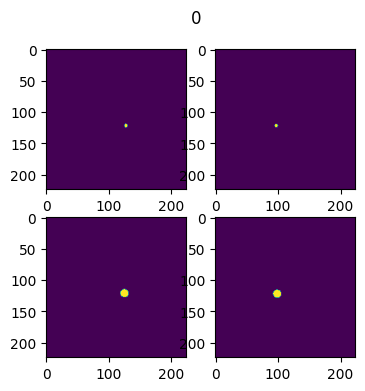

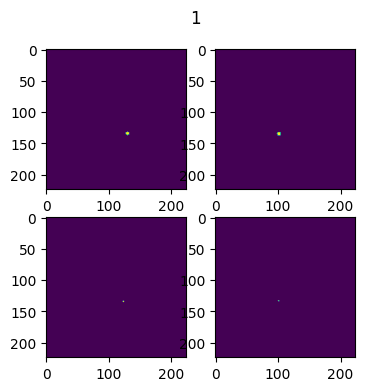

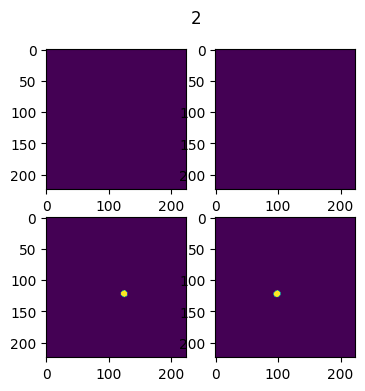

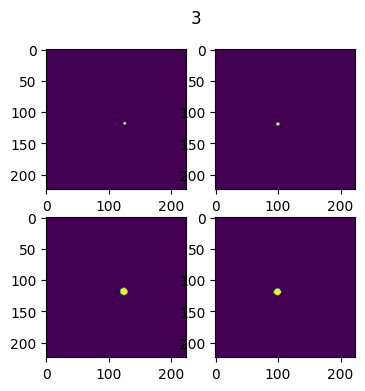

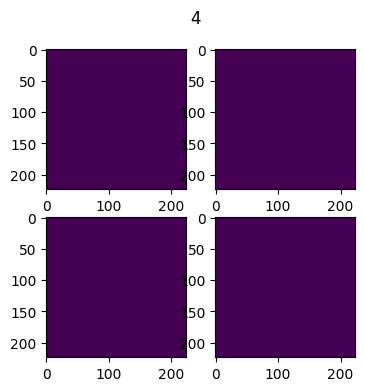

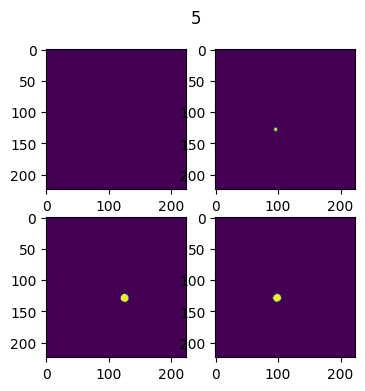

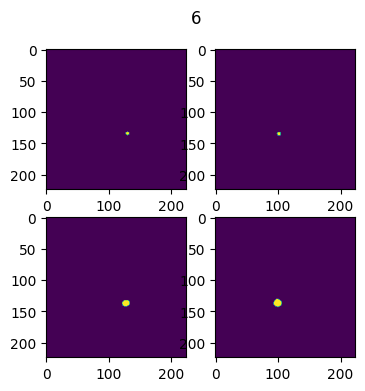

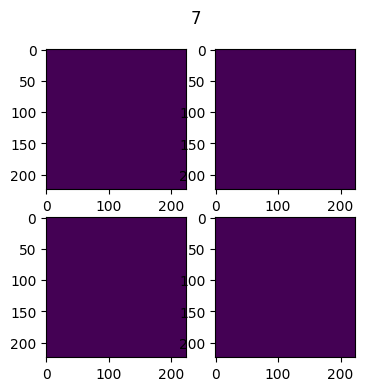

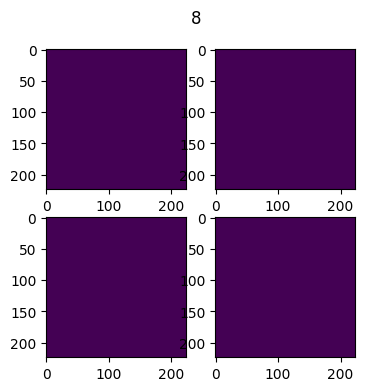

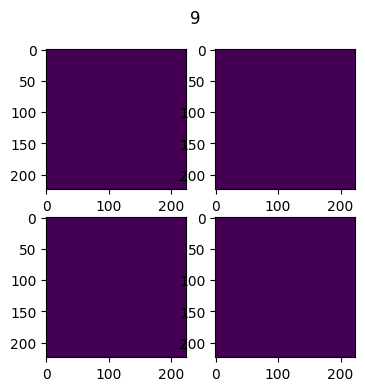

In [ ]:
for i in range(10):
    out = outputs[i]
    gt = gts[i]
    out = out.sigmoid().cpu().detach().numpy().transpose(1,2,0)>0.1
    gt = gt.cpu().detach().numpy().transpose(1,2,0)>0.5
    plt.figure(figsize=(4,4))
    for j in range(2):
        plt.subplot(2,2,j+1)
        plt.imshow(gt[...,j])
        plt.subplot(2,2,j+3)
        plt.imshow(out[...,j])
    plt.suptitle(i)


In [ ]:
outputs.shape, gts.shape

(torch.Size([1975, 2, 224, 224]), torch.Size([1975, 2, 224, 224]))

In [ ]:
df_all = pd.DataFrame({'path': glob(os.path.join(CFG.data_dir, '*', '*', '*.png'))})
df_all['study_id'] = df_all['path'].apply(lambda x: int(x.split('/')[-3]))
df_all['series_id'] = df_all['path'].apply(lambda x: int(x.split('/')[-2]))
df_all['instance_number'] = df_all['path'].apply(lambda x: int(x.split('/')[-1].split('.')[0]))
df_all

,path,study_id,series_id,instance_number
0,/content/train/crop256/4139537637/4177568421/1...,4139537637,4177568421,11
1,/content/train/crop256/4139537637/4177568421/7...,4139537637,4177568421,7
2,/content/train/crop256/4139537637/4177568421/4...,4139537637,4177568421,4
3,/content/train/crop256/4139537637/4177568421/6...,4139537637,4177568421,6
4,/content/train/crop256/4139537637/4177568421/1...,4139537637,4177568421,12
...,...,...,...,...
147213,/content/train/crop256/2020252446/1244994714/5...,2020252446,1244994714,5
147214,/content/train/crop256/2020252446/1244994714/1...,2020252446,1244994714,17
147215,/content/train/crop256/2020252446/1244994714/1...,2020252446,1244994714,18
147216,/content/train/crop256/2020252446/1244994714/1...,2020252446,1244994714,15


In [ ]:
df_sd

,study_id,series_id,series_description
0,4003253,702807833,Sagittal T2/STIR
1,4003253,1054713880,Sagittal T1
2,4003253,2448190387,Axial T2
3,4646740,3201256954,Axial T2
4,4646740,3486248476,Sagittal T1
...,...,...,...
6289,4287160193,1507070277,Sagittal T2/STIR
6290,4287160193,1820446240,Axial T2
6291,4290709089,3274612423,Sagittal T2/STIR
6292,4290709089,3390218084,Axial T2


In [ ]:
df_sd_ss = df_sd[df_sd['series_description']=='Axial T2'].reset_index(drop=True)
df_sd_ss

,study_id,series_id,series_description
0,4003253,2448190387,Axial T2
1,4646740,3201256954,Axial T2
2,7143189,1951927562,Axial T2
3,8785691,2406919186,Axial T2
4,10728036,142859125,Axial T2
...,...,...,...
2335,4282019580,121051321,Axial T2
2336,4283570761,3321662903,Axial T2
2337,4284048608,3891595425,Axial T2
2338,4287160193,1820446240,Axial T2


In [ ]:
# df_all['series_description'] = 'tmp'
df_all = df_all.merge(df_sd, on=['study_id', 'series_id'], how='left')
df_all

,path,study_id,series_id,instance_number,series_description
0,/content/train/crop256/2782244888/3788734728/8...,2782244888,3788734728,8,Sagittal T2/STIR
1,/content/train/crop256/2782244888/3788734728/1...,2782244888,3788734728,13,Sagittal T2/STIR
2,/content/train/crop256/2782244888/3788734728/6...,2782244888,3788734728,6,Sagittal T2/STIR
3,/content/train/crop256/2782244888/3788734728/3...,2782244888,3788734728,3,Sagittal T2/STIR
4,/content/train/crop256/2782244888/3788734728/5...,2782244888,3788734728,5,Sagittal T2/STIR
...,...,...,...,...,...
147213,/content/train/crop256/2623777621/1522924858/1...,2623777621,1522924858,19,Axial T2
147214,/content/train/crop256/2623777621/1522924858/1...,2623777621,1522924858,16,Axial T2
147215,/content/train/crop256/2623777621/1522924858/3...,2623777621,1522924858,38,Axial T2
147216,/content/train/crop256/2623777621/1522924858/3...,2623777621,1522924858,30,Axial T2


In [ ]:
df_all['series_description'].unique()

array(['Sagittal T2/STIR', 'Axial T2', 'Sagittal T1'], dtype=object)

In [ ]:
df_all_ss = df_all[df_all['series_description']=='Axial T2'].reset_index(drop=True)
df_all_ss = df_all_ss.merge(df[['study_id', 'fold']], on=['study_id'], how='left')
df_all_ss

,path,study_id,series_id,instance_number,series_description,fold
0,/content/train/crop256/2782244888/3525830627/8...,2782244888,3525830627,8,Axial T2,6
1,/content/train/crop256/2782244888/3525830627/1...,2782244888,3525830627,13,Axial T2,6
2,/content/train/crop256/2782244888/3525830627/6...,2782244888,3525830627,6,Axial T2,6
3,/content/train/crop256/2782244888/3525830627/3...,2782244888,3525830627,3,Axial T2,6
4,/content/train/crop256/2782244888/3525830627/5...,2782244888,3525830627,5,Axial T2,6
...,...,...,...,...,...,...
79974,/content/train/crop256/2623777621/1522924858/1...,2623777621,1522924858,19,Axial T2,7
79975,/content/train/crop256/2623777621/1522924858/1...,2623777621,1522924858,16,Axial T2,7
79976,/content/train/crop256/2623777621/1522924858/3...,2623777621,1522924858,38,Axial T2,7
79977,/content/train/crop256/2623777621/1522924858/3...,2623777621,1522924858,30,Axial T2,7


In [ ]:
df_all_ss['fold'].unique()

array([6, 2, 9, 7, 5, 1, 3, 0, 8, 4])

In [ ]:
class RSNADataset(Dataset):
    def __init__(self, df, df_lc, df_sd,
                 num_slice_sagital, num_slice_axial,
                 channel_offsets, mid_range,
                 value_neighbors, value_neighbors2,
                 mode, transform):

        self.df = df
        self.df_lc = df_lc
        self.df_sd = df_sd
        self.num_slice_sagital = num_slice_sagital
        self.num_slice_axial = num_slice_axial
        self.channel_offsets = channel_offsets
        self.mid_range = mid_range
        self.value_neighbors = value_neighbors
        self.value_neighbors2 = value_neighbors2
        self.mode = mode
        self.transform = transform

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        row = self.df.iloc[index]
        sid = row['study_id']
        df_series = self.df_sd[self.df_sd['study_id']==sid].reset_index(drop=True)
        df_lc = self.df_lc[(self.df_lc['study_id']==sid)].reset_index(drop=True)

        filenames_sat2, labels_aux_sat2 = self.get_files_and_auxlabel_from_series_description(df_series, df_lc, 'Sagittal T2/STIR')
        filenames_sat1, labels_aux_sat1 = self.get_files_and_auxlabel_from_series_description(df_series, df_lc, 'Sagittal T1')
        filenames_axt2, labels_aux_axt2 = self.get_files_and_auxlabel_from_series_description(df_series, df_lc, 'Axial T2')
        if labels_aux_sat2 is not None:
            labels_aux_sat2 = self.replace_vertical_neighbors(labels_aux_sat2, self.value_neighbors, self.value_neighbors2)
        if labels_aux_sat1 is not None:
            labels_aux_sat1 = self.replace_vertical_neighbors(labels_aux_sat1, self.value_neighbors, self.value_neighbors2)
        if labels_aux_axt2 is not None:
            labels_aux_axt2 = self.replace_vertical_neighbors(labels_aux_axt2, self.value_neighbors, self.value_neighbors2)
        num_files_sat2 = len(filenames_sat2)
        num_files_sat1 = len(filenames_sat1)
        num_files_axt2 = len(filenames_axt2)
        indices_sat2 = self.get_slice_indices(num_files_sat2, self.num_slice_sagital)
        indices_sat1 = self.get_slice_indices(num_files_sat1, self.num_slice_sagital)
        indices_axt2 = self.get_slice_indices(num_files_axt2, self.num_slice_axial)
        idx_plane = None
        if (self.mode == 'train')&(random.random() < CFG.p_drop_plane):
            idx_plane = random.randint(0,2)

        imgs_sat2, imgs_sat1, imgs_axt2 = [], [], []
        for idx in indices_sat2:
            img = self.load_images(idx, filenames_sat2)
            imgs_sat2.append(img)
        if (len(imgs_sat2)==0)|(idx_plane==0):
            imgs_sat2 = np.zeros([self.num_slice_sagital, len(self.channel_offsets), CFG.image_size, CFG.image_size], dtype=np.float32)
            labels_aux_sat2 = np.zeros([self.num_slice_sagital, 5], dtype=np.float32)
        else:
            imgs_sat2 = np.stack(imgs_sat2, 0)
            n, h, w, c = imgs_sat2.shape
            imgs_sat2 = imgs_sat2.transpose(1,2,0,3)
            imgs_sat2 = imgs_sat2.reshape(h, w, n*c)
            imgs_sat2 = self.transform(image=imgs_sat2)['image']
            imgs_sat2 = imgs_sat2.reshape(CFG.image_size, CFG.image_size, n, c)
            imgs_sat2 = imgs_sat2.transpose(2,3,0,1)
            imgs_sat2 = imgs_sat2.astype(np.float32) / 255.
            labels_aux_sat2 = labels_aux_sat2[np.clip(indices_sat2, 0, num_files_sat2-1)]
        for idx in indices_sat1:
            img = self.load_images(idx, filenames_sat1)
            imgs_sat1.append(img)
        if (len(imgs_sat1)==0)|(idx_plane==1):
            imgs_sat1 = np.zeros([self.num_slice_sagital, len(self.channel_offsets), CFG.image_size, CFG.image_size], dtype=np.float32)
            labels_aux_sat1 = np.zeros([self.num_slice_sagital, 5], dtype=np.float32)
        else:
            imgs_sat1 = np.stack(imgs_sat1, 0)
            n, h, w, c = imgs_sat1.shape
            imgs_sat1 = imgs_sat1.transpose(1,2,0,3)
            imgs_sat1 = imgs_sat1.reshape(h, w, n*c)
            imgs_sat1 = self.transform(image=imgs_sat1)['image']
            imgs_sat1 = imgs_sat1.reshape(CFG.image_size, CFG.image_size, n, c)
            imgs_sat1 = imgs_sat1.transpose(2,3,0,1)
            imgs_sat1 = imgs_sat1.astype(np.float32) / 255.
            labels_aux_sat1 = labels_aux_sat1[np.clip(indices_sat1, 0, num_files_sat1-1)]

        for idx in indices_axt2:
            img = self.load_images(idx, filenames_axt2)
            imgs_axt2.append(img)
        if (len(imgs_axt2)==0)|(idx_plane==2):
            imgs_axt2 = np.zeros([self.num_slice_axial, len(self.channel_offsets), CFG.image_size, CFG.image_size], dtype=np.float32)
            labels_aux_axt2 = np.zeros([self.num_slice_axial, 5], dtype=np.float32)
        else:
            imgs_axt2 = np.stack(imgs_axt2, 0)
            n, h, w, c = imgs_axt2.shape
            imgs_axt2 = imgs_axt2.transpose(1,2,0,3)
            imgs_axt2 = imgs_axt2.reshape(h, w, n*c)
            imgs_axt2 = self.transform(image=imgs_axt2)['image']
            imgs_axt2 = imgs_axt2.reshape(CFG.image_size, CFG.image_size, n, c)
            imgs_axt2 = imgs_axt2.transpose(2,3,0,1)
            imgs_axt2 = imgs_axt2.astype(np.float32) / 255.
            labels_aux_axt2 = labels_aux_axt2[np.clip(indices_axt2, 0, num_files_axt2-1)]

        if self.mode != 'test':
            if (self.mode == 'train')&(random.random() < 0.5):
                imgs_sat2 = imgs_sat2[::-1,::-1].copy()
                imgs_sat1 = imgs_sat1[::-1,::-1].copy()
                imgs_axt2 = imgs_axt2[::-1,::-1].copy()
                labels_aux_sat1 = labels_aux_sat1[::-1].copy()
                labels_aux_sat2 = labels_aux_sat2[::-1].copy()
                labels_aux_axt2 = labels_aux_axt2[::-1].copy()
            imgs_sat2 = torch.tensor(imgs_sat2).float()
            imgs_sat1 = torch.tensor(imgs_sat1).float()
            imgs_axt2 = torch.tensor(imgs_axt2).float()

            labels = torch.tensor(row[CFG.targets].values.astype(np.int64))
            # labels_l1_l2 = torch.tensor(row[CFG.targets_l1_l2].values.astype(np.int64))
            # labels_l2_l3 = torch.tensor(row[CFG.targets_l2_l3].values.astype(np.int64))
            # labels_l3_l4 = torch.tensor(row[CFG.targets_l3_l4].values.astype(np.int64))
            # labels_l4_l5 = torch.tensor(row[CFG.targets_l4_l5].values.astype(np.int64))
            # labels_l5_s1 = torch.tensor(row[CFG.targets_l5_s1].values.astype(np.int64))

            labels_aux_sat1 = torch.tensor(labels_aux_sat1)
            labels_aux_sat2 = torch.tensor(labels_aux_sat2)
            labels_aux_axt2 = torch.tensor(labels_aux_axt2)

            if self.mode == 'train' and random.random() < CFG.p_rand_order_v1:
                indices = torch.randperm(imgs_sat2.size(0))
                imgs_sat2 = imgs_sat2[indices]
                indices = torch.randperm(imgs_sat1.size(0))
                imgs_sat1 = imgs_sat1[indices]
                indices = torch.randperm(imgs_axt2.size(0))
                imgs_axt2 = imgs_axt2[indices]

            return {'image_sat1': imgs_sat1.float(),
                    'image_sat2': imgs_sat2.float(),
                    'image_axt2': imgs_axt2.float(),
                    'label': labels,
                    # 'label_l1_l2': labels_l1_l2,
                    # 'label_l2_l3': labels_l2_l3,
                    # 'label_l3_l4': labels_l3_l4,
                    # 'label_l4_l5': labels_l4_l5,
                    # 'label_l5_s1': labels_l5_s1,
                    'label_aux_sat1': labels_aux_sat1,
                    'label_aux_sat2': labels_aux_sat2,
                    'label_aux_axt2': labels_aux_axt2,
                   }
        else:
            return {'image_sat1': imgs_sat1.float(),
                    'image_sat2': imgs_sat2.float(),
                    'image_axt2': imgs_axt2.float(),
                    }

    def get_files_and_auxlabel_from_series_description(self, df_series, df_lc, image_type):
        sd2conds = {'Sagittal T2/STIR': ['Spinal Canal Stenosis'],
                   'Sagittal T1': ['Left Neural Foraminal Narrowing', 'Right Neural Foraminal Narrowing'],
                   'Axial T2': ['Left Subarticular Stenosis', 'Right Subarticular Stenosis']
                   }
        levels2idx = {'L1/L2': 0,
                      'L2/L3': 1,
                      'L3/L4': 2,
                      'L4/L5': 3,
                      'L5/S1': 4
                      }
        row_series = df_series[df_series['series_description']==image_type]
        new_row_lc = []
        conds = sd2conds[image_type]
        for cond in conds:
            new_row_lc.append(df_lc[df_lc['condition']==cond])
        new_row_lc = pd.concat(new_row_lc).reset_index(drop=True)
        try:
            if self.mode=='train':
                series = row_series.sample(1).iloc[0]
            else:
                series = row_series.iloc[0]
            sid = series['study_id']
            seid = series['series_id']
            new_row_lc = new_row_lc[new_row_lc['series_id']==seid]
            #print(os.path.join(CFG.data_dir, str(sid), str(series['series_id']), '*.png'))
            filenames = glob(os.path.join(CFG.data_dir, str(sid), str(seid), '*.png'))
            filenames = natsorted(filenames)
            labels_aux = np.zeros([len(filenames), 5], dtype=np.float32)
            for i, filename in enumerate(filenames):
                sid_, seid_ = filename.split('/')[-2:]
                seid_ = seid_.split('.')[0]
                row_lc_labeled = new_row_lc[new_row_lc['instance_number']==int(seid_)]
                if len(row_lc_labeled)!=0:
                    for j, row in row_lc_labeled.iterrows():
                        level_idx = levels2idx[row['level']]
                        labels_aux[i,level_idx] = 1.0
        except:
            filenames = []
            labels_aux = None
        return filenames, labels_aux

    def get_slice_indices(self, num_files, num_slices):
        if num_files==0:
            indices = []
        else:
            mid = int(num_files/num_slices/2)
            indices = np.round(np.linspace(mid, num_files - mid, num_slices)).astype(int)
            if self.mode=='train':
                v = min(self.mid_range, mid)
                offset = np.random.choice(np.arange(-v, v+1))
                indices += offset
        return indices

    def replace_vertical_neighbors(self, arr, replace_value=0.5, replace_value2=0.5):
        # Create a copy of the original array to avoid modifying it
        modified_arr = arr.copy()

        # Get the shape of the array
        rows, cols = arr.shape

        # Iterate over each element in the array
        for i in range(rows):
            for j in range(cols):
                if arr[i, j] == 1:
                    # Check the top neighbor
                    if i > 0 and arr[i-1, j] != 1:
                        modified_arr[i-1, j] = replace_value
                    if i > 1 and arr[i-2, j] != 1:
                        modified_arr[i-2, j] = replace_value2
                    # Check the bottom neighbor
                    if i < rows-1 and arr[i+1, j] != 1:
                        modified_arr[i+1, j] = replace_value
                    if i < rows-2 and arr[i+2, j] != 1:
                        modified_arr[i+2, j] = replace_value2

        return modified_arr

    def load_images(self, idx, filenames):
        imgs = []
        idx_max = len(filenames) - 1
        for offset in self.channel_offsets:
            idx_img = np.clip(idx + offset, 0, idx_max)
            img = cv2.imread(filenames[idx_img], cv2.IMREAD_GRAYSCALE)
            imgs.append(img)
        imgs = np.array(imgs).transpose(1,2,0)
        return imgs

class RSNADatasetInfAxt2(Dataset):
    def __init__(self, df,
                 channel_offsets,
                 mode, transform):

        self.df = df
        self.channel_offsets = channel_offsets
        self.mode = mode
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        row = self.df.iloc[index]
        sid = row['study_id']
        seid = row['series_id']
        inumber = row['instance_number']
        filenames = glob(os.path.join(CFG.data_dir, str(sid), str(seid), '*.png'))
        filenames = natsorted(filenames)
        inumbers = [int(filename.split('/')[-1].split('.')[0]) for filename in filenames]
        idx_inumber = inumbers.index(inumber)
        imgs = self.load_images(filenames, sid, seid, idx_inumber)
        data = self.transform(image=imgs)
        imgs = data['image']
        imgs = imgs.transpose(2,0,1)
        imgs = imgs.astype(np.float32) / 255.

        if self.mode != 'test':
            if (self.mode == 'train')&(random.random() < 0.5):
                imgs = imgs[::-1,::-1].copy()

            imgs = torch.tensor(imgs).float()
            return {'image': imgs,
                    'study_id': sid,
                    'series_id': seid,
                    'instance_number': inumber
                    }
        else:
            return {'image_sat1': imgs,
                    }

    def load_images(self, filenames, stid, seid, idx):
        imgs = []
        if self.mode=='train':
            offset = np.random.choice(np.arange(-self.mid_range, self.mid_range+1))
            idx += offset
        for offset in self.channel_offsets:
            idx_img = np.clip(idx + offset, 0, len(filenames)-1)
            try:
                img = cv2.imread(filenames[idx_img], cv2.IMREAD_GRAYSCALE)
            except:
                img = np.zeros([256, 256], dtype=np.uint8)
                print('in')
                print(len(filenames), idx_img)
            imgs.append(img)
        imgs = np.array(imgs).transpose(1,2,0)
        return imgs

    def get_mask(self, seid, inumber):
        levels2idx = {'L1/L2': 0,
                      'L2/L3': 1,
                      'L3/L4': 2,
                      'L4/L5': 3,
                      'L5/S1': 4
                      }
        mask = np.zeros([CFG.image_size_raw, CFG.image_size_raw, 5], dtype=np.uint8)
        df_lc = []
        for i in [-1, 0, 1]:
            df_lc = self.df_lc[(self.df_lc['series_id']==seid)&(self.df_lc['instance_number']==inumber+i)]
            for j, row in df_lc.iterrows():
                x = row['x_new']
                y = row['y_new']
                level_idx = levels2idx[row['level']]
                if i==0:
                    mask[..., level_idx] = cv2.circle(mask[..., level_idx].copy(), (x, y), CFG.radius, 1, -1)
                elif (i==-1)|(i==1):
                    mask[..., level_idx] = cv2.circle(mask[..., level_idx].copy(), (x, y), CFG.radius_neighbor, 1, -1)
                elif (i==-2)|(i==2):
                    mask[..., level_idx] = cv2.circle(mask[..., level_idx].copy(), (x, y), CFG.radius_neighbor2, 1, -1)
        return mask



In [ ]:
def inference_save_fn(model, loader_valid):
    model.eval()
    bar = tqdm(loader_valid)
    with torch.no_grad():
        for data in bar:
            images = data['image']
            seids = data['series_id']
            stids = data['study_id']
            inumbers = data['instance_number']
            images = images.cuda()
            bs = images.shape[0]

            #logits = model(images_sat1, images_sat2, images_axt2)
            logits = model(images).sigmoid()
            logits = logits.cpu().detach().numpy()*255
            logits = logits.astype(np.uint8)
            for i in range(bs):
                stid = stids[i]
                seid = seids[i]
                logit = logits[i].transpose(1,2,0)
                inumber = inumbers[i]
                save_dir = f'/content/mask/{stid}/{seid}'
                os.makedirs(save_dir, exist_ok=True)
                np.save(os.path.join(save_dir, f'{inumber}.npy'), logit)

In [ ]:
for fold in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
    valid_ = df_all_ss[df_all_ss['fold'] == fold].reset_index(drop=True)
    dataset_valid = RSNADatasetInfAxt2(valid_, CFG.indices_ch,
                                   'valid', transform=transforms_valid
                                   )
    loader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=CFG.batch_size, shuffle=False, num_workers=CFG.num_workers)

    model =  smp.Unet(encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
            in_channels=CFG.in_chans,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
            classes=2,        # model output channels (number of classes in your dataset)
            activation=None,
            )
    model.load_state_dict(torch.load(os.path.join(CFG.model_dir, f'{CFG.kernel_type}_fold{fold}_best.pth')))
    #model = TimmModelV1(CFG.backbone, in_c=int(CFG.n_slice_axial+CFG.n_slice_sagital*2), n_classes=CFG.out_dim, pretrained=True)
    model = model.to(device)
    inference_save_fn(model, loader_valid)

100%|██████████| 253/253 [00:57<00:00,  4.40it/s]


In [ ]:
!zip -r /content/mask.zip /content/mask

ストリーミング出力は最後の 5000 行に切り捨てられました。
  adding: content/mask/2620453928/541695853/28.npy (deflated 99%)
  adding: content/mask/2620453928/541695853/32.npy (deflated 99%)
  adding: content/mask/2620453928/541695853/9.npy (deflated 99%)
  adding: content/mask/2620453928/541695853/24.npy (deflated 99%)
  adding: content/mask/2620453928/541695853/39.npy (deflated 99%)
  adding: content/mask/2620453928/541695853/8.npy (deflated 99%)
  adding: content/mask/2620453928/541695853/25.npy (deflated 99%)
  adding: content/mask/2620453928/541695853/27.npy (deflated 99%)
  adding: content/mask/2620453928/541695853/36.npy (deflated 99%)
  adding: content/mask/2620453928/541695853/46.npy (deflated 99%)
  adding: content/mask/2620453928/541695853/12.npy (deflated 99%)
  adding: content/mask/2620453928/541695853/31.npy (deflated 99%)
  adding: content/mask/2620453928/541695853/26.npy (deflated 99%)
  adding: content/mask/2620453928/541695853/22.npy (deflated 99%)
  adding: content/mask/2620453928/541695853/52

In [ ]:
!cp mask.zip $CFG.save_dir